# PHASE_4_PROJECT

### Working dataset

Walmart weekly sales from Feb 2010 to Oct 2012.

### Target

Develop a forecasting tool that leverages time series models to predict sales forecasts.

# 1. Data wrangling

Import necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline

First, relevant dataset will be loaded below:

### 1.1. Store data

Store data file contains anonymized information about the 45 stores, indicating the type and size of store.

In [2]:
stores_data = pd.read_csv('/Users/thaophan/Documents/Flatiron/Phase4_Project/Data/walmart-recruiting-store-sales-forecasting/stores.csv')
stores_data

Store Type    Size
0       1    A  151315
1       2    A  202307
2       3    B   37392
3       4    A  205863
4       5    B   34875
5       6    A  202505
6       7    B   70713
7       8    A  155078
8       9    B  125833
9      10    B  126512
10     11    A  207499
11     12    B  112238
12     13    A  219622
13     14    A  200898
14     15    B  123737
15     16    B   57197
16     17    B   93188
17     18    B  120653
18     19    A  203819
19     20    A  203742
20     21    B  140167
21     22    B  119557
22     23    B  114533
23     24    A  203819
24     25    B  128107
25     26    A  152513
26     27    A  204184
27     28    A  206302
28     29    B   93638
29     30    C   42988
30     31    A  203750
31     32    A  203007
32     33    A   39690
33     34    A  158114
34     35    B  103681
35     36    A   39910
36     37    C   39910
37     38    C   39690
38     39    A  184109
39     40    A  155083
40     41    A  196321
41     42    C   39690
42     43    C   41062
43     44    C   39910
44     45    B  118221

In [3]:
stores_data.groupby('Type')['Size'].mean()

Type
A    177247.727273
B    101190.705882
C     40541.666667
Name: Size, dtype: float64

Store type is categorized by the size of the stores.

In [4]:
stores_data.shape

(45, 3)

In [5]:
stores_data.head(10)

Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875
5      6    A  202505
6      7    B   70713
7      8    A  155078
8      9    B  125833
9     10    B  126512

### 1.2. Features data

Below file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields:

- Store: the store number
- Date: date in the week
- Weekly_Sales: sales for the given department in the given store
- IsHoliday: whether the week is a special holiday week
- Temperature: average temperature in the region
- Fuel_Price: cost of fuel in the region
- MarkDown1-5: anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
- CPI: the consumer price index
- Unemployment: the unemployment rate

In [6]:
features_data = pd.read_csv('/Users/thaophan/Documents/Flatiron/Phase4_Project/Data/walmart-recruiting-store-sales-forecasting/features.csv')

In [7]:
features_data.shape

(8190, 12)

In [8]:
features_data.head(5)

Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN        NaN  211.289143         8.106      False  
3        NaN        NaN        NaN  211.319643         8.106      False  
4        NaN        NaN        NaN  211.350143         8.106      False

To obtain store type information, we will merge the two dataframes 'features_data' and 'stores_data'.

In [9]:
features_df = pd.merge(features_data,stores_data,how = 'left',left_on = 'Store', right_on = 'Store')

In [10]:

features_df.shape

(8190, 14)

In [11]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
 12  Type          8190 non-null   object 
 13  Size          8190 non-null   int64  
dtypes: bool(1), float64(9), int64(2), object(2)
memory usage: 839.9+ KB


Change datatype of column 'Date' into datetime type.

In [12]:
features_df.head()

Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday Type  \
0        NaN        NaN        NaN  211.096358         8.106      False    A   
1        NaN        NaN        NaN  211.242170         8.106       True    A   
2        NaN        NaN        NaN  211.289143         8.106      False    A   
3        NaN        NaN        NaN  211.319643         8.106      False    A   
4        NaN        NaN        NaN  211.350143         8.106      False    A   

     Size  
0  151315  
1  151315  
2  151315  
3  151315  
4  151315

In [13]:
features_df['Date'] = pd.to_datetime(features_df['Date'])
features_df.tail()

Store       Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
8185     45 2013-06-28        76.05       3.639    4842.29     975.03   
8186     45 2013-07-05        77.50       3.614    9090.48    2268.58   
8187     45 2013-07-12        79.37       3.614    3789.94    1827.31   
8188     45 2013-07-19        82.84       3.737    2961.49    1047.07   
8189     45 2013-07-26        76.06       3.804     212.02     851.73   

      MarkDown3  MarkDown4  MarkDown5  CPI  Unemployment  IsHoliday Type  \
8185       3.00    2449.97    3169.69  NaN           NaN      False    B   
8186     582.74    5797.47    1514.93  NaN           NaN      False    B   
8187      85.72     744.84    2150.36  NaN           NaN      False    B   
8188     204.19     363.00    1059.46  NaN           NaN      False    B   
8189       2.06      10.88    1864.57  NaN           NaN      False    B   

        Size  
8185  118221  
8186  118221  
8187  118221  
8188  118221  
8189  118221

In [14]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         8190 non-null   int64         
 1   Date          8190 non-null   datetime64[ns]
 2   Temperature   8190 non-null   float64       
 3   Fuel_Price    8190 non-null   float64       
 4   MarkDown1     4032 non-null   float64       
 5   MarkDown2     2921 non-null   float64       
 6   MarkDown3     3613 non-null   float64       
 7   MarkDown4     3464 non-null   float64       
 8   MarkDown5     4050 non-null   float64       
 9   CPI           7605 non-null   float64       
 10  Unemployment  7605 non-null   float64       
 11  IsHoliday     8190 non-null   bool          
 12  Type          8190 non-null   object        
 13  Size          8190 non-null   int64         
dtypes: bool(1), datetime64[ns](1), float64(9), int64(2), object(1)
memory usage: 839.9+ KB


In [15]:
features_df.isna().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
Type               0
Size               0
dtype: int64

Check duplicates and there is no duplicate.

In [16]:
check_duplicate = features_df.duplicated().sum()
check_duplicate

0

Link stores & date together

In [17]:

features_df['Store_Date'] = features_df['Store'].astype(str) + '_' + features_df['Date'].astype(str)
features_df.head()

Store       Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  \
0      1 2010-02-05        42.31       2.572        NaN        NaN        NaN   
1      1 2010-02-12        38.51       2.548        NaN        NaN        NaN   
2      1 2010-02-19        39.93       2.514        NaN        NaN        NaN   
3      1 2010-02-26        46.63       2.561        NaN        NaN        NaN   
4      1 2010-03-05        46.50       2.625        NaN        NaN        NaN   

   MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday Type    Size  \
0        NaN        NaN  211.096358         8.106      False    A  151315   
1        NaN        NaN  211.242170         8.106       True    A  151315   
2        NaN        NaN  211.289143         8.106      False    A  151315   
3        NaN        NaN  211.319643         8.106      False    A  151315   
4        NaN        NaN  211.350143         8.106      False    A  151315   

     Store_Date  
0  1_2010-02-05  
1  1_2010-02-12  
2  1_2010-02-19  
3  1_2010-02-26  
4  1_2010-03-05

### 1.3. Holiday data

As for convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):

- Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
- Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
- Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
- Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

Create a dataframe for holiday:

In [18]:
holiday = {
    'Holiday Name': ['Super Bowl', 'Super Bowl', 'Super Bowl', 'Super Bowl',
                     'Labor Day', 'Labor Day', 'Labor Day', 'Labor Day',
                     'Thanksgiving', 'Thanksgiving', 'Thanksgiving', 'Thanksgiving',
                     'Christmas', 'Christmas', 'Christmas', 'Christmas'],
    'Date': ['12-Feb-10', '11-Feb-11', '10-Feb-12', '8-Feb-13',
             '10-Sep-10', '9-Sep-11', '7-Sep-12', '6-Sep-13',
             '26-Nov-10', '25-Nov-11', '23-Nov-12', '29-Nov-13',
             '31-Dec-10', '30-Dec-11', '28-Dec-12', '27-Dec-13']
}
holiday_df = pd.DataFrame(holiday)
holiday_df

Holiday Name       Date
0     Super Bowl  12-Feb-10
1     Super Bowl  11-Feb-11
2     Super Bowl  10-Feb-12
3     Super Bowl   8-Feb-13
4      Labor Day  10-Sep-10
5      Labor Day   9-Sep-11
6      Labor Day   7-Sep-12
7      Labor Day   6-Sep-13
8   Thanksgiving  26-Nov-10
9   Thanksgiving  25-Nov-11
10  Thanksgiving  23-Nov-12
11  Thanksgiving  29-Nov-13
12     Christmas  31-Dec-10
13     Christmas  30-Dec-11
14     Christmas  28-Dec-12
15     Christmas  27-Dec-13

Adding weekday & week number. Use .isocalendar() method to get weekday and weeknumber, which starts on Monday and ends on Sunday. 

In [19]:
holiday_df['Date'] = pd.to_datetime(holiday_df['Date'])
holiday_df['Day'] = holiday_df['Date'].dt.day_name()
holiday_df['Week'] = holiday_df['Date'].dt.isocalendar().week

/var/folders/xf/z2fcddts049dxg763n_0c6qw0000gn/T/ipykernel_68927/3350255084.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  holiday_df['Date'] = pd.to_datetime(holiday_df['Date'])


In [20]:
holiday_df

Holiday Name       Date     Day  Week
0     Super Bowl 2010-02-12  Friday     6
1     Super Bowl 2011-02-11  Friday     6
2     Super Bowl 2012-02-10  Friday     6
3     Super Bowl 2013-02-08  Friday     6
4      Labor Day 2010-09-10  Friday    36
5      Labor Day 2011-09-09  Friday    36
6      Labor Day 2012-09-07  Friday    36
7      Labor Day 2013-09-06  Friday    36
8   Thanksgiving 2010-11-26  Friday    47
9   Thanksgiving 2011-11-25  Friday    47
10  Thanksgiving 2012-11-23  Friday    47
11  Thanksgiving 2013-11-29  Friday    48
12     Christmas 2010-12-31  Friday    52
13     Christmas 2011-12-30  Friday    52
14     Christmas 2012-12-28  Friday    52
15     Christmas 2013-12-27  Friday    52

Turn date in features_df into week number for easy & simply visualization.

### 1.4. Sales data

Below is given historical training data, which covers to 2010-02-05 to 2012-11-01. Within this file you will find the following fields:

- Store: the store number
- Dept: the department number
- Date: date in the week
- Weekly_Sales: sales for the given department in the given store
- IsHoliday: whether the week is a special holiday week

In [21]:
sales_data = pd.read_csv('/Users/thaophan/Documents/Flatiron/Phase4_Project/Data/walmart-recruiting-store-sales-forecasting/train.csv')
sales_data.head()

Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False

Given train dataset includes 143 weeks of observations, from Feb 2010 to Nov 2012.

In [22]:
sales_data['Date'].nunique()

143

In [23]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


Turn "Date" object type into datatime type.

In [24]:
sales_data['Date'] = pd.to_datetime(sales_data['Date'])

Add week, month & year columns into the features_df for further analysis and visualization.

In [25]:
sales_data['Week'] = sales_data['Date'].dt.isocalendar().week.astype(int)
sales_data['Year'] = sales_data['Date'].dt.isocalendar().year.astype(int)
sales_data['Month'] = sales_data['Date'].dt.month.astype(int)

In [26]:
sales_data.head()

Store  Dept       Date  Weekly_Sales  IsHoliday  Week  Year  Month
0      1     1 2010-02-05      24924.50      False     5  2010      2
1      1     1 2010-02-12      46039.49       True     6  2010      2
2      1     1 2010-02-19      41595.55      False     7  2010      2
3      1     1 2010-02-26      19403.54      False     8  2010      2
4      1     1 2010-03-05      21827.90      False     9  2010      3

In [27]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Week          421570 non-null  int64         
 6   Year          421570 non-null  int64         
 7   Month         421570 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(1), int64(5)
memory usage: 22.9 MB


Link stores & date together to merge with features_df

In [28]:
sales_data['Store_Date'] = sales_data['Store'].astype(str) + '_' + sales_data['Date'].astype(str)
sales_data.head()

Store  Dept       Date  Weekly_Sales  IsHoliday  Week  Year  Month  \
0      1     1 2010-02-05      24924.50      False     5  2010      2   
1      1     1 2010-02-12      46039.49       True     6  2010      2   
2      1     1 2010-02-19      41595.55      False     7  2010      2   
3      1     1 2010-02-26      19403.54      False     8  2010      2   
4      1     1 2010-03-05      21827.90      False     9  2010      3   

     Store_Date  
0  1_2010-02-05  
1  1_2010-02-12  
2  1_2010-02-19  
3  1_2010-02-26  
4  1_2010-03-05

Combine "features_df" with "train_data"

In [29]:
data = pd.merge(sales_data,features_df, how='left', left_on='Store_Date', right_on='Store_Date')

In [30]:
data.tail()

Store_x  Dept     Date_x  Weekly_Sales  IsHoliday_x  Week  Year  \
421565       45    98 2012-09-28        508.37        False    39  2012   
421566       45    98 2012-10-05        628.10        False    40  2012   
421567       45    98 2012-10-12       1061.02        False    41  2012   
421568       45    98 2012-10-19        760.01        False    42  2012   
421569       45    98 2012-10-26       1076.80        False    43  2012   

        Month     Store_Date  Store_y  ... MarkDown1  MarkDown2  MarkDown3  \
421565      9  45_2012-09-28       45  ...   4556.61      20.64       1.50   
421566     10  45_2012-10-05       45  ...   5046.74        NaN      18.82   
421567     10  45_2012-10-12       45  ...   1956.28        NaN       7.89   
421568     10  45_2012-10-19       45  ...   2004.02        NaN       3.18   
421569     10  45_2012-10-26       45  ...   4018.91      58.08     100.00   

        MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday_y  Type  \
421565    1601.01    3288.25  192.013558         8.684        False     B   
421566    2253.43    2340.01  192.170412         8.667        False     B   
421567     599.32    3990.54  192.327265         8.667        False     B   
421568     437.73    1537.49  192.330854         8.667        False     B   
421569     211.94     858.33  192.308899         8.667        False     B   

          Size  
421565  118221  
421566  118221  
421567  118221  
421568  118221  
421569  118221  

[5 rows x 23 columns]

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 23 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store_x       421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date_x        421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday_x   421570 non-null  bool          
 5   Week          421570 non-null  int64         
 6   Year          421570 non-null  int64         
 7   Month         421570 non-null  int64         
 8   Store_Date    421570 non-null  object        
 9   Store_y       421570 non-null  int64         
 10  Date_y        421570 non-null  datetime64[ns]
 11  Temperature   421570 non-null  float64       
 12  Fuel_Price    421570 non-null  float64       
 13  MarkDown1     150681 non-null  float64       
 14  MarkDown2     111248 non-null  float64       
 15  MarkDown3     137

Set "Date" column as the index

Check Date_x & Date_y, IsHoliday_x &  IsHoliday_y

In [32]:
count_date = (data['Date_x'] == data['Date_y']).sum()
count_date

421570

In [33]:
count_holiday = (data['IsHoliday_x'] == data['IsHoliday_y']).sum()
count_holiday

421570

In [34]:
count_store = (data['Store_x'] == data['Store_y']).sum()
count_store

421570

Since columns Date_y, IsHoliday_y, Store_y have values that are similar with values of columns Date_x, IsHoliday_x & Store_x, we will drop 2 columns Date_y, IsHoliday_y & Store_y

In [35]:
data = data.drop(columns=['Date_y','IsHoliday_y','Store_y','Store_Date'])

In [36]:
data.head()

Store_x  Dept     Date_x  Weekly_Sales  IsHoliday_x  Week  Year  Month  \
0        1     1 2010-02-05      24924.50        False     5  2010      2   
1        1     1 2010-02-12      46039.49         True     6  2010      2   
2        1     1 2010-02-19      41595.55        False     7  2010      2   
3        1     1 2010-02-26      19403.54        False     8  2010      2   
4        1     1 2010-03-05      21827.90        False     9  2010      3   

   Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  \
0        42.31       2.572        NaN        NaN        NaN        NaN   
1        38.51       2.548        NaN        NaN        NaN        NaN   
2        39.93       2.514        NaN        NaN        NaN        NaN   
3        46.63       2.561        NaN        NaN        NaN        NaN   
4        46.50       2.625        NaN        NaN        NaN        NaN   

   MarkDown5         CPI  Unemployment Type    Size  
0        NaN  211.096358         8.106    A  151315  
1        NaN  211.242170         8.106    A  151315  
2        NaN  211.289143         8.106    A  151315  
3        NaN  211.319643         8.106    A  151315  
4        NaN  211.350143         8.106    A  151315

Rename the columns:

In [37]:
data = data.rename(columns={'Store_x':'Store','Date_x':'Date','IsHoliday_x':'IsHoliday' })

In [38]:
data.head()

Store  Dept       Date  Weekly_Sales  IsHoliday  Week  Year  Month  \
0      1     1 2010-02-05      24924.50      False     5  2010      2   
1      1     1 2010-02-12      46039.49       True     6  2010      2   
2      1     1 2010-02-19      41595.55      False     7  2010      2   
3      1     1 2010-02-26      19403.54      False     8  2010      2   
4      1     1 2010-03-05      21827.90      False     9  2010      3   

   Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  \
0        42.31       2.572        NaN        NaN        NaN        NaN   
1        38.51       2.548        NaN        NaN        NaN        NaN   
2        39.93       2.514        NaN        NaN        NaN        NaN   
3        46.63       2.561        NaN        NaN        NaN        NaN   
4        46.50       2.625        NaN        NaN        NaN        NaN   

   MarkDown5         CPI  Unemployment Type    Size  
0        NaN  211.096358         8.106    A  151315  
1        NaN  211.242170         8.106    A  151315  
2        NaN  211.289143         8.106    A  151315  
3        NaN  211.319643         8.106    A  151315  
4        NaN  211.350143         8.106    A  151315

In [39]:
data =data.set_index('Date')
data

Store  Dept  Weekly_Sales  IsHoliday  Week  Year  Month  \
Date                                                                  
2010-02-05      1     1      24924.50      False     5  2010      2   
2010-02-12      1     1      46039.49       True     6  2010      2   
2010-02-19      1     1      41595.55      False     7  2010      2   
2010-02-26      1     1      19403.54      False     8  2010      2   
2010-03-05      1     1      21827.90      False     9  2010      3   
...           ...   ...           ...        ...   ...   ...    ...   
2012-09-28     45    98        508.37      False    39  2012      9   
2012-10-05     45    98        628.10      False    40  2012     10   
2012-10-12     45    98       1061.02      False    41  2012     10   
2012-10-19     45    98        760.01      False    42  2012     10   
2012-10-26     45    98       1076.80      False    43  2012     10   

            Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  \
Date                                                                   
2010-02-05        42.31       2.572        NaN        NaN        NaN   
2010-02-12        38.51       2.548        NaN        NaN        NaN   
2010-02-19        39.93       2.514        NaN        NaN        NaN   
2010-02-26        46.63       2.561        NaN        NaN        NaN   
2010-03-05        46.50       2.625        NaN        NaN        NaN   
...                 ...         ...        ...        ...        ...   
2012-09-28        64.88       3.997    4556.61      20.64       1.50   
2012-10-05        64.89       3.985    5046.74        NaN      18.82   
2012-10-12        54.47       4.000    1956.28        NaN       7.89   
2012-10-19        56.47       3.969    2004.02        NaN       3.18   
2012-10-26        58.85       3.882    4018.91      58.08     100.00   

            MarkDown4  MarkDown5         CPI  Unemployment Type    Size  
Date                                                                     
2010-02-05        NaN        NaN  211.096358         8.106    A  151315  
2010-02-12        NaN        NaN  211.242170         8.106    A  151315  
2010-02-19        NaN        NaN  211.289143         8.106    A  151315  
2010-02-26        NaN        NaN  211.319643         8.106    A  151315  
2010-03-05        NaN        NaN  211.350143         8.106    A  151315  
...               ...        ...         ...           ...  ...     ...  
2012-09-28    1601.01    3288.25  192.013558         8.684    B  118221  
2012-10-05    2253.43    2340.01  192.170412         8.667    B  118221  
2012-10-12     599.32    3990.54  192.327265         8.667    B  118221  
2012-10-19     437.73    1537.49  192.330854         8.667    B  118221  
2012-10-26     211.94     858.33  192.308899         8.667    B  118221  

[421570 rows x 18 columns]

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Weekly_Sales  421570 non-null  float64
 3   IsHoliday     421570 non-null  bool   
 4   Week          421570 non-null  int64  
 5   Year          421570 non-null  int64  
 6   Month         421570 non-null  int64  
 7   Temperature   421570 non-null  float64
 8   Fuel_Price    421570 non-null  float64
 9   MarkDown1     150681 non-null  float64
 10  MarkDown2     111248 non-null  float64
 11  MarkDown3     137091 non-null  float64
 12  MarkDown4     134967 non-null  float64
 13  MarkDown5     151432 non-null  float64
 14  CPI           421570 non-null  float64
 15  Unemployment  421570 non-null  float64
 16  Type          421570 non-null  object 
 17  Size          421570 non-null  i

# 2.Exploratory Data Analysis for 45 stores

The provided dataset contains information on 45 Walmart stores and 99 departments. In this section, we will delve into the data to uncover the insights it holds and gain a better understanding of its contents.

### Negative sales values

In [41]:
data[data['Weekly_Sales']<0]

Store  Dept  Weekly_Sales  IsHoliday  Week  Year  Month  \
Date                                                                  
2012-08-10      1     6       -139.65      False    32  2012      8   
2012-05-04      1    18         -1.27      False    18  2012      5   
2010-02-19      1    47       -863.00      False     7  2010      2   
2010-03-12      1    47       -698.00      False    10  2010      3   
2010-10-08      1    47        -58.00      False    40  2010     10   
...           ...   ...           ...        ...   ...   ...    ...   
2010-02-12     45    80         -0.43       True     6  2010      2   
2010-02-19     45    80         -0.27      False     7  2010      2   
2010-04-16     45    80         -1.61      False    15  2010      4   
2010-07-02     45    80         -0.27      False    26  2010      7   
2011-02-11     45    80         -0.24       True     6  2011      2   

            Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  \
Date                                                                   
2012-08-10        85.05       3.494   11436.22      245.0       6.85   
2012-05-04        75.55       3.749   21290.13        NaN      69.89   
2010-02-19        39.93       2.514        NaN        NaN        NaN   
2010-03-12        57.79       2.667        NaN        NaN        NaN   
2010-10-08        63.93       2.633        NaN        NaN        NaN   
...                 ...         ...        ...        ...        ...   
2010-02-12        27.73       2.773        NaN        NaN        NaN   
2010-02-19        31.27       2.745        NaN        NaN        NaN   
2010-04-16        54.28       2.899        NaN        NaN        NaN   
2010-07-02        76.61       2.815        NaN        NaN        NaN   
2011-02-11        30.30       3.239        NaN        NaN        NaN   

            MarkDown4  MarkDown5         CPI  Unemployment Type    Size  
Date                                                                     
2012-08-10    6964.26    4836.22  221.958433         6.908    A  151315  
2012-05-04    4977.35    3261.04  221.671800         7.143    A  151315  
2010-02-19        NaN        NaN  211.289143         8.106    A  151315  
2010-03-12        NaN        NaN  211.380643         8.106    A  151315  
2010-10-08        NaN        NaN  211.746754         7.838    A  151315  
...               ...        ...         ...           ...  ...     ...  
2010-02-12        NaN        NaN  181.982317         8.992    B  118221  
2010-02-19        NaN        NaN  182.034782         8.992    B  118221  
2010-04-16        NaN        NaN  181.692477         8.899    B  118221  
2010-07-02        NaN        NaN  182.318780         8.743    B  118221  
2011-02-11        NaN        NaN  183.701613         8.549    B  118221  

[1285 rows x 18 columns]

In [42]:
data[data['Weekly_Sales']<0]['Store'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

In [43]:
data[data['Weekly_Sales']<0]['Dept'].nunique()

50

In [44]:
data[data['Weekly_Sales']<0]['Weekly_Sales'].min()

-4988.94

In [45]:
data[data['Weekly_Sales']<0]['Weekly_Sales'].max()

-0.02

Among that there are 1285 observations of negative sales, which potentially resulted from returns. These negatives sales were observed across all 45 stores and 50 departments.

### Change categorial columns into ordinal columns

In [46]:
data1 = data.copy()

In [47]:
# Change categorical data into ordinal data. 
data['IsHoliday'] = data['IsHoliday'].replace({True:1,False:0})
data['Type'] = data['Type'].replace({'A':1,'B':2,'C':3})

In [48]:
data.head()

Store  Dept  Weekly_Sales  IsHoliday  Week  Year  Month  \
Date                                                                  
2010-02-05      1     1      24924.50          0     5  2010      2   
2010-02-12      1     1      46039.49          1     6  2010      2   
2010-02-19      1     1      41595.55          0     7  2010      2   
2010-02-26      1     1      19403.54          0     8  2010      2   
2010-03-05      1     1      21827.90          0     9  2010      3   

            Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  \
Date                                                                   
2010-02-05        42.31       2.572        NaN        NaN        NaN   
2010-02-12        38.51       2.548        NaN        NaN        NaN   
2010-02-19        39.93       2.514        NaN        NaN        NaN   
2010-02-26        46.63       2.561        NaN        NaN        NaN   
2010-03-05        46.50       2.625        NaN        NaN        NaN   

            MarkDown4  MarkDown5         CPI  Unemployment  Type    Size  
Date                                                                      
2010-02-05        NaN        NaN  211.096358         8.106     1  151315  
2010-02-12        NaN        NaN  211.242170         8.106     1  151315  
2010-02-19        NaN        NaN  211.289143         8.106     1  151315  
2010-02-26        NaN        NaN  211.319643         8.106     1  151315  
2010-03-05        NaN        NaN  211.350143         8.106     1  151315

### Impute NaN value

We will impute the NaN values in the markdown column with the value of 0 for further analysis.

In [49]:
data_imputed = data.fillna(0)

In [50]:
data_imputed.head()

Store  Dept  Weekly_Sales  IsHoliday  Week  Year  Month  \
Date                                                                  
2010-02-05      1     1      24924.50          0     5  2010      2   
2010-02-12      1     1      46039.49          1     6  2010      2   
2010-02-19      1     1      41595.55          0     7  2010      2   
2010-02-26      1     1      19403.54          0     8  2010      2   
2010-03-05      1     1      21827.90          0     9  2010      3   

            Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  \
Date                                                                   
2010-02-05        42.31       2.572        0.0        0.0        0.0   
2010-02-12        38.51       2.548        0.0        0.0        0.0   
2010-02-19        39.93       2.514        0.0        0.0        0.0   
2010-02-26        46.63       2.561        0.0        0.0        0.0   
2010-03-05        46.50       2.625        0.0        0.0        0.0   

            MarkDown4  MarkDown5         CPI  Unemployment  Type    Size  
Date                                                                      
2010-02-05        0.0        0.0  211.096358         8.106     1  151315  
2010-02-12        0.0        0.0  211.242170         8.106     1  151315  
2010-02-19        0.0        0.0  211.289143         8.106     1  151315  
2010-02-26        0.0        0.0  211.319643         8.106     1  151315  
2010-03-05        0.0        0.0  211.350143         8.106     1  151315

### Heatmap for 45 stores

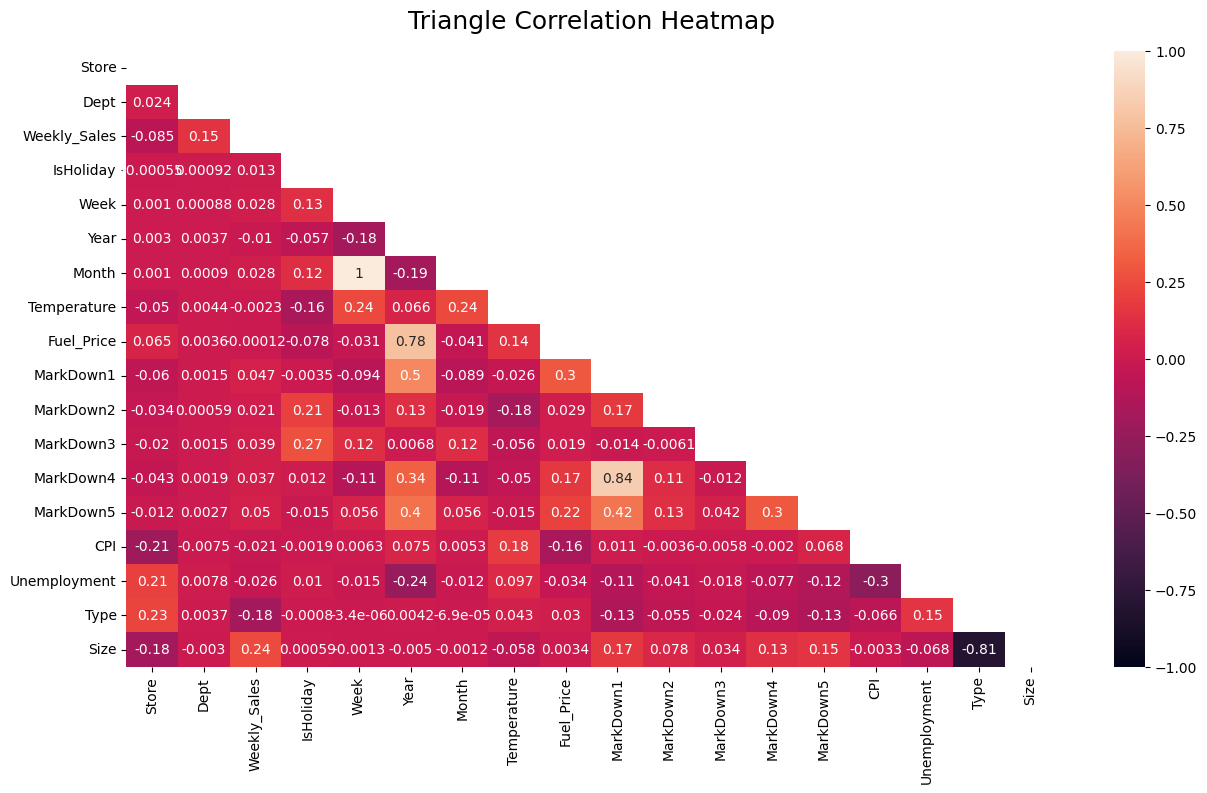

In [51]:
plt.figure(figsize=(15, 8))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(data_imputed.corr(), dtype=bool))
heatmap = sns.heatmap(data_imputed.corr(), mask=mask, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

Based on the heatmap, it appears that weekly sales have a strong correlation with store size, while other predictors have a relatively small impact on sales.

### 2.1. Sales by stores

In [52]:
# Calculate sum of weekly sales per store for 3 years
weekly_sales = (data_imputed.groupby(['Store'])['Weekly_Sales'].sum())/1000000
weekly_sales.map('{:,.2f}'.format)

Store
1     222.40
2     275.38
3      57.59
4     299.54
5      45.48
6     223.76
7      81.60
8     129.95
9      77.79
10    271.62
11    193.96
12    144.29
13    286.52
14    289.00
15     89.13
16     74.25
17    127.78
18    155.11
19    206.63
20    301.40
21    108.12
22    147.08
23    198.75
24    194.02
25    101.06
26    143.42
27    253.86
28    189.26
29     77.14
30     62.72
31    199.61
32    166.82
33     37.16
34    138.25
35    131.52
36     53.41
37     74.20
38     55.16
39    207.45
40    137.87
41    181.34
42     79.57
43     90.57
44     43.29
45    112.40
Name: Weekly_Sales, dtype: object

In [53]:
weekly_sales.idxmax()

20

Store has highest sales is 20th store.

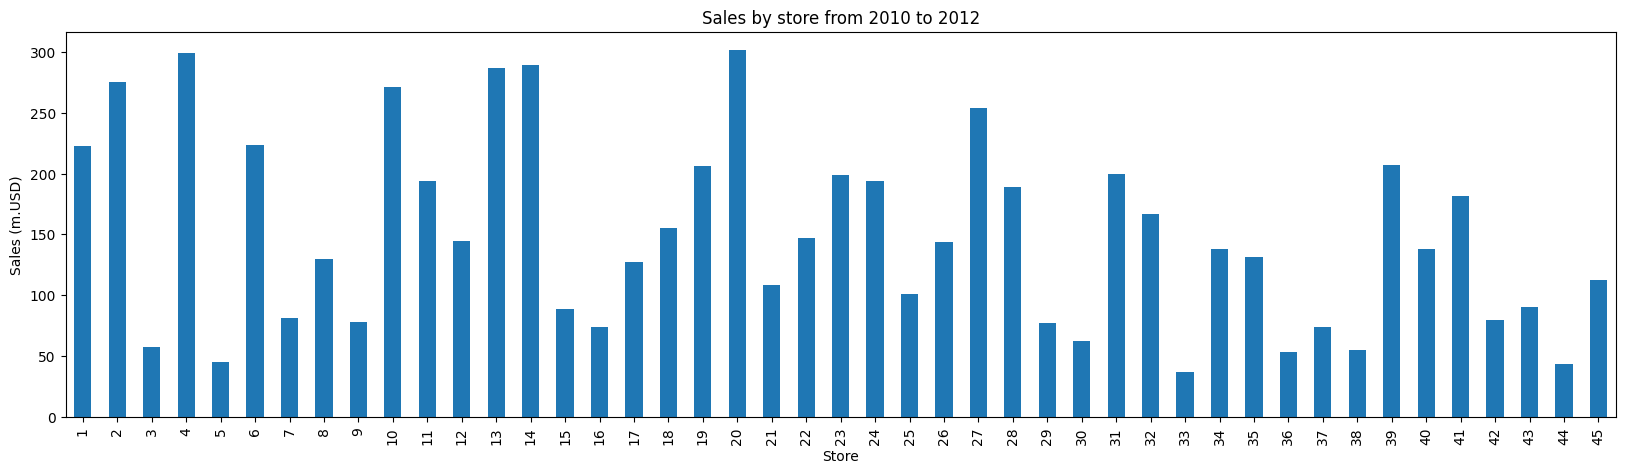

In [54]:
plt.figure(figsize=(20,5))
weekly_sales.plot(kind='bar')
plt.title('Sales by store from 2010 to 2012')
plt.ylabel('Sales (m.USD)');

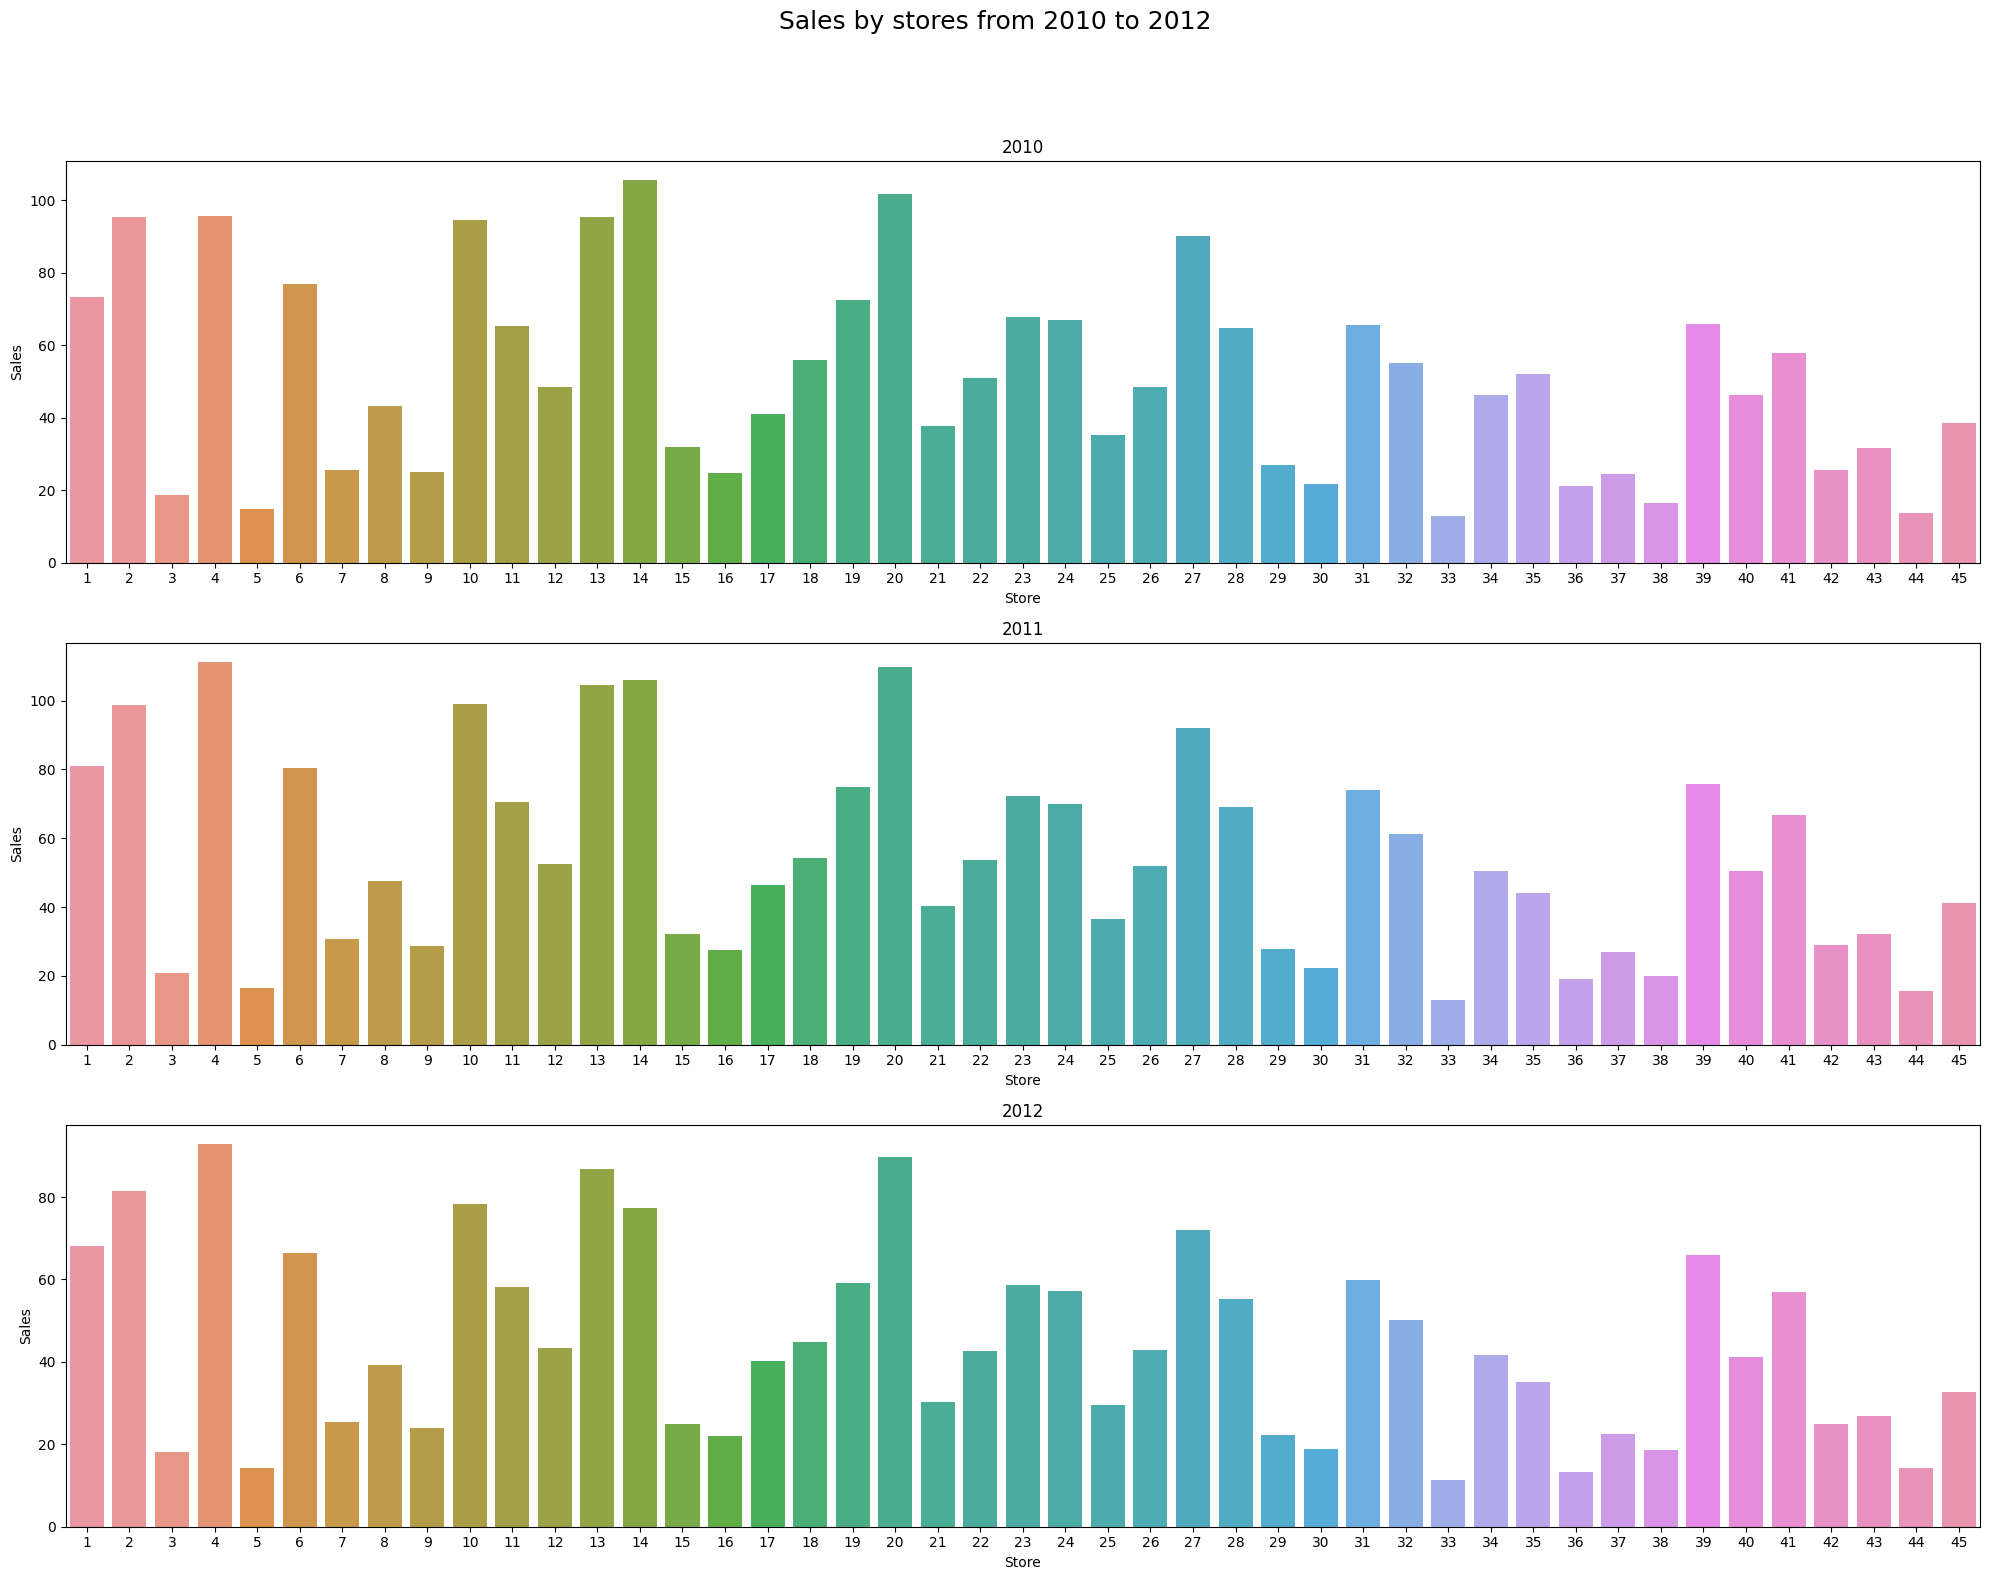

In [55]:
data_2010_store = (data_imputed.loc['2010'].groupby(['Store'])['Weekly_Sales'].sum())/1000000
data_2011_store = (data_imputed.loc['2011'].groupby(['Store'])['Weekly_Sales'].sum())/1000000
data_2012_store = (data_imputed.loc['2012'].groupby(['Store'])['Weekly_Sales'].sum())/1000000

fig,axes = plt.subplots(3,1,figsize=(20,15))

sns.barplot(ax=axes[0],x=data_2010_store.index,y=data_2010_store.values,label='2010')
sns.barplot(ax=axes[1],x=data_2011_store.index,y=data_2011_store.values,label='2011')
sns.barplot(ax=axes[2],x=data_2012_store.index,y=data_2012_store.values,label='2012')


axes[0].set_xlabel('Store')
axes[0].set_ylabel('Sales')
axes[0].set_title('2010')

axes[1].set_xlabel('Store')
axes[1].set_ylabel('Sales')
axes[1].set_title('2011')

axes[2].set_xlabel('Store')
axes[2].set_ylabel('Sales')
axes[2].set_title('2012')

fig.suptitle('Sales by stores from 2010 to 2012', fontsize=18, y=1.05)
plt.tight_layout()

plt.show()

In [56]:
print('2010 avg sales by store', data_2010_store.mean())
print('2011 avg sales by store',data_2011_store.mean())
print('2012 avg sales by store',data_2012_store.mean())

2010 avg sales by store 50.86413600911111
2011 avg sales by store 54.404444607777776
2012 avg sales by store 44.44739687444445


Average sales per store in 2010, 2011, and 2012 was 50 million USD, 54 million USD, and 44 millions USD (as of Oct-2012) respectively.


The performance of each store exhibits a consistent trend over a period of 3 years. The sales in 2011 showed a 7% increase compared to 2010. However, we cannot make any meaningful comparisons with 2012 as the data for that year is not complete.

### 2.2. Sales by week

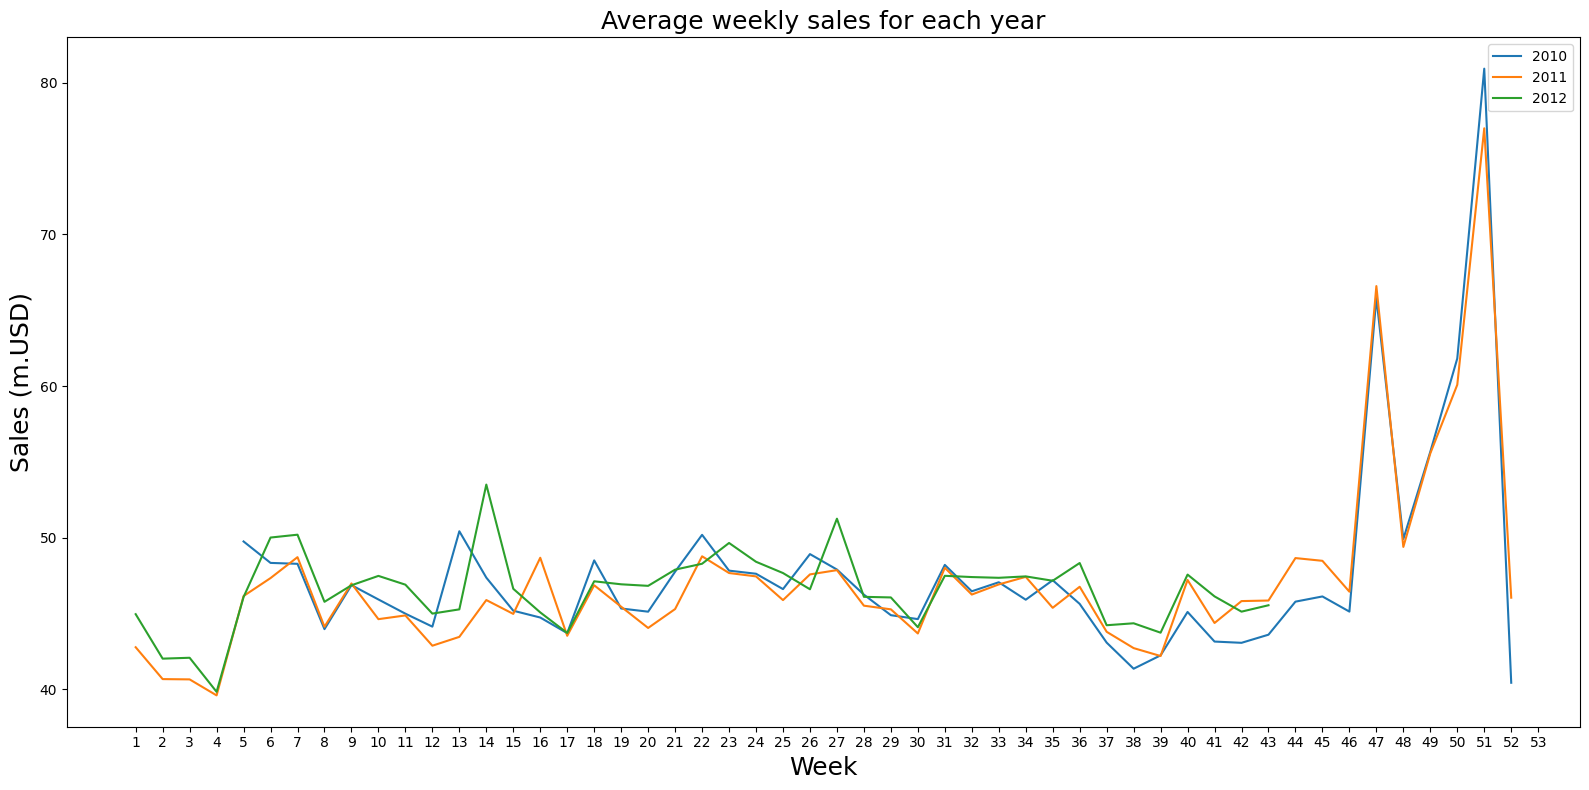

In [57]:
data_2010_week = (data_imputed.loc['2010'].groupby(['Week'])['Weekly_Sales'].sum())/1000000
data_2011_week = (data_imputed.loc['2011'].groupby(['Week'])['Weekly_Sales'].sum())/1000000
data_2012_week = (data_imputed.loc['2012'].groupby(['Week'])['Weekly_Sales'].sum())/1000000

plt.figure(figsize=(16,8))
sns.lineplot(x = data_2010_week.index, y = data_2010_week.values, label = '2010')
sns.lineplot(x = data_2011_week.index, y = data_2011_week.values, label = '2011')
sns.lineplot(x = data_2012_week.index, y = data_2012_week.values, label = '2012')
plt.title('Average weekly sales for each year', fontsize=18)
plt.xlabel('Week', fontsize=18)
plt.ylabel('Sales (m.USD)',fontsize=18)
plt.legend()
plt.xticks(range(1,54))
plt.tight_layout()
plt.show()

Upon initial observation, it appears that weekly sales over the course of three years exhibit similar patterns. However, upon closer examination, these patterns are mostly consistent with shifts in peak values occurring either earlier or later in the time period.

In [58]:
print('2010 avg sales per week', data_2010_week.mean())
print('2011 avg sales per week',data_2011_week.mean())
print('2012 avg sales by store',data_2012_week.mean())

2010 avg sales per week 47.68512750854166
2011 avg sales per week 47.080769372115384
2012 avg sales by store 46.51471765930233


The average sales per week in 2011 appears to be lower than in 2010 because the data for January was missing in 2010.

### 2.3. Sales by store types

In [59]:
# Calculate sum of weekly sales per store type for 3 years
(data1.groupby(['Type'])['Weekly_Sales'].sum()/1000000) 

Type
A    4331.014723
B    2000.700737
C     405.503528
Name: Weekly_Sales, dtype: float64

In [60]:
total_sum = (data1.groupby(['Type'])['Weekly_Sales'].sum()/1000000).sum()
percentage = (data1.groupby(['Type'])['Weekly_Sales'].sum()/1000000)/total_sum * 100
percentage

Type
A    64.284903
B    29.696240
C     6.018856
Name: Weekly_Sales, dtype: float64

Store type A accounts for approximately 64% of all Walmart sales, store type B makes up nearly 30%, and the remaining 6% is contributed by store type C. And this aligns with the fact that the bigger the store, the higher the sales.

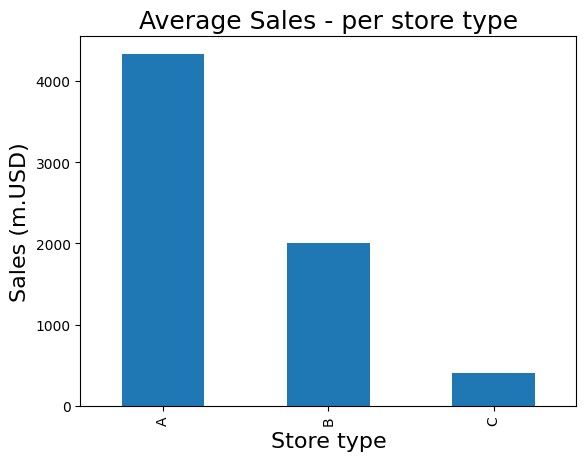

In [61]:
(data1.groupby(['Type'])['Weekly_Sales'].sum()/1000000).plot(kind='bar')
plt.title('Average Sales - per store type', fontsize=18)
plt.ylabel('Sales (m.USD)', fontsize=16)
plt.xlabel('Store type', fontsize=16)
plt.show();

In [62]:
data_2010_type = (data1.loc['2010'].groupby(['Type'])['Weekly_Sales'].sum())/1000000
data_2011_type = (data1.loc['2011'].groupby(['Type'])['Weekly_Sales'].sum())/1000000
data_2012_type = (data1.loc['2012'].groupby(['Type'])['Weekly_Sales'].sum())/1000000
data_2010_type

Type
A    1465.430418
B     689.977736
C     133.477966
Name: Weekly_Sales, dtype: float64

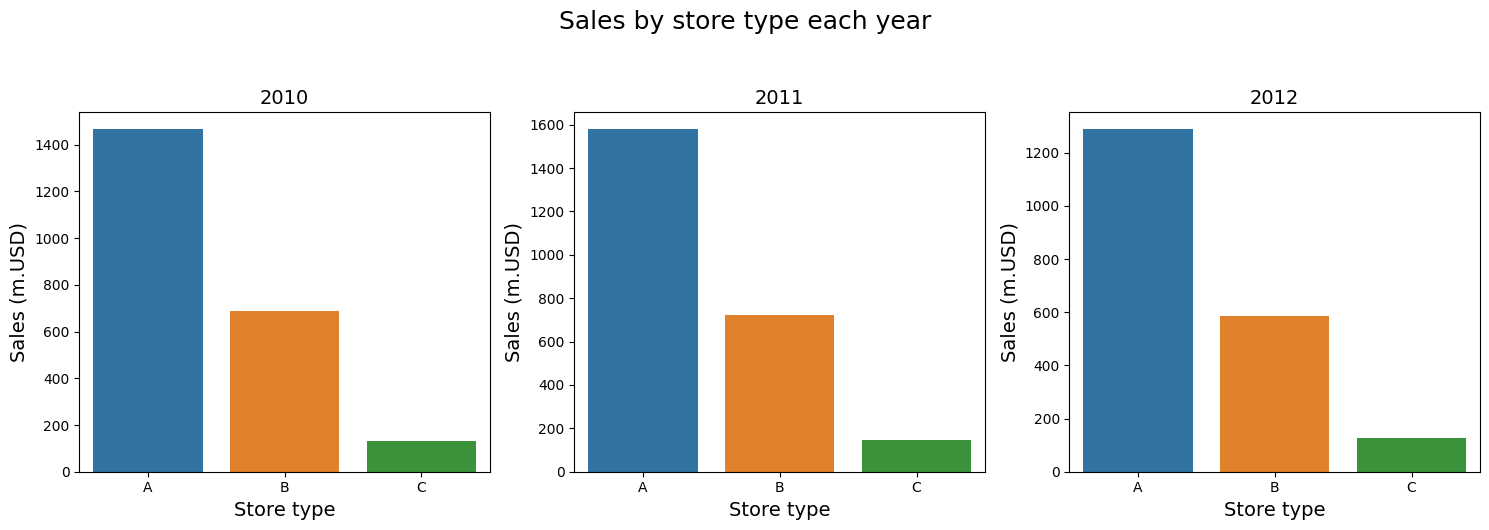

In [63]:
fig,axes = plt.subplots(1,3,figsize=(15,5))

sns.barplot(ax=axes[0],x=data_2010_type.index,y=data_2010_type.values,label='2010')
sns.barplot(ax=axes[1],x=data_2011_type.index,y=data_2011_type.values,label='2011')
sns.barplot(ax=axes[2],x=data_2012_type.index,y=data_2012_type.values,label='2012')

axes[0].set_title('2010',fontsize=14)
axes[0].set_ylabel('Sales (m.USD)',fontsize=14)
axes[0].set_xlabel('Store type',fontsize=14)

axes[1].set_ylabel('Sales (m.USD)',fontsize=14)
axes[1].set_xlabel('Store type',fontsize=14)
axes[1].set_title('2011',fontsize=14)

axes[2].set_ylabel('Sales (m.USD)',fontsize=14)
axes[2].set_xlabel('Store type',fontsize=14)
axes[2].set_title('2012',fontsize=14)

fig.suptitle('Sales by store type each year', fontsize=18, y=1.05)
plt.tight_layout()
plt.show()

Sales contribution of each store type looks similar over 3-year period.

### 2.4. Sales by dept

In [64]:
# Calculate sum of weekly sales per dept for 3 years
dept_sales = (data_imputed.groupby(['Dept'])['Weekly_Sales'].sum()/1000000)

In [65]:
dept_sales.sort_values(ascending=False)

Dept
92    483.943342
95    449.320163
38    393.118137
72    305.725152
90    291.068464
         ...    
51      0.030573
78      0.001715
39      0.000178
43      0.000014
47     -0.004963
Name: Weekly_Sales, Length: 81, dtype: float64

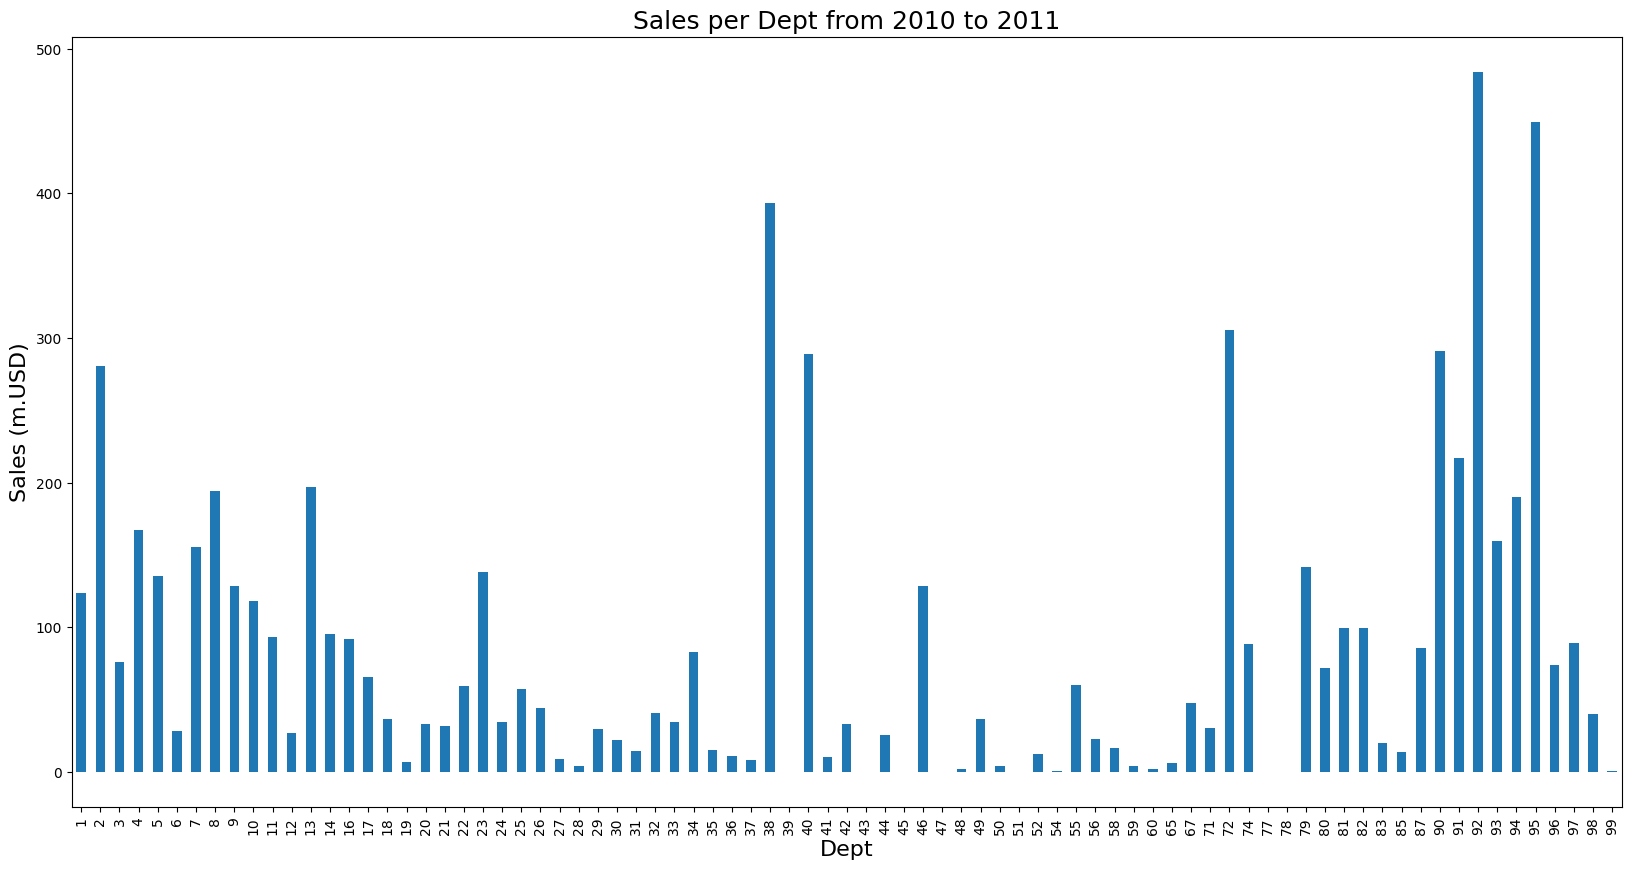

In [66]:
plt.figure(figsize=(20,10))
dept_sales.plot(kind='bar')
plt.title('Sales per Dept from 2010 to 2011', fontsize=18)
plt.ylabel('Sales (m.USD)', fontsize=16)
plt.xlabel('Dept', fontsize=16)
plt.show();

In [67]:
max_dept = dept_sales.idxmax()
max_dept

92

The biggest department is department 92, and the top 5 biggest departments also include department numbers 95, 38, 72, and 90.

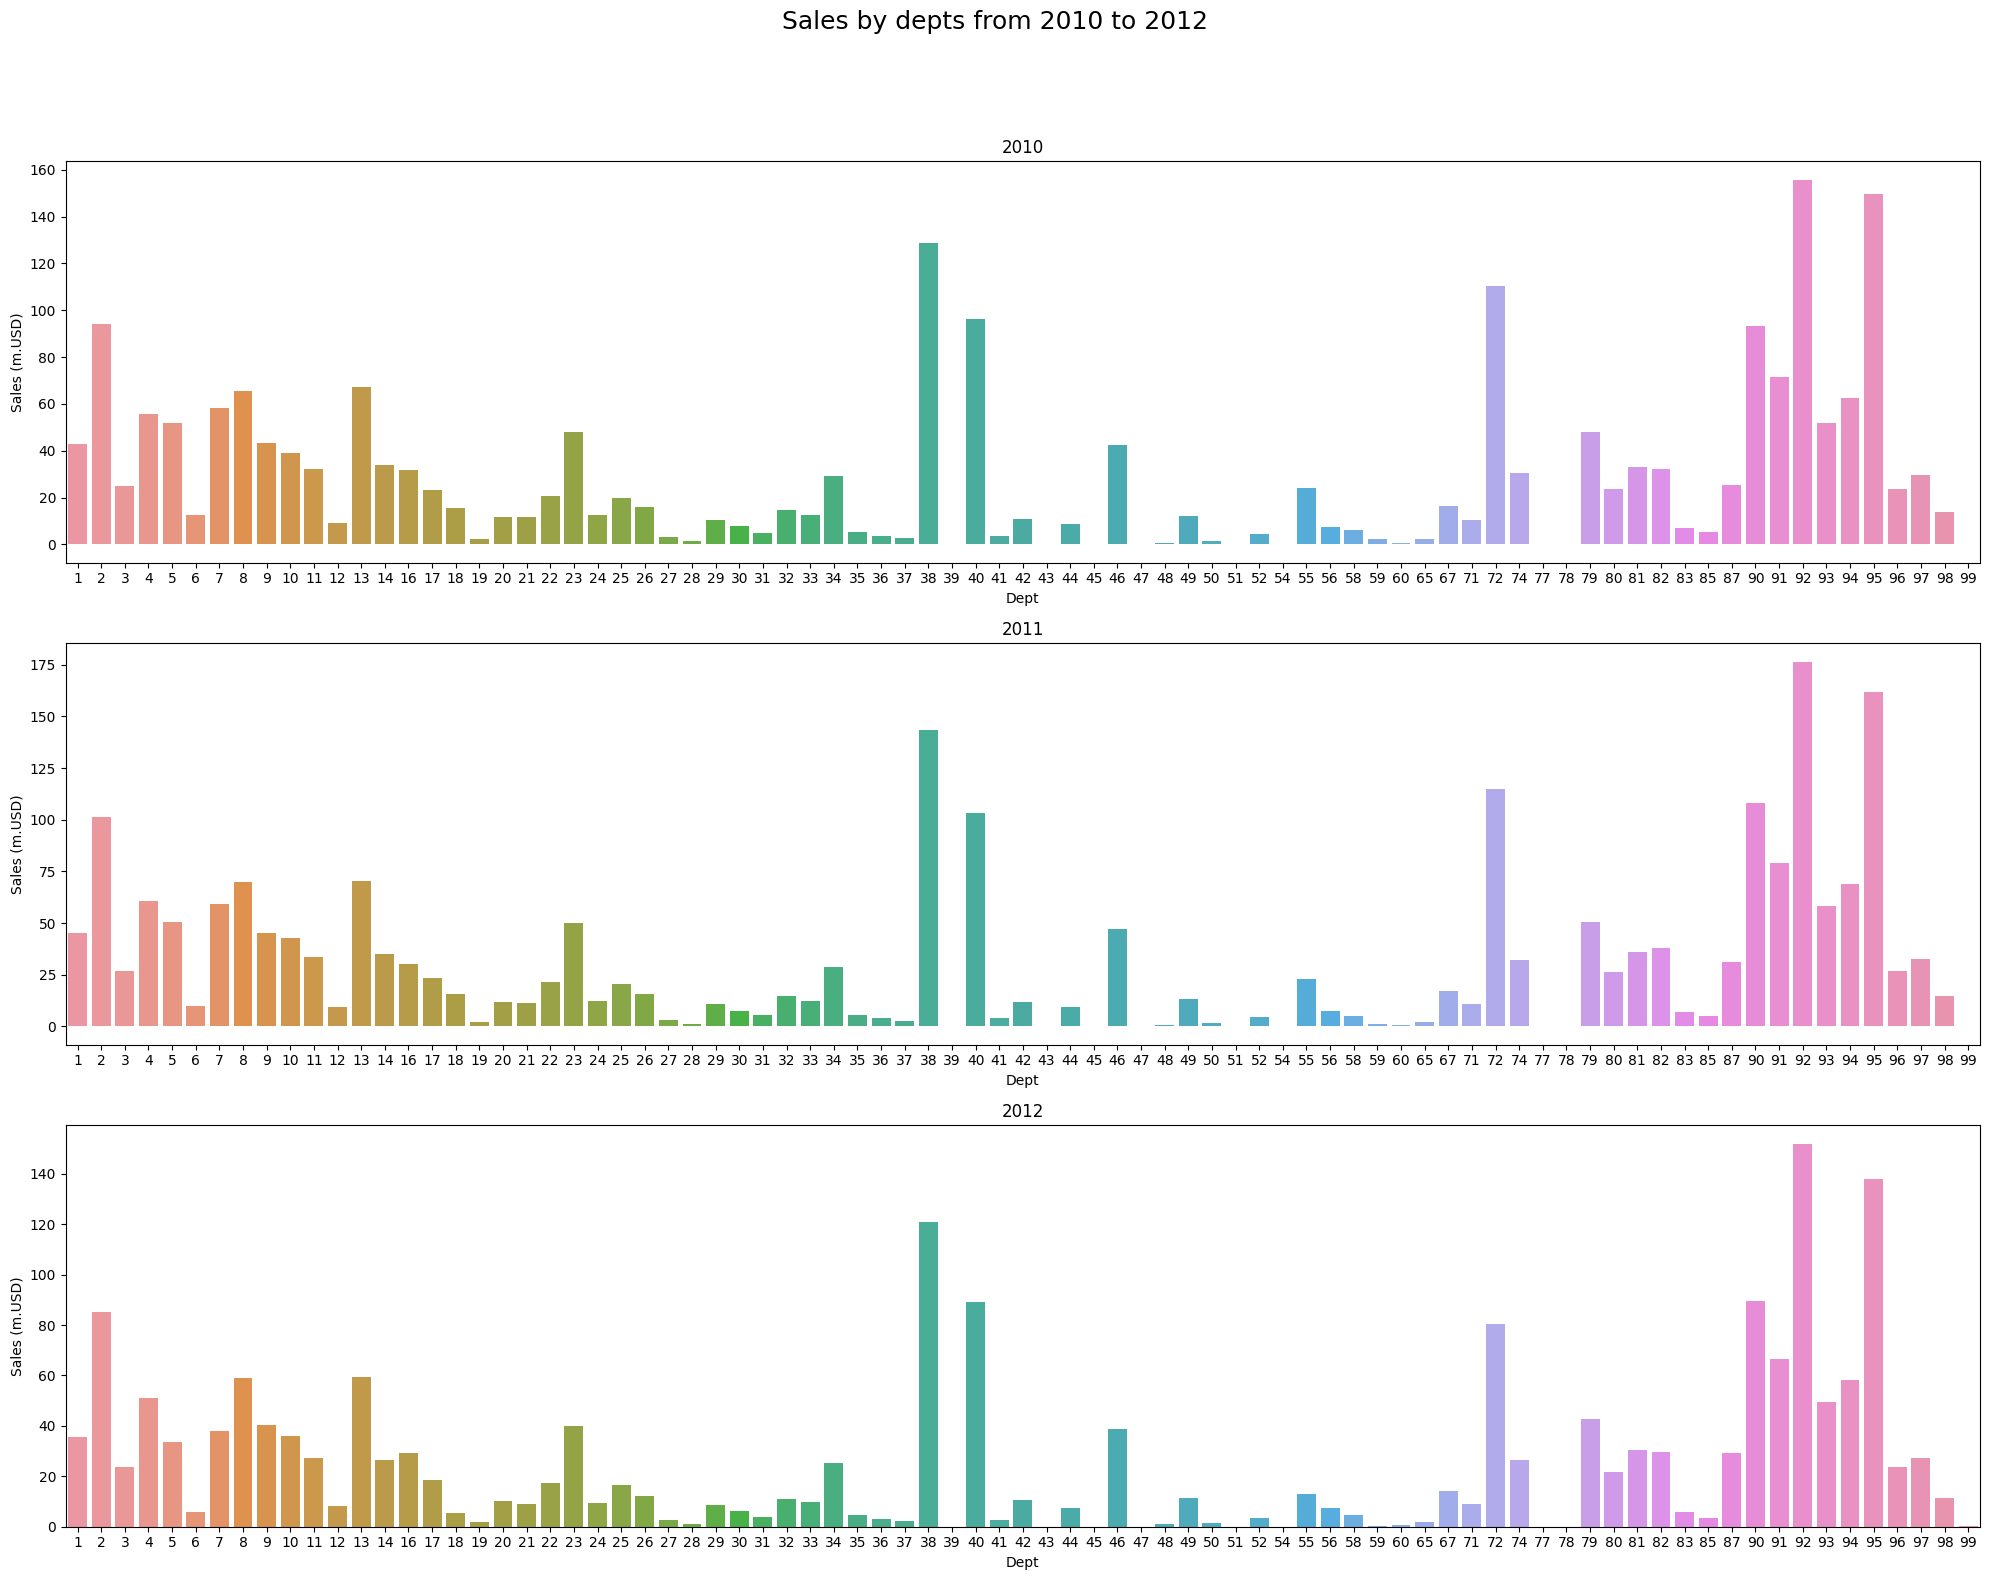

In [68]:
data_2010_dept = (data_imputed.loc['2010'].groupby(['Dept'])['Weekly_Sales'].sum())/1000000
data_2011_dept = (data_imputed.loc['2011'].groupby(['Dept'])['Weekly_Sales'].sum())/1000000
data_2012_dept = (data_imputed.loc['2012'].groupby(['Dept'])['Weekly_Sales'].sum())/1000000

fig,axes = plt.subplots(3,1,figsize=(20,15))

sns.barplot(ax=axes[0],x=data_2010_dept.index,y=data_2010_dept.values,label='2010')
sns.barplot(ax=axes[1],x=data_2011_dept.index,y=data_2011_dept.values,label='2011')
sns.barplot(ax=axes[2],x=data_2012_dept.index,y=data_2012_dept.values,label='2012')

axes[0].set_ylabel('Sales (m.USD)')
axes[0].set_xlabel('Dept')
axes[0].set_title('2010')

axes[1].set_ylabel('Sales (m.USD)')
axes[1].set_xlabel('Dept')
axes[1].set_title('2011')

axes[2].set_ylabel('Sales (m.USD)')
axes[2].set_xlabel('Dept')
axes[2].set_title('2012')

fig.suptitle('Sales by depts from 2010 to 2012', fontsize=18, y=1.05)
plt.tight_layout()

plt.show()

Sales by departments follows the same trend over 3 years.

### 2.5. Sales by holidays

According to the given data, each year, the company went throught 4 big holidays as refecting 4 weeks below.

In [69]:
Holiday_list = data_imputed[data_imputed.IsHoliday==True].index.unique()
Holiday_list

DatetimeIndex(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
               '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
               '2012-02-10', '2012-09-07'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [70]:
data_imputed_reset_index = data_imputed.reset_index()
data_imputed_reset_index.head()

Date  Store  Dept  Weekly_Sales  IsHoliday  Week  Year  Month  \
0 2010-02-05      1     1      24924.50          0     5  2010      2   
1 2010-02-12      1     1      46039.49          1     6  2010      2   
2 2010-02-19      1     1      41595.55          0     7  2010      2   
3 2010-02-26      1     1      19403.54          0     8  2010      2   
4 2010-03-05      1     1      21827.90          0     9  2010      3   

   Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  \
0        42.31       2.572        0.0        0.0        0.0        0.0   
1        38.51       2.548        0.0        0.0        0.0        0.0   
2        39.93       2.514        0.0        0.0        0.0        0.0   
3        46.63       2.561        0.0        0.0        0.0        0.0   
4        46.50       2.625        0.0        0.0        0.0        0.0   

   MarkDown5         CPI  Unemployment  Type    Size  
0        0.0  211.096358         8.106     1  151315  
1        0.0  211.242170         8.106     1  151315  
2        0.0  211.289143         8.106     1  151315  
3        0.0  211.319643         8.106     1  151315  
4        0.0  211.350143         8.106     1  151315

In [71]:
data_imputed_reset_index.groupby(['Date','Store','IsHoliday','Type'])['Weekly_Sales'].sum()

Date        Store  IsHoliday  Type
2010-02-05  1      0          1       1643690.90
            2      0          1       2136989.46
            3      0          2        461622.22
            4      0          1       2135143.87
            5      0          2        317173.10
                                         ...    
2012-10-26  41     0          1       1316542.59
            42     0          3        514756.08
            43     0          3        587603.55
            44     0          3        361067.07
            45     0          2        760281.43
Name: Weekly_Sales, Length: 6435, dtype: float64

In [72]:
Weekly_Sales_byweek = pd.DataFrame(data_imputed_reset_index.groupby(['Date','Store','IsHoliday','Type'])['Weekly_Sales'].sum())
Weekly_Sales_byweek

Weekly_Sales
Date       Store IsHoliday Type              
2010-02-05 1     0         1       1643690.90
           2     0         1       2136989.46
           3     0         2        461622.22
           4     0         1       2135143.87
           5     0         2        317173.10
...                                       ...
2012-10-26 41    0         1       1316542.59
           42    0         3        514756.08
           43    0         3        587603.55
           44    0         3        361067.07
           45    0         2        760281.43

[6435 rows x 1 columns]

In [73]:
Weekly_Sales_byweek.reset_index()

Date  Store  IsHoliday  Type  Weekly_Sales
0    2010-02-05      1          0     1    1643690.90
1    2010-02-05      2          0     1    2136989.46
2    2010-02-05      3          0     2     461622.22
3    2010-02-05      4          0     1    2135143.87
4    2010-02-05      5          0     2     317173.10
...         ...    ...        ...   ...           ...
6430 2012-10-26     41          0     1    1316542.59
6431 2012-10-26     42          0     3     514756.08
6432 2012-10-26     43          0     3     587603.55
6433 2012-10-26     44          0     3     361067.07
6434 2012-10-26     45          0     2     760281.43

[6435 rows x 5 columns]

In [74]:
Weekly_Sales_byweek['Weekly_Sales'].mean()

1046964.8775617715

In [75]:
Weekly_Sales_byweek.groupby(['IsHoliday','Store','Date'])['Weekly_Sales'].mean()

IsHoliday  Store  Date      
0          1      2010-02-05    1643690.90
                  2010-02-19    1611968.17
                  2010-02-26    1409727.59
                  2010-03-05    1554806.68
                  2010-03-12    1439541.59
                                   ...    
1          45     2011-09-09     746129.56
                  2011-11-25    1170672.94
                  2011-12-30     869403.63
                  2012-02-10     803657.12
                  2012-09-07     766512.66
Name: Weekly_Sales, Length: 6435, dtype: float64

In [76]:
#Average weekly sales per store (all deppartments) in normal week:
Avg_wsale_normweek = Weekly_Sales_byweek.groupby(['IsHoliday','Store','Date'])['Weekly_Sales'].mean()[0].mean()
Avg_wsale_normweek

1041256.3802088555

In [77]:
#Average weekly sales per store (all deppartments) in holiday week:
Avg_wsale_holiweek = Weekly_Sales_byweek.groupby(['IsHoliday','Store','Date'])['Weekly_Sales'].mean()[1].mean()
Avg_wsale_holiweek

1122887.8923555557

In [78]:
Avg_wsale_holiweek/Avg_wsale_normweek

1.0783971303305018

Averagely sales in holiday week was around 8% higher than sales from normal week.

### 2.6. Markdowns

For the analysis of markdown data, we will focus on the period starting from November 2011 onwards, as the data before that is not available.

In [79]:
data_imputed['MarkDown1'].sum()

1091897841.5400002

In [80]:
data_imputed = data_imputed.sort_index()
data_imputed_fromNov11 = data_imputed.loc['2011-11':'2012-10']
data_imputed_fromNov11.head()

Store  Dept  Weekly_Sales  IsHoliday  Week  Year  Month  \
Date                                                                  
2011-11-04     34    92      74365.53          0    44  2011     11   
2011-11-04      6    14      21252.80          0    44  2011     11   
2011-11-04     40    40      33823.56          0    44  2011     11   
2011-11-04      3    79       6844.26          0    44  2011     11   
2011-11-04     29    91       4736.41          0    44  2011     11   

            Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  \
Date                                                                   
2011-11-04        48.04       3.322        0.0        0.0        0.0   
2011-11-04        58.54       3.332        0.0        0.0        0.0   
2011-11-04        35.40       3.586        0.0        0.0        0.0   
2011-11-04        59.31       3.332        0.0        0.0        0.0   
2011-11-04        42.81       3.586        0.0        0.0        0.0   

            MarkDown4  MarkDown5         CPI  Unemployment  Type    Size  
Date                                                                      
2011-11-04        0.0        0.0  129.805194        10.148     1  158114  
2011-11-04        0.0        0.0  219.400081         6.551     1  202505  
2011-11-04        0.0        0.0  136.475129         4.420     1  155083  
2011-11-04        0.0        0.0  221.245968         7.197     2   37392  
2011-11-04        0.0        0.0  136.475129         9.357     2   93638

In [81]:
data_imputed_fromNov11.reset_index().head()

Date  Store  Dept  Weekly_Sales  IsHoliday  Week  Year  Month  \
0 2011-11-04     34    92      74365.53          0    44  2011     11   
1 2011-11-04      6    14      21252.80          0    44  2011     11   
2 2011-11-04     40    40      33823.56          0    44  2011     11   
3 2011-11-04      3    79       6844.26          0    44  2011     11   
4 2011-11-04     29    91       4736.41          0    44  2011     11   

   Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  \
0        48.04       3.322        0.0        0.0        0.0        0.0   
1        58.54       3.332        0.0        0.0        0.0        0.0   
2        35.40       3.586        0.0        0.0        0.0        0.0   
3        59.31       3.332        0.0        0.0        0.0        0.0   
4        42.81       3.586        0.0        0.0        0.0        0.0   

   MarkDown5         CPI  Unemployment  Type    Size  
0        0.0  129.805194        10.148     1  158114  
1        0.0  219.400081         6.551     1  202505  
2        0.0  136.475129         4.420     1  155083  
3        0.0  221.245968         7.197     2   37392  
4        0.0  136.475129         9.357     2   93638

In [85]:
data_imputed

Store  Dept  Weekly_Sales  IsHoliday  Week  Year  Month  \
Date                                                                  
2010-02-05      1     1      24924.50          0     5  2010      2   
2010-02-05     29     5      15552.08          0     5  2010      2   
2010-02-05     29     6       3200.22          0     5  2010      2   
2010-02-05     29     7      10820.05          0     5  2010      2   
2010-02-05     29     8      20055.64          0     5  2010      2   
...           ...   ...           ...        ...   ...   ...    ...   
2012-10-26     40    87      24638.96          0    43  2012     10   
2012-10-26     19    30       3740.12          0    43  2012     10   
2012-10-26     19    31       3128.17          0    43  2012     10   
2012-10-26     19    33       5740.14          0    43  2012     10   
2012-10-26     45    98       1076.80          0    43  2012     10   

            Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  \
Date                                                                   
2010-02-05        42.31       2.572       0.00       0.00       0.00   
2010-02-05        24.36       2.788       0.00       0.00       0.00   
2010-02-05        24.36       2.788       0.00       0.00       0.00   
2010-02-05        24.36       2.788       0.00       0.00       0.00   
2010-02-05        24.36       2.788       0.00       0.00       0.00   
...                 ...         ...        ...        ...        ...   
2012-10-26        49.65       3.917    3605.71      55.98       0.28   
2012-10-26        56.49       4.071    5430.75      90.07       0.00   
2012-10-26        56.49       4.071    5430.75      90.07       0.00   
2012-10-26        56.49       4.071    5430.75      90.07       0.00   
2012-10-26        58.85       3.882    4018.91      58.08     100.00   

            MarkDown4  MarkDown5         CPI  Unemployment  Type    Size  
Date                                                                      
2010-02-05       0.00       0.00  211.096358         8.106     1  151315  
2010-02-05       0.00       0.00  131.527903        10.064     2   93638  
2010-02-05       0.00       0.00  131.527903        10.064     2   93638  
2010-02-05       0.00       0.00  131.527903        10.064     2   93638  
2010-02-05       0.00       0.00  131.527903        10.064     2   93638  
...               ...        ...         ...           ...   ...     ...  
2012-10-26     486.81    1389.06  138.728161         4.145     1  155083  
2012-10-26     904.34    1665.77  138.728161         7.992     1  203819  
2012-10-26     904.34    1665.77  138.728161         7.992     1  203819  
2012-10-26     904.34    1665.77  138.728161         7.992     1  203819  
2012-10-26     211.94     858.33  192.308899         8.667     2  118221  

[421570 rows x 18 columns]

In [99]:
store_grouping1 = data_imputed_fromNov11.reset_index()[['Date','Store','Weekly_Sales','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']]
store_grouping2 = store_grouping1.groupby(['Date','Store'])[['Weekly_Sales','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].sum()
store_grouping2.head()

Weekly_Sales  MarkDown1  MarkDown2  MarkDown3  MarkDown4  \
Date       Store                                                             
2011-11-04 1        1697229.58        0.0        0.0        0.0        0.0   
           2        1959707.90        0.0        0.0        0.0        0.0   
           3         459443.22        0.0        0.0        0.0        0.0   
           4        2281217.31        0.0        0.0        0.0        0.0   
           5         353652.23        0.0        0.0        0.0        0.0   

                  MarkDown5  
Date       Store             
2011-11-04 1            0.0  
           2            0.0  
           3            0.0  
           4            0.0  
           5            0.0

In [101]:
store_grouping3 = store_grouping2.groupby('Date')[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','Weekly_Sales']].mean()
store_grouping3.head()

MarkDown1      MarkDown2     MarkDown3      MarkDown4  \
Date                                                                    
2011-11-04       0.000000       0.000000  0.000000e+00       0.000000   
2011-11-11  754141.196000  635951.412222  2.062427e+04  239084.808444   
2011-11-18  415660.164889   44679.818000  7.121721e+03   47755.836222   
2011-11-25   38778.163778   11735.234667  3.817548e+06    3898.158444   
2011-12-02  303557.530889    5132.584889  2.388296e+05  180185.808889   

               MarkDown5  Weekly_Sales  
Date                                    
2011-11-04  0.000000e+00  1.081234e+06  
2011-11-11  3.262956e+05  1.077205e+06  
2011-11-18  3.885416e+05  1.031977e+06  
2011-11-25  1.278206e+05  1.479858e+06  
2011-12-02  1.243060e+06  1.097568e+06

In [102]:
store_grouping3.mean().apply(lambda x: "{:,.0f}".format(x))

MarkDown1         466,623
MarkDown2         158,535
MarkDown3          84,330
MarkDown4         195,135
MarkDown5         299,562
Weekly_Sales    1,067,681
dtype: object

In [103]:
store_grouping3['Weekly_Sales'].mean()

1067680.9045726494

In [104]:
store_grouping3[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].mean()

MarkDown1    466623.009205
MarkDown2    158534.514889
MarkDown3     84329.793581
MarkDown4    195135.072658
MarkDown5    299561.946235
dtype: float64

In [105]:
## Markdown in percentage comparing with sales:
store_grouping3[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].mean()/store_grouping3['Weekly_Sales'].mean()

MarkDown1    0.437044
MarkDown2    0.148485
MarkDown3    0.078984
MarkDown4    0.182765
MarkDown5    0.280573
dtype: float64

When comparing the average weekly markdowns to the average weekly sales, Markdown 1 stands out as the largest type, which was equivalent to nearly 44% of the sales. Markdown 5 follows closely behind, representing approximately 28% of the sales. Markdown 4 was around 18% of the sales, while Markdowns 2 and 3 was 14% and 8% to the sales, respectively.

Below chart shows average weekly sales comparing with average weekly markdowns per store.

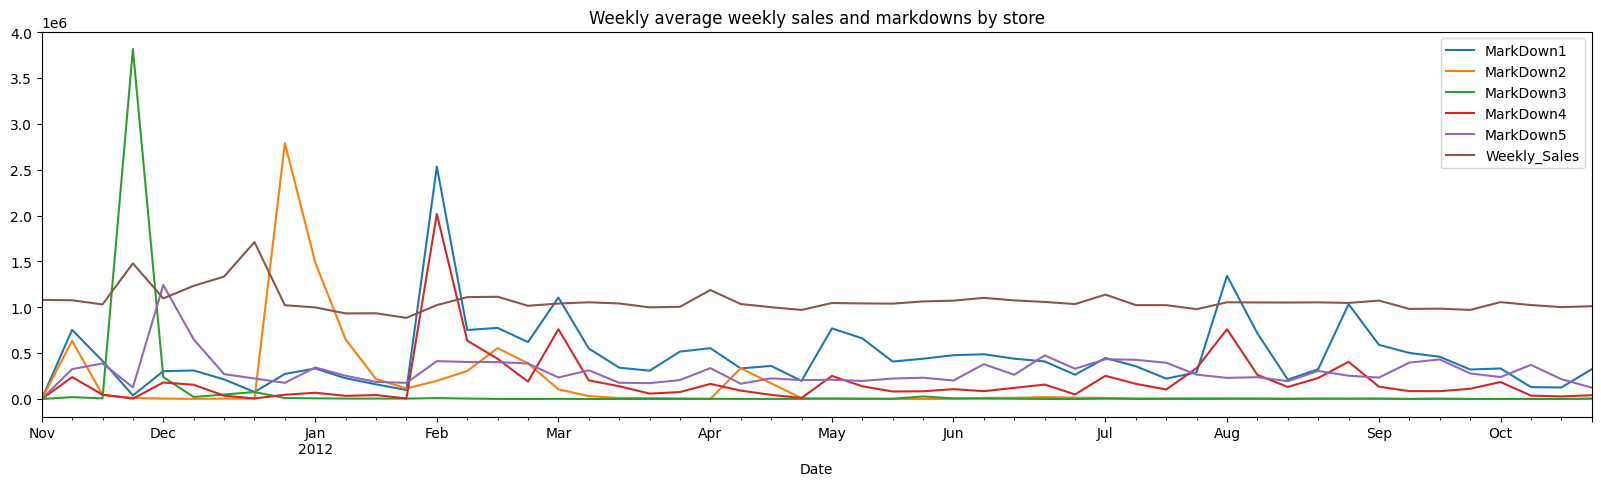

In [106]:
store_grouping3.plot(figsize=(20,5))
plt.title('Weekly average weekly sales and markdowns by store');

The weekly average sales per store is approximately 1 million USD, with the highest peaks occurring during the Christmas holiday season. Surprisingly, several types of markdowns were significantly higher than the sales, particularly during holidays.

In [107]:
# Average weekly sales vs average weekly markdown per store type A
store_filtered_typeA = store_grouping[store_grouping.index.get_level_values('Type') == 1]
store_filtered_typeA.mean().apply(lambda x: "{:,.0f}".format(x))

Weekly_Sales    1,403,811
MarkDown1         584,353
MarkDown2         204,029
MarkDown3         103,528
MarkDown4         249,738
MarkDown5         404,554
dtype: object

In [108]:
# Comparing average weekly markdown vs average weekly sales per store type A, in percentage:
(store_filtered_typeA.mean()/store_filtered_typeA.mean().astype(float)[0])[1:6]

MarkDown1    0.416262
MarkDown2    0.145339
MarkDown3    0.073748
MarkDown4    0.177900
MarkDown5    0.288183
dtype: float64

In [109]:
# Average weekly sales vs average weekly markdown per store type B
store_filtered_typeB = store_grouping[store_grouping.index.get_level_values('Type') == 2]
store_filtered_typeB.mean().apply(lambda x: "{:,.0f}".format(x))

Weekly_Sales    837,592
MarkDown1       472,261
MarkDown2       153,045
MarkDown3        89,000
MarkDown4       193,073
MarkDown5       245,043
dtype: object

In [110]:
# Comparing average weekly markdown vs average weekly sales per store type B, in percentage:
(store_filtered_typeB.mean()/store_filtered_typeB.mean().astype(float)[0])[1:6]

MarkDown1    0.563832
MarkDown2    0.182721
MarkDown3    0.106257
MarkDown4    0.230510
MarkDown5    0.292557
dtype: float64

In [111]:
type((data_filtered_typeB.mean()/data_filtered_typeB.mean().astype(float)[0])[1:6])

NameError: name 'data_filtered_typeB' is not defined

In [112]:
# Average weekly sales vs average weekly markdown per store type C
store_filtered_typeC = store_grouping[store_grouping.index.get_level_values('Type') == 3]
store_filtered_typeB.mean().apply(lambda x: "{:,.0f}".format(x))

Weekly_Sales    837,592
MarkDown1       472,261
MarkDown2       153,045
MarkDown3        89,000
MarkDown4       193,073
MarkDown5       245,043
dtype: object

In [113]:
# Comparing average weekly markdown vs average weekly sales per store type C, in percentage:
(store_filtered_typeC.mean()/store_filtered_typeC.mean().astype(float)[0])[1:6]

MarkDown1    0.038947
MarkDown2    0.014932
MarkDown3    0.001441
MarkDown4    0.001571
MarkDown5    0.141771
dtype: float64

In [114]:
store_series_typeA = pd.Series((store_filtered_typeA.mean()/store_filtered_typeA.mean().astype(float)[0])[1:6],index=['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])
store_series_typeB = pd.Series((store_filtered_typeB.mean()/store_filtered_typeB.mean().astype(float)[0])[1:6],index=['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])
store_series_typeC = pd.Series((store_filtered_typeC.mean()/store_filtered_typeC.mean().astype(float)[0])[1:6],index=['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])

store_combined_series = pd.concat([store_series_typeA, store_series_typeB,store_series_typeC], axis=1)
store_combined_series.columns = ["Type_A", "Type_B",'Type_C']
store_combined_series

Type_A    Type_B    Type_C
MarkDown1  0.416262  0.563832  0.038947
MarkDown2  0.145339  0.182721  0.014932
MarkDown3  0.073748  0.106257  0.001441
MarkDown4  0.177900  0.230510  0.001571
MarkDown5  0.288183  0.292557  0.141771

In [115]:
list(store_combined_series.index)

['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

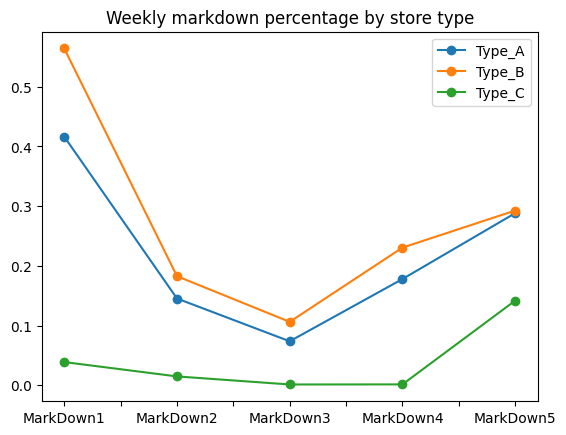

In [117]:
store_combined_series.plot(marker='o')
# plt.xticks(range(len(combined_series.index)), combined_series.index.tolist())
plt.title('Weekly markdown percentage by store type')
plt.show()


Analyzing average weekly sales with average weekly markdowns by store type, we can see that in different store type, markdown type percentage are diffent as wel. All type of markdowns were highest in store type B stores. And in store type C, markdown 5 is the highest one, not markdown 1.

In [118]:
dept_grouping = data_imputed_fromNov11.groupby(['Date','Store','Dept'])[['Weekly_Sales','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].sum()
dept_grouping.head()

Weekly_Sales  MarkDown1  MarkDown2  MarkDown3  \
Date       Store Dept                                                  
2011-11-04 1     1         39886.06        0.0        0.0        0.0   
                 2         47313.62        0.0        0.0        0.0   
                 3          9189.20        0.0        0.0        0.0   
                 4         39354.84        0.0        0.0        0.0   
                 5         31956.07        0.0        0.0        0.0   

                       MarkDown4  MarkDown5  
Date       Store Dept                        
2011-11-04 1     1           0.0        0.0  
                 2           0.0        0.0  
                 3           0.0        0.0  
                 4           0.0        0.0  
                 5           0.0        0.0

In [119]:
dept_grouping.describe()

Weekly_Sales      MarkDown1      MarkDown2      MarkDown3  \
count  154386.000000  154386.000000  154386.000000  154386.000000   
mean    16182.641669    7072.518503    2402.878272    1278.171058   
std     23232.252997    8265.865033    8181.347425    9079.416727   
min     -1699.000000       0.000000    -265.760000     -29.100000   
25%      2001.050000    1986.920000       0.000000       2.770000   
50%      7540.340000    5185.450000      63.200000      16.620000   
75%     20426.185000    9082.610000     599.500000      89.440000   
max    649770.180000   88646.760000  104519.540000  141630.610000   

           MarkDown4      MarkDown5  
count  154386.000000  154386.000000  
mean     2957.626145    4540.404921  
std      5989.360342    5939.515584  
min         0.000000       0.000000  
25%       226.970000    1790.310000  
50%      1123.900000    3293.290000  
75%      3108.550000    5518.290000  
max     67474.850000  108519.280000

Above table shows some figures of average weekly sales and markdowns per dept per store.

In [120]:
dept_grouping1 = dept_grouping.groupby(['Date','Dept'])[['Weekly_Sales','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].mean()
dept_grouping1.head()

Weekly_Sales  MarkDown1  MarkDown2  MarkDown3  MarkDown4  \
Date       Dept                                                             
2011-11-04 1     36959.708667        0.0        0.0        0.0        0.0   
           2     42245.280444        0.0        0.0        0.0        0.0   
           3      7374.878889        0.0        0.0        0.0        0.0   
           4     26840.661111        0.0        0.0        0.0        0.0   
           5     23312.396667        0.0        0.0        0.0        0.0   

                 MarkDown5  
Date       Dept             
2011-11-04 1           0.0  
           2           0.0  
           3           0.0  
           4           0.0  
           5           0.0

In [121]:
dept_grouping1.reset_index().head()

Date  Dept  Weekly_Sales  MarkDown1  MarkDown2  MarkDown3  MarkDown4  \
0 2011-11-04     1  36959.708667        0.0        0.0        0.0        0.0   
1 2011-11-04     2  42245.280444        0.0        0.0        0.0        0.0   
2 2011-11-04     3   7374.878889        0.0        0.0        0.0        0.0   
3 2011-11-04     4  26840.661111        0.0        0.0        0.0        0.0   
4 2011-11-04     5  23312.396667        0.0        0.0        0.0        0.0   

   MarkDown5  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0

In [122]:
dept_grouping2 = (dept_grouping1.reset_index())
dept_grouping2.head()

Date  Dept  Weekly_Sales  MarkDown1  MarkDown2  MarkDown3  MarkDown4  \
0 2011-11-04     1  36959.708667        0.0        0.0        0.0        0.0   
1 2011-11-04     2  42245.280444        0.0        0.0        0.0        0.0   
2 2011-11-04     3   7374.878889        0.0        0.0        0.0        0.0   
3 2011-11-04     4  26840.661111        0.0        0.0        0.0        0.0   
4 2011-11-04     5  23312.396667        0.0        0.0        0.0        0.0   

   MarkDown5  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0

In [123]:
dept_markdown1 = dept_grouping2[['Date','Dept','MarkDown1']]
#Turn 'Dept' into columns
pivot_dept_markdown1 = dept_markdown1.pivot(index='Date', columns='Dept', values='MarkDown1')
pivot_dept_markdown1.head()

Dept                  1             2             3             4   \
Date                                                                 
2011-11-04      0.000000      0.000000      0.000000      0.000000   
2011-11-11  10732.220667  10732.220667  10732.220667  10732.220667   
2011-11-18   5998.128000   5998.128000   5998.128000   5998.128000   
2011-11-25    543.965778    543.965778    543.965778    543.965778   
2011-12-02   4286.615778   4286.615778   4286.615778   4286.615778   

Dept                  5             6             7             8   \
Date                                                                 
2011-11-04      0.000000      0.000000      0.000000      0.000000   
2011-11-11  10732.220667  11773.438293  10732.220667  10732.220667   
2011-11-18   5998.128000   6518.222927   5998.128000   5998.128000   
2011-11-25    543.965778    581.753095    543.965778    543.965778   
2011-12-02   4286.615778   4819.957500   4286.615778   4286.615778   

Dept                  9             10  ...            90            91  \
Date                                    ...                               
2011-11-04      0.000000      0.000000  ...      0.000000      0.000000   
2011-11-11  10973.734091  10732.220667  ...  10732.220667  10732.220667   
2011-11-18   5998.128000   5998.128000  ...   5998.128000   5998.128000   
2011-11-25    543.965778    543.965778  ...    543.965778    543.965778   
2011-12-02   4384.038864   4286.615778  ...   4286.615778   4286.615778   

Dept                  92            93            94            95  \
Date                                                                 
2011-11-04      0.000000      0.000000      0.000000      0.000000   
2011-11-11  10732.220667  11141.804762  11725.188649  10732.220667   
2011-11-18   5998.128000   6284.086190   5991.955405   5998.128000   
2011-11-25    543.965778    576.374524    573.586190    543.965778   
2011-12-02   4286.615778   4486.893571   4312.619268   4286.615778   

Dept                 96            97            98          99  
Date                                                             
2011-11-04     0.000000      0.000000      0.000000         NaN  
2011-11-11  9537.315455  10902.610682  10908.601136  18938.4500  
2011-11-18  4796.195152   6051.530909   6112.807955   3394.0800  
2011-11-25   402.417879    553.565682    553.887273    665.4905  
2011-12-02  3916.089412   4355.905227   4330.415227   5208.0400  

[5 rows x 81 columns]

The average markdown 1 varies for different departments within each store, indicating that different departments experience varying levels of markdown throughout the year.

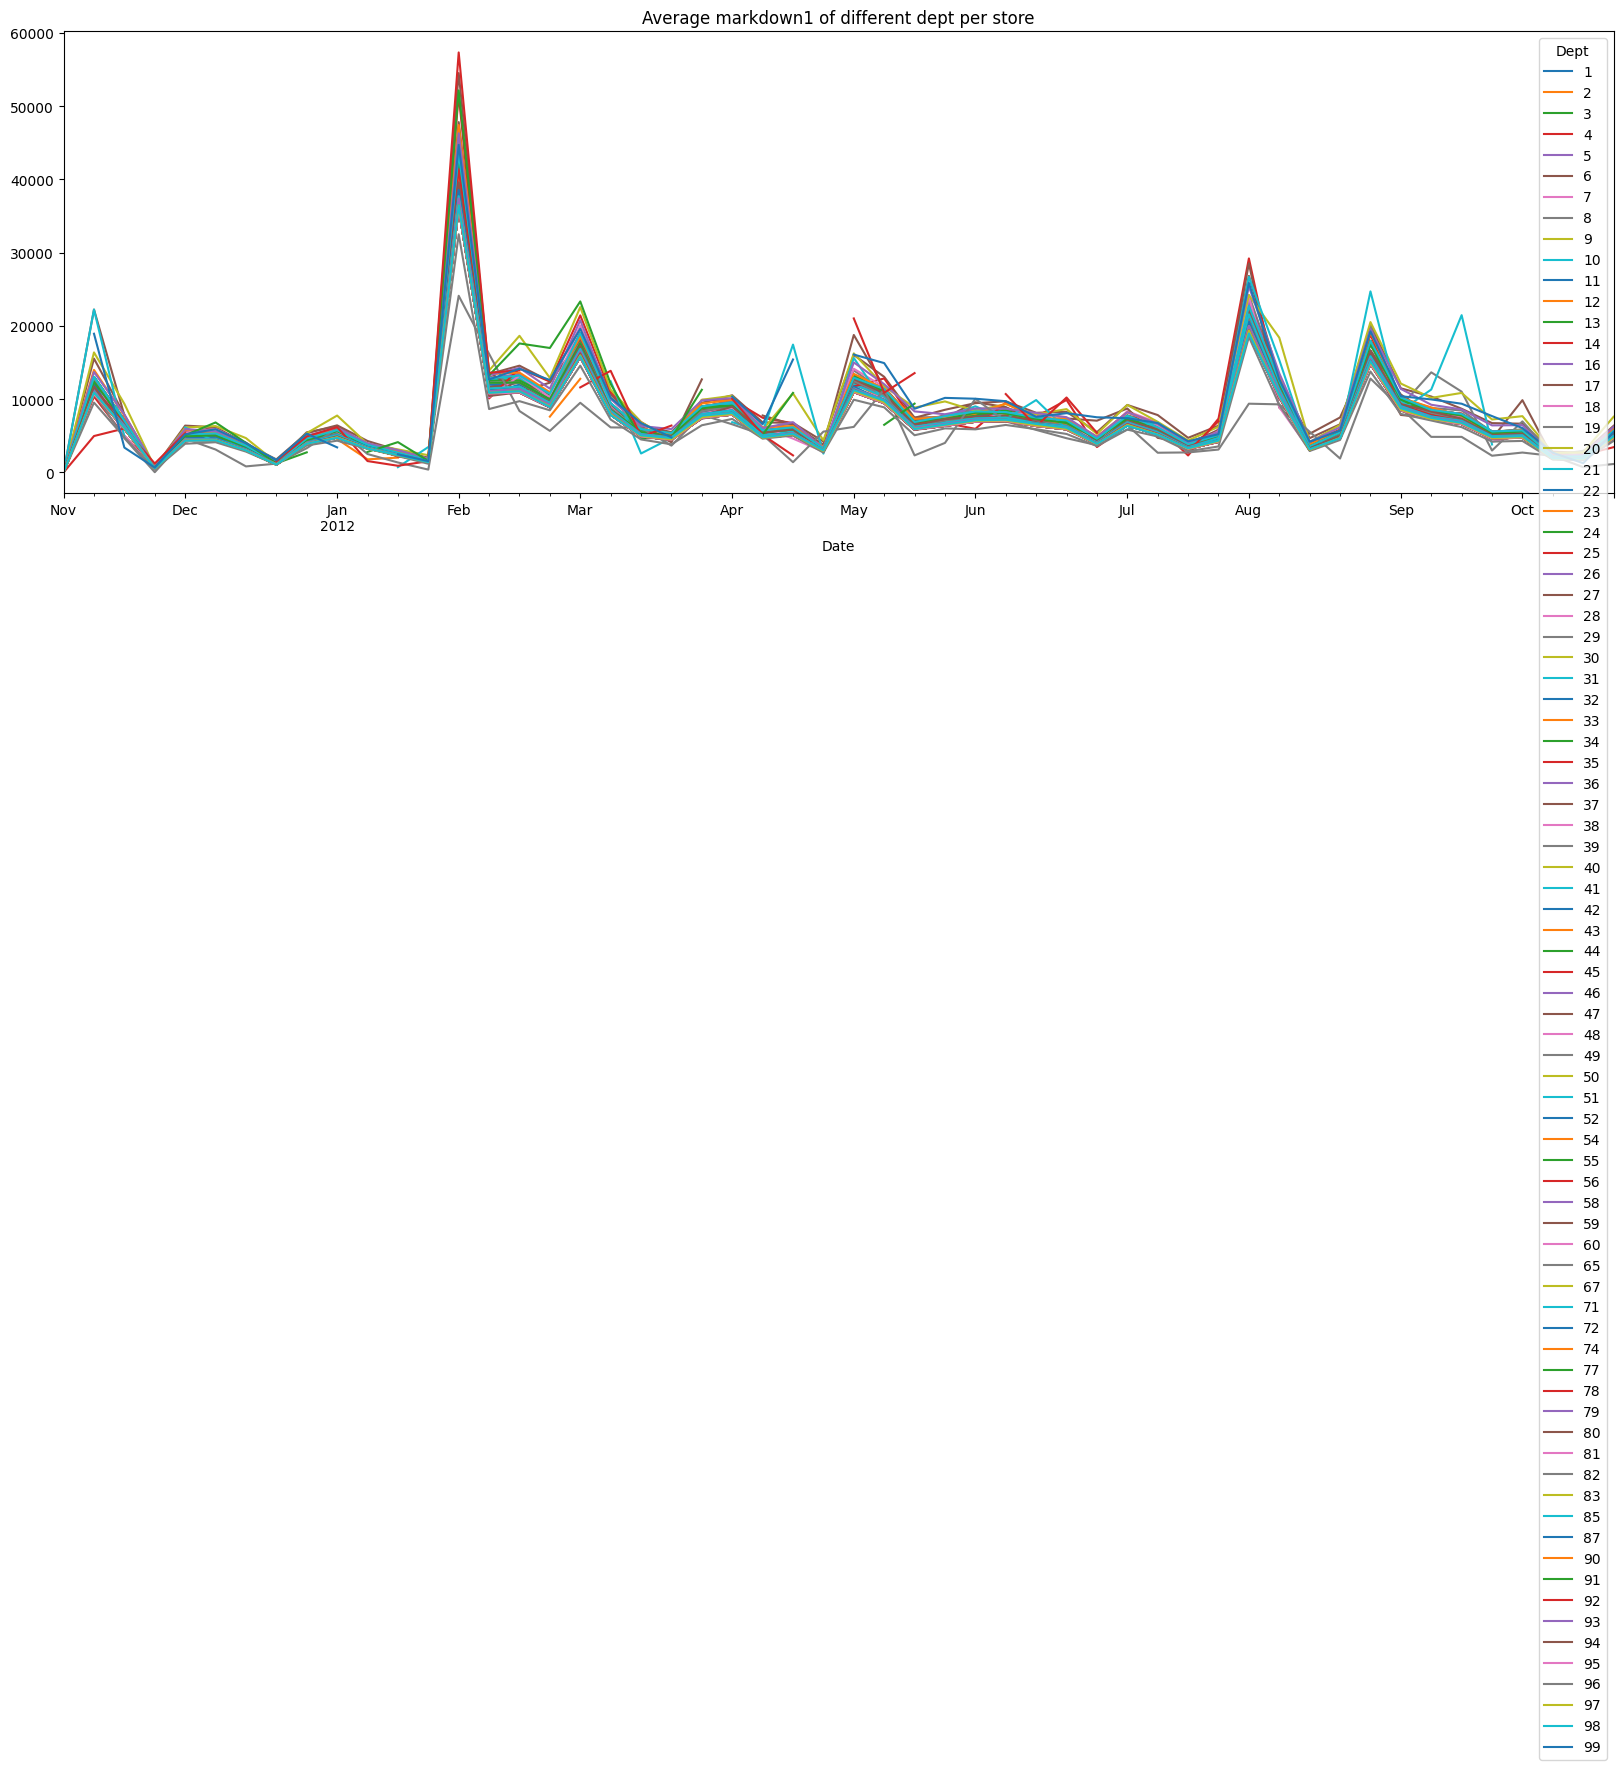

In [124]:
pivot_dept_markdown1.plot(figsize=(20,6))
plt.title('Average markdown1 of different dept per store');

This is average markdown 1 of dept 92 only.

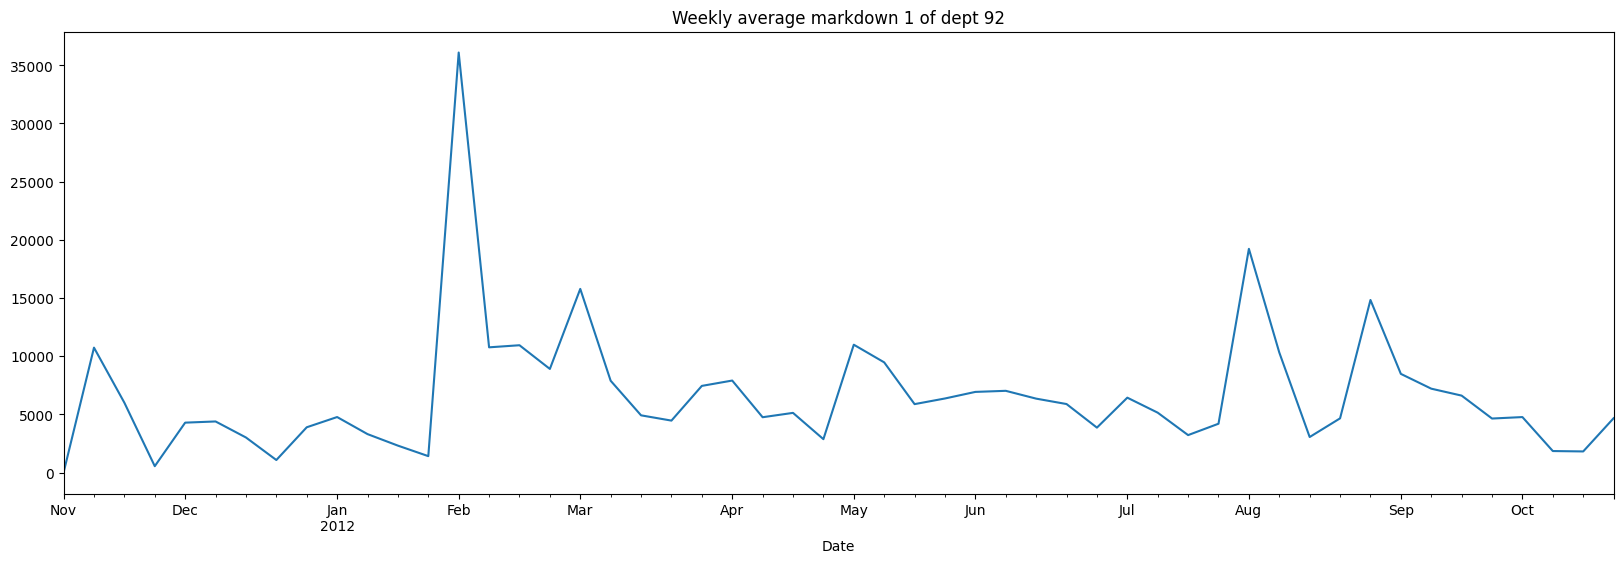

In [125]:
pivot_dept_markdown1[92].plot(figsize=(20,6))
plt.title('Weekly average markdown 1 of dept 92');

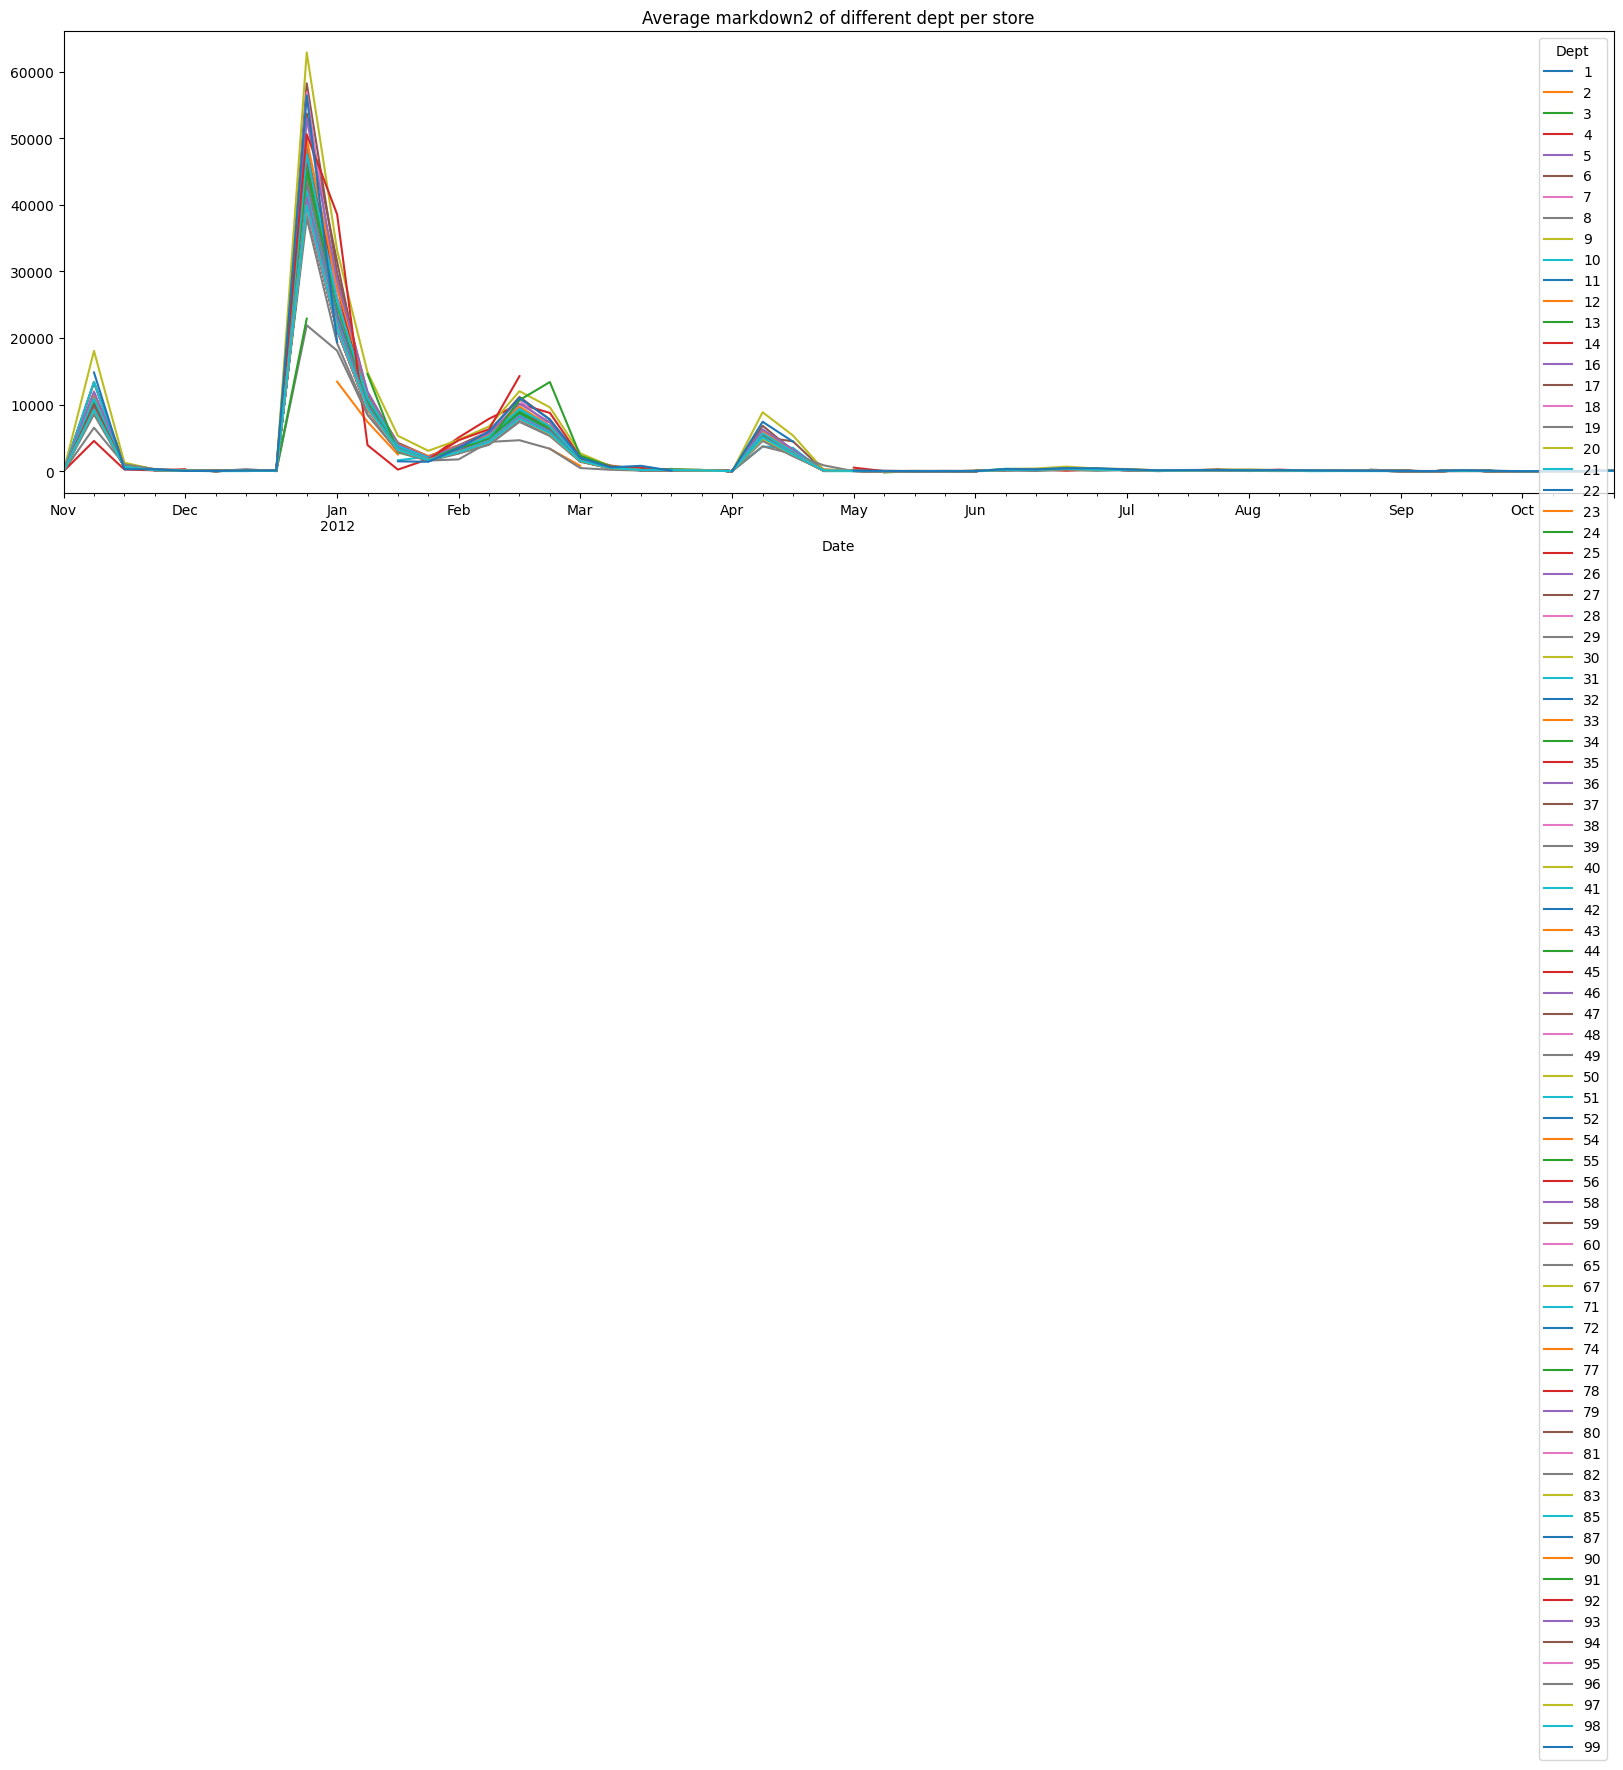

In [126]:
dept_markdown2 = dept_grouping2[['Date','Dept','MarkDown2']]
pivot_dept_markdown2 = dept_markdown2.pivot(index='Date', columns='Dept', values='MarkDown2')
pivot_dept_markdown2.plot(figsize=(20,6))
plt.title('Average markdown2 of different dept per store');

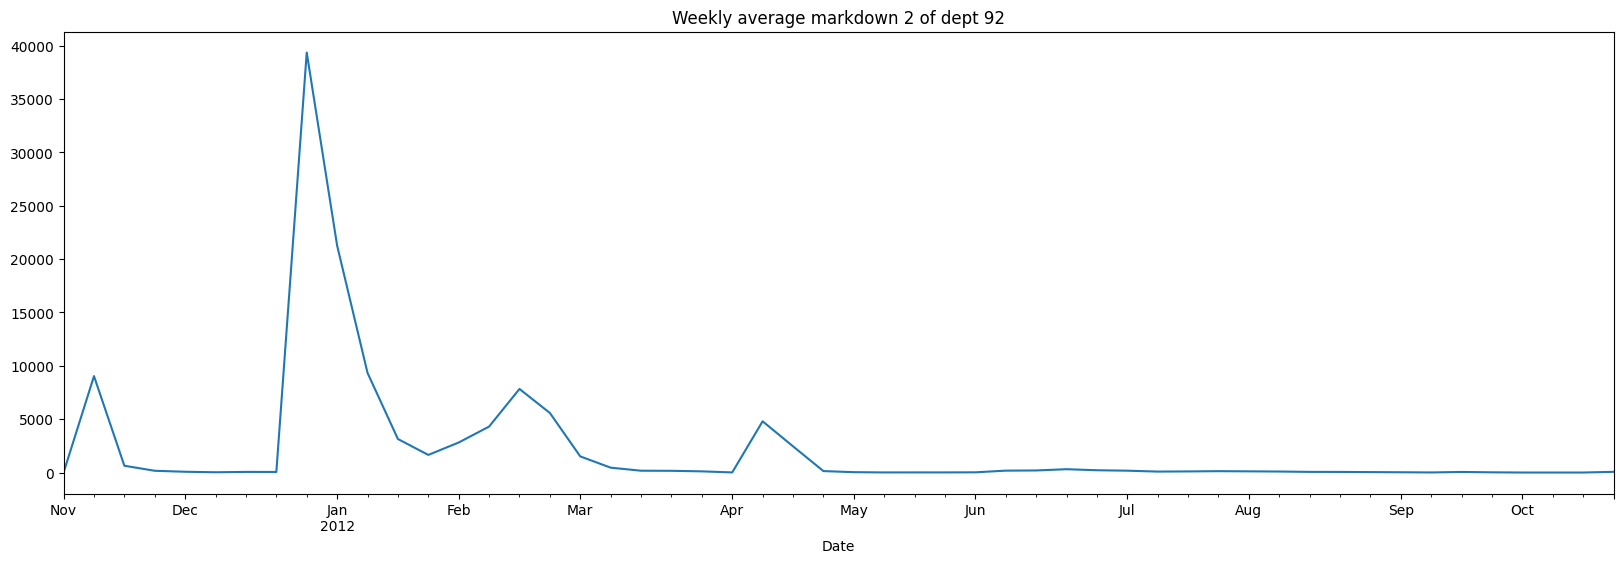

In [127]:
pivot_dept_markdown2[92].plot(figsize=(20,6))
plt.title('Weekly average markdown 2 of dept 92');

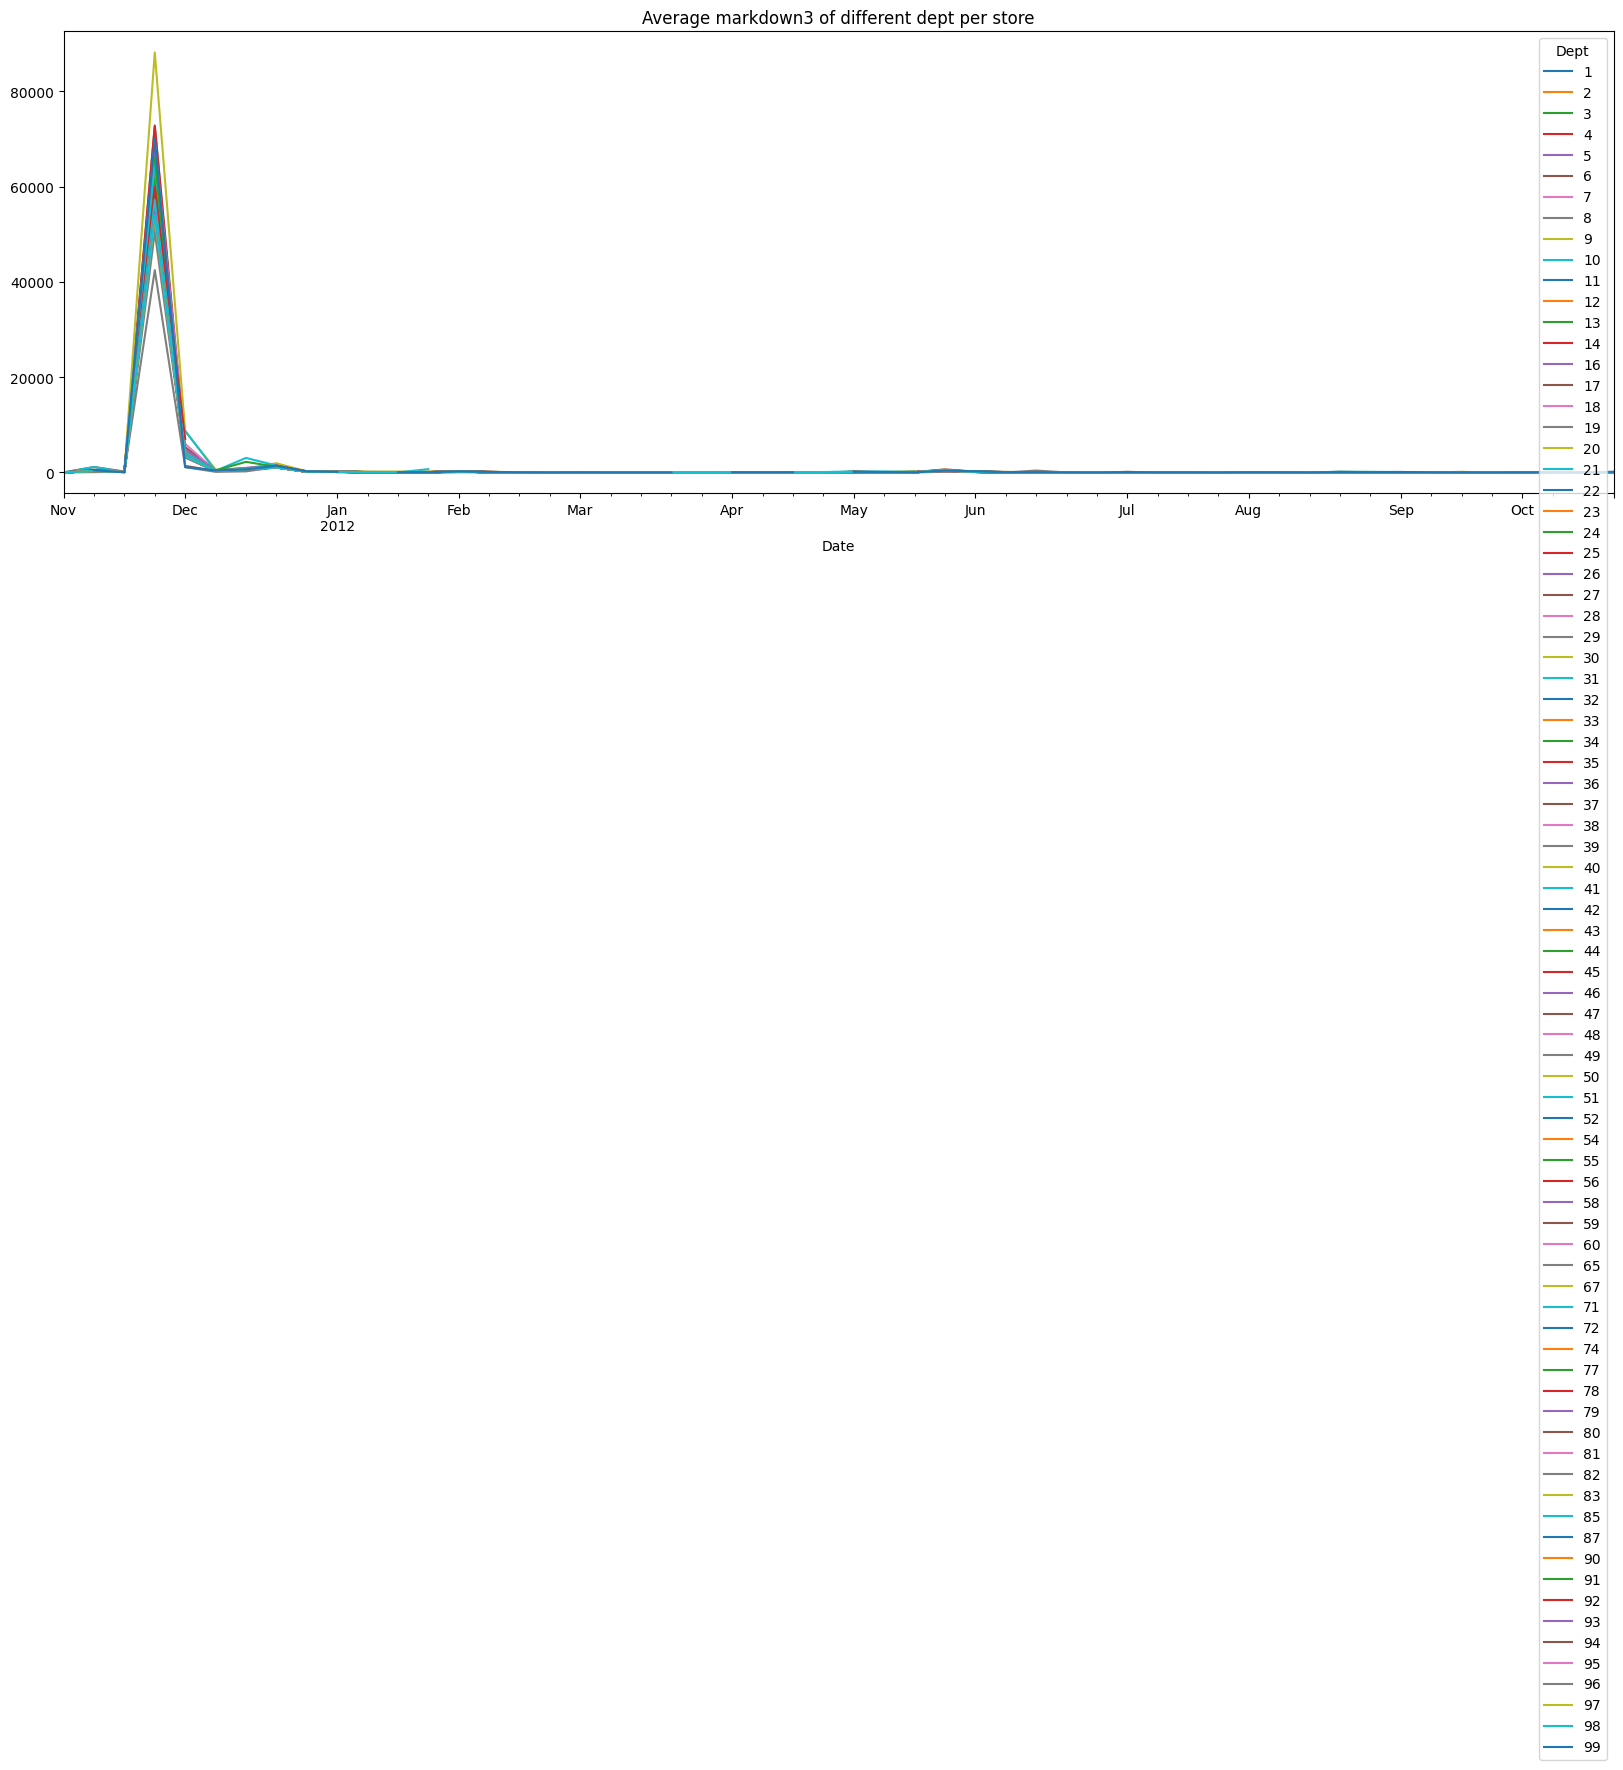

In [128]:
dept_markdown3 = dept_grouping2[['Date','Dept','MarkDown3']]
pivot_dept_markdown3 = dept_markdown3.pivot(index='Date', columns='Dept', values='MarkDown3')
pivot_dept_markdown3.plot(figsize=(20,6))
plt.title('Average markdown3 of different dept per store');

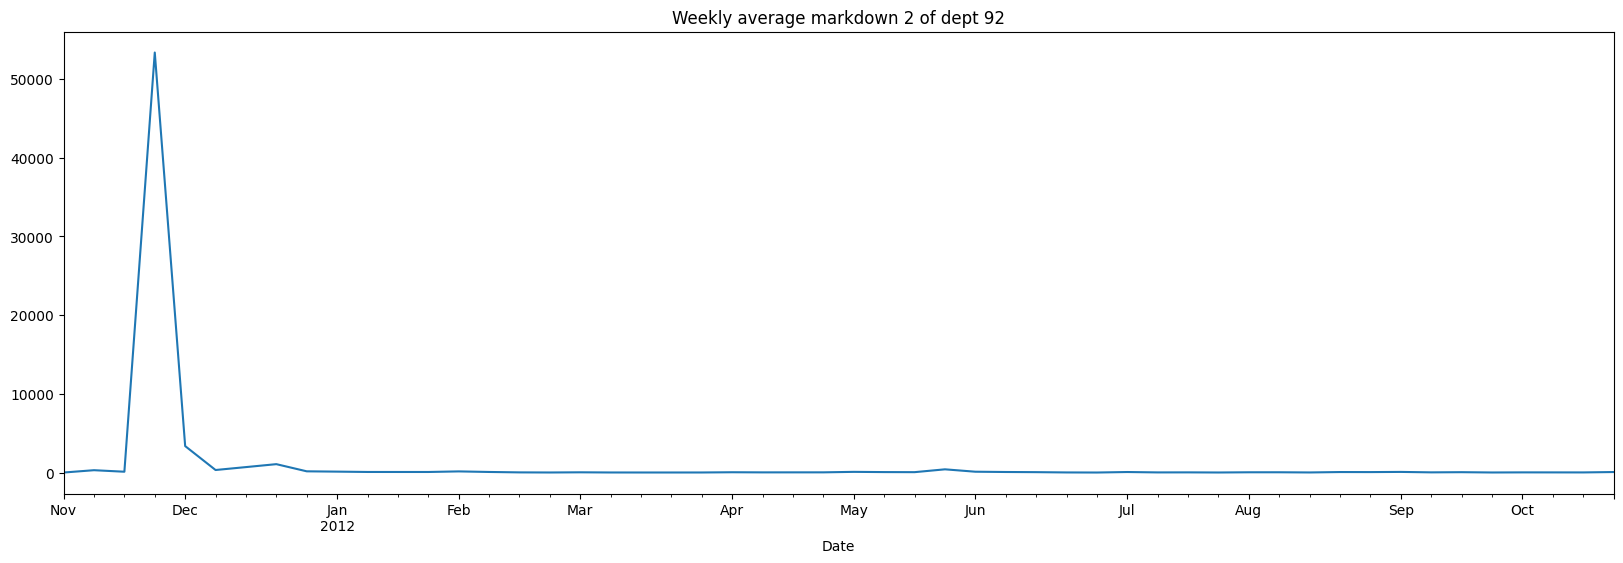

In [129]:
pivot_dept_markdown3[92].plot(figsize=(20,6))
plt.title('Weekly average markdown 2 of dept 92');

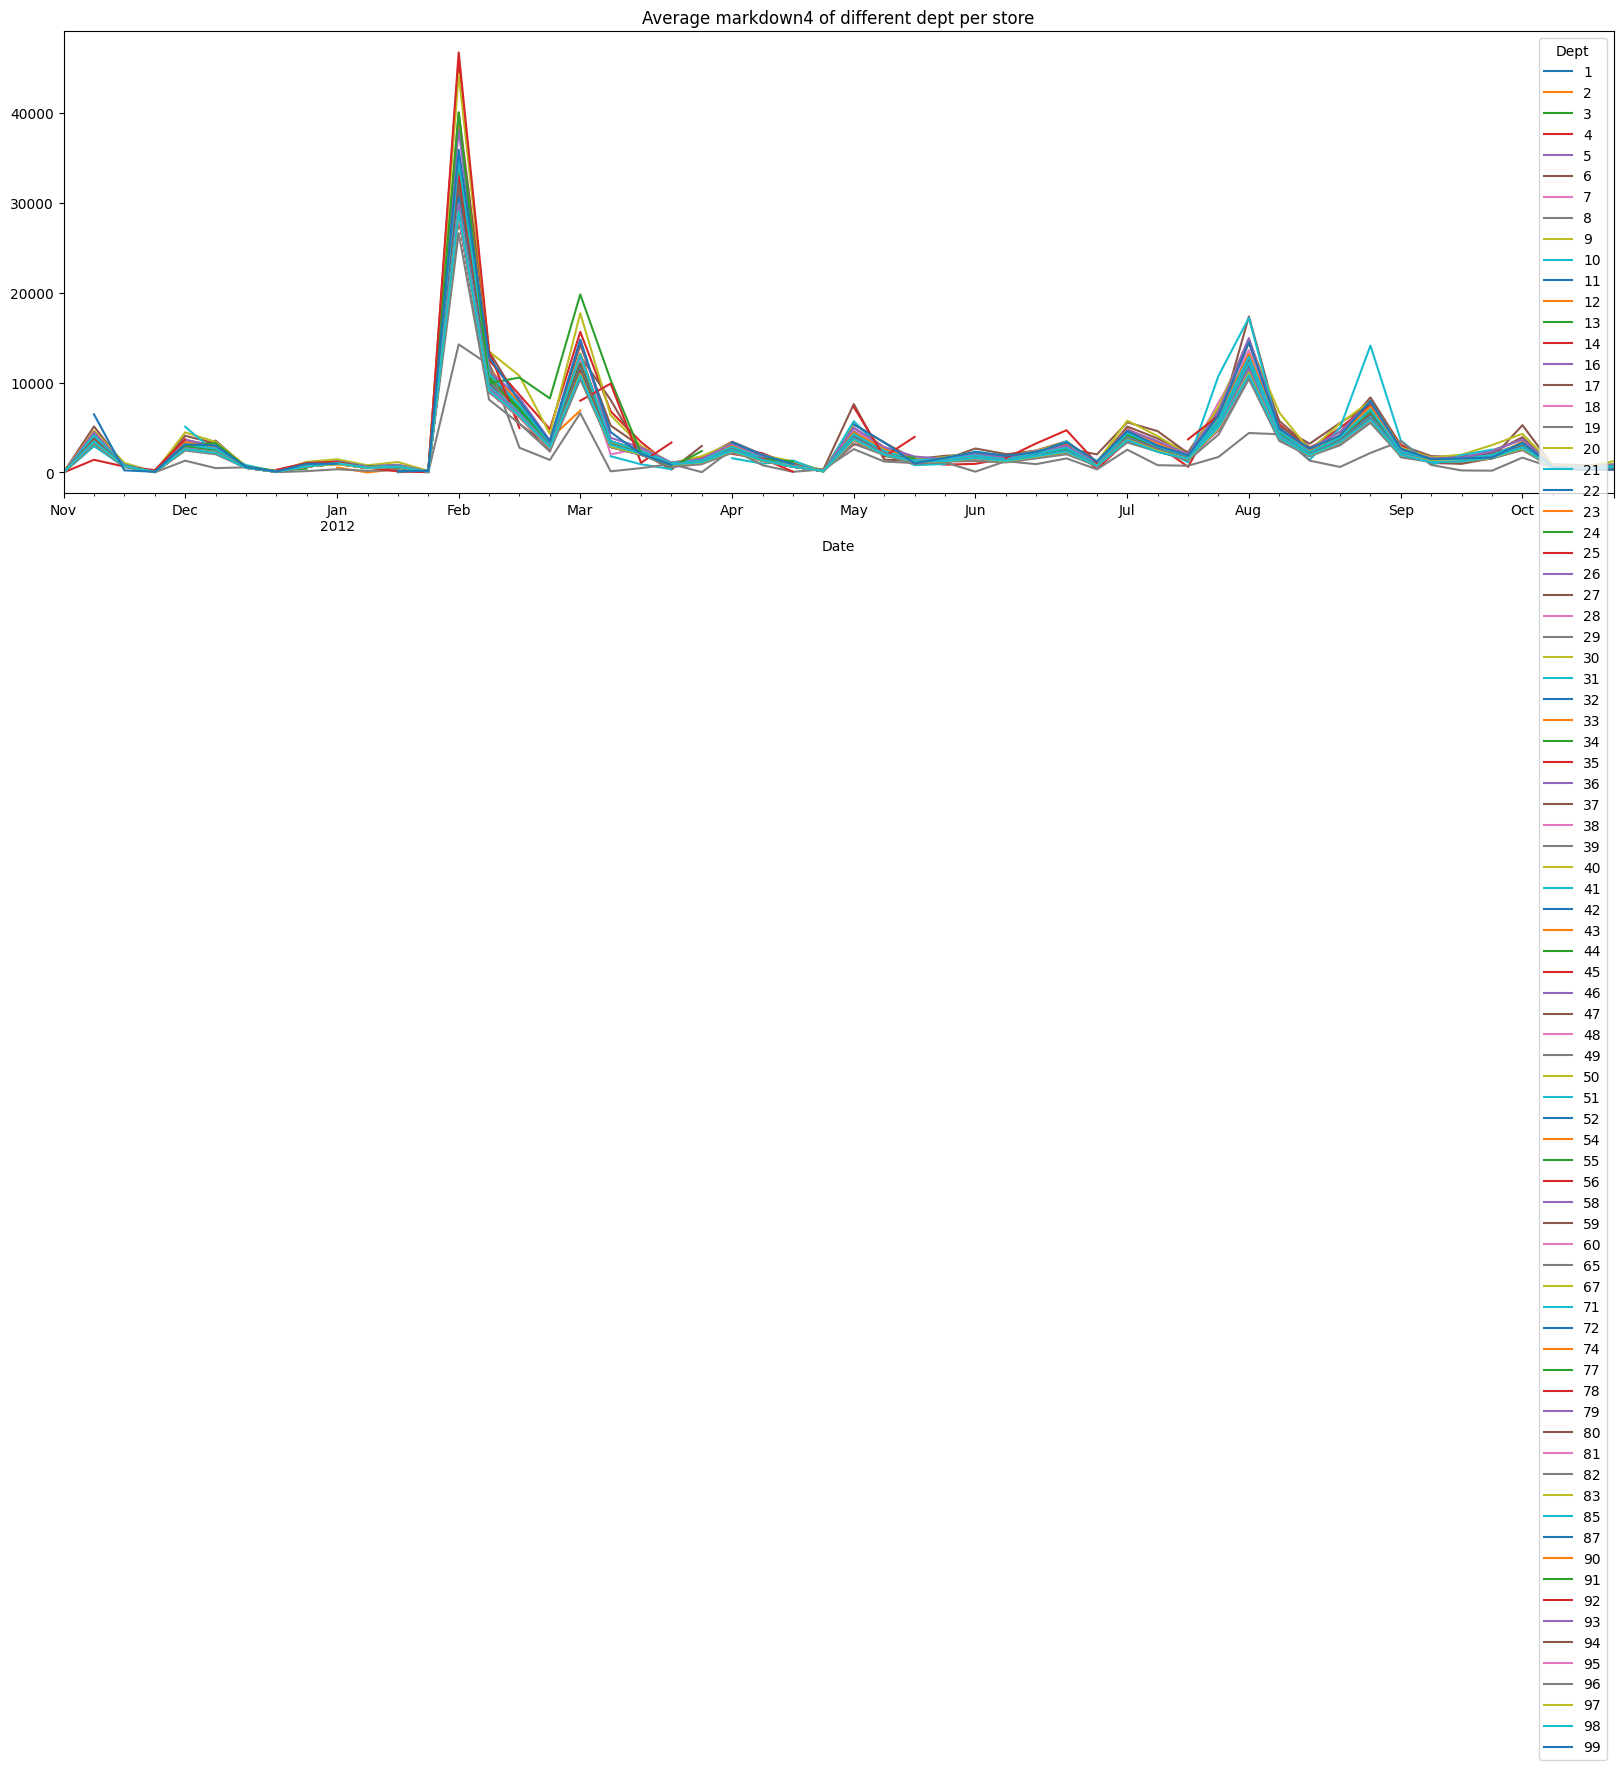

In [130]:
dept_markdown4 = dept_grouping2[['Date','Dept','MarkDown4']]
pivot_dept_markdown4 = dept_markdown4.pivot(index='Date', columns='Dept', values='MarkDown4')
pivot_dept_markdown4.plot(figsize=(20,6))
plt.title('Average markdown4 of different dept per store');

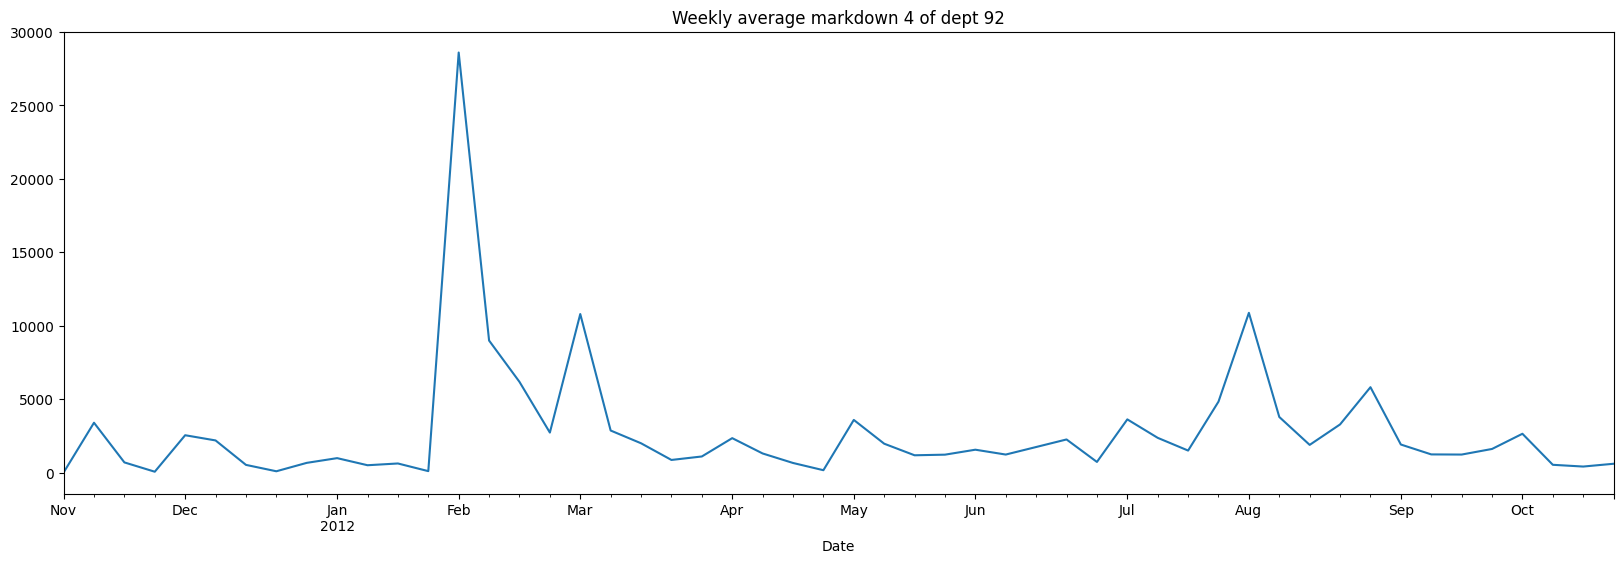

In [131]:
pivot_dept_markdown4[92].plot(figsize=(20,6))
plt.title('Weekly average markdown 4 of dept 92');

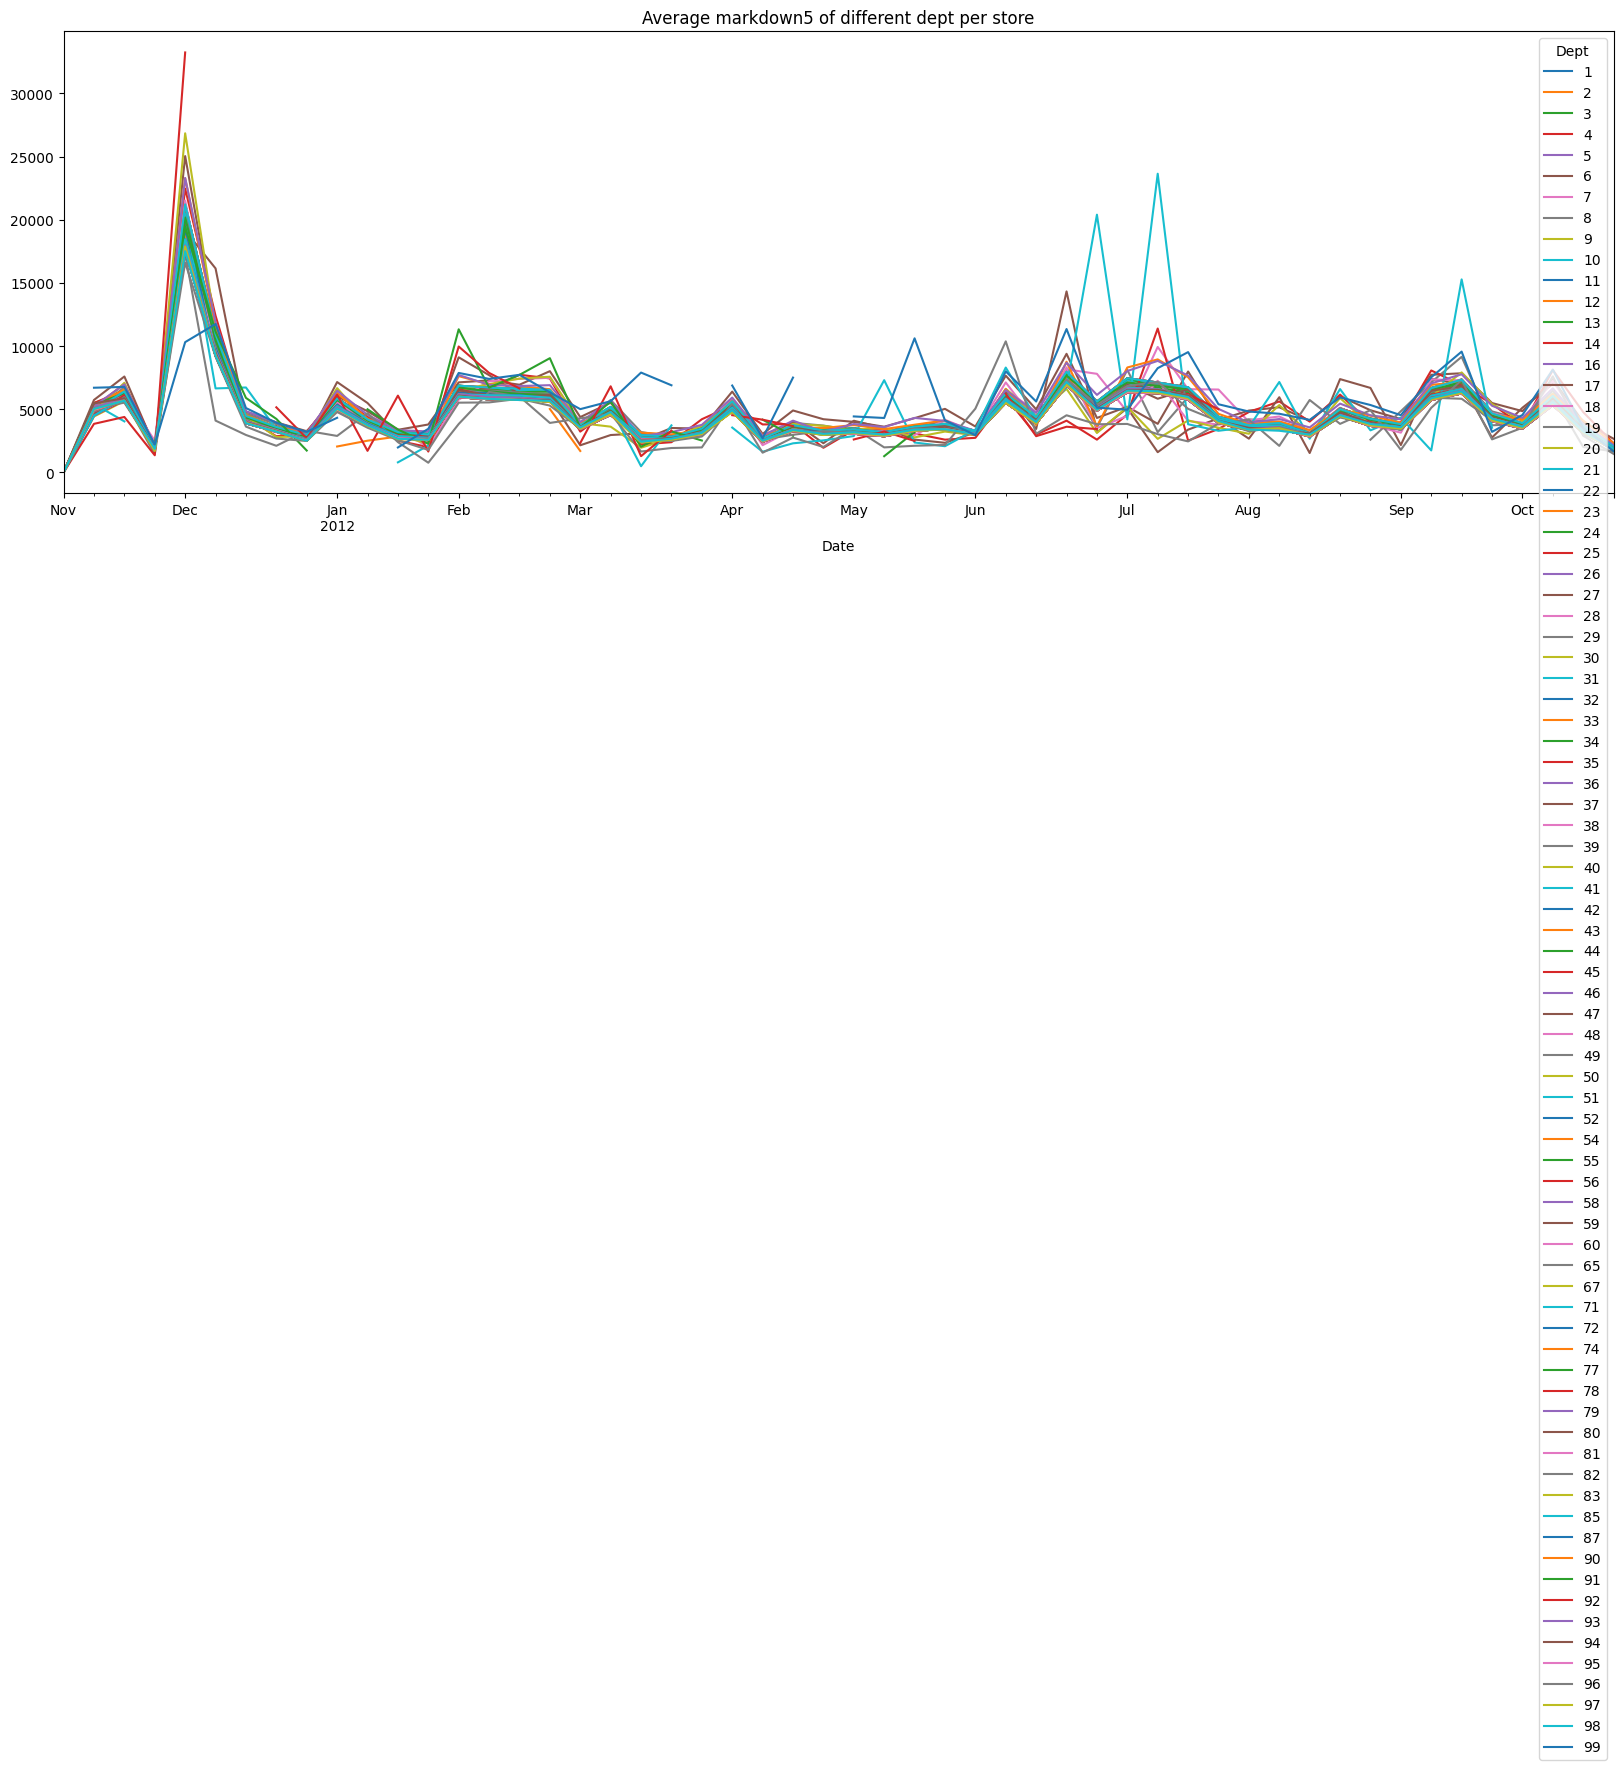

In [132]:
dept_markdown5 = dept_grouping2[['Date','Dept','MarkDown5']]
pivot_dept_markdown5 = dept_markdown5.pivot(index='Date', columns='Dept', values='MarkDown5')
pivot_dept_markdown5.plot(figsize=(20,6))
plt.title('Average markdown5 of different dept per store');

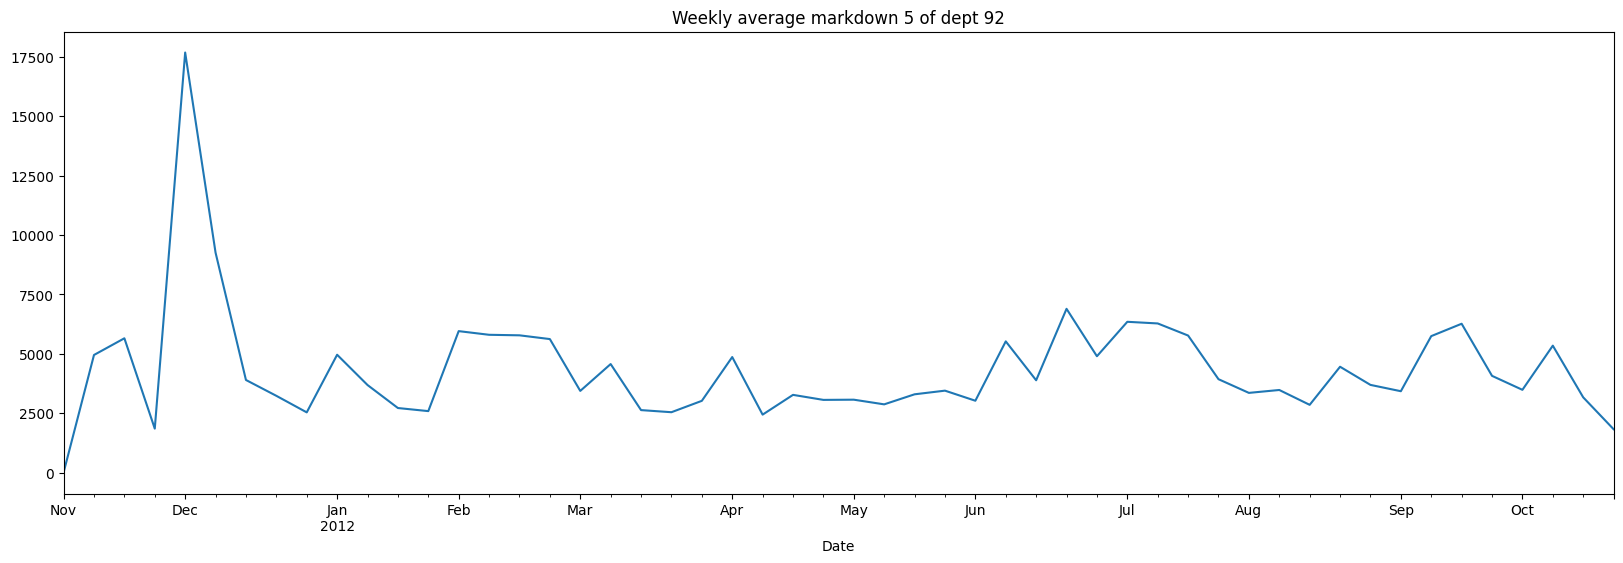

In [133]:
pivot_dept_markdown5[92].plot(figsize=(20,6))
plt.title('Weekly average markdown 5 of dept 92');

From the above charts, it is clear that the amount of each markdown type differs for different departments throughout the year. Additionally, these variations are also evident at the store level.

Additionally, we have examined the average presentation of each markdown type in department 92 across all stores. In the upcoming section, our focus will shift to analyzing the markdown specifically for store 20.

# 3.Exploratory data analysis for dept 92 of store 20

Given that there are a total of 45 stores and 99 departments, it is impractical to build a model that encompasses all of them simultaneously. Therefore, I have chosen to focus on analyzing and building models for the top-performing store (store 20) and the highest-performing department (department 92) based on their sales.

### Non-imputed data for store 20 & dept 92

As we transition to the modeling phase, we will utilize non-imputed data. The necessary data will be sliced without any further modifications..

In [134]:
store20 = data_imputed[(data_imputed['Store']==20) &(data_imputed['Dept']==92) ]

In [135]:
store20.head()

Store  Dept  Weekly_Sales  IsHoliday  Week  Year  Month  \
Date                                                                  
2010-02-05     20    92     195223.84          0     5  2010      2   
2010-02-12     20    92     170043.55          1     6  2010      2   
2010-02-19     20    92     164314.29          0     7  2010      2   
2010-02-26     20    92     147699.66          0     8  2010      2   
2010-03-05     20    92     169171.18          0     9  2010      3   

            Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  \
Date                                                                   
2010-02-05        25.92       2.784        0.0        0.0        0.0   
2010-02-12        22.12       2.773        0.0        0.0        0.0   
2010-02-19        25.43       2.745        0.0        0.0        0.0   
2010-02-26        32.32       2.754        0.0        0.0        0.0   
2010-03-05        31.75       2.777        0.0        0.0        0.0   

            MarkDown4  MarkDown5         CPI  Unemployment  Type    Size  
Date                                                                      
2010-02-05        0.0        0.0  204.247194         8.187     1  203742  
2010-02-12        0.0        0.0  204.385747         8.187     1  203742  
2010-02-19        0.0        0.0  204.432100         8.187     1  203742  
2010-02-26        0.0        0.0  204.463087         8.187     1  203742  
2010-03-05        0.0        0.0  204.494073         8.187     1  203742

Drop 4 columns: Store, Dept, Type, Size

In [136]:
store20 = store20.drop(columns=['Store', 'Dept', 'Type', 'Size'])

### Imputed data for store 20 & dept 92

In the meantime, for further analysis and a comprehensive understanding, we will utilize the imputed data below. 

In [137]:
store20_imputed = data_imputed[(data_imputed['Store']==20) &(data_imputed['Dept']==92) ]

In [138]:
store20_imputed

Store  Dept  Weekly_Sales  IsHoliday  Week  Year  Month  \
Date                                                                  
2010-02-05     20    92     195223.84          0     5  2010      2   
2010-02-12     20    92     170043.55          1     6  2010      2   
2010-02-19     20    92     164314.29          0     7  2010      2   
2010-02-26     20    92     147699.66          0     8  2010      2   
2010-03-05     20    92     169171.18          0     9  2010      3   
...           ...   ...           ...        ...   ...   ...    ...   
2012-09-28     20    92     158539.12          0    39  2012      9   
2012-10-05     20    92     187027.05          0    40  2012     10   
2012-10-12     20    92     191136.10          0    41  2012     10   
2012-10-19     20    92     171537.94          0    42  2012     10   
2012-10-26     20    92     160785.98          0    43  2012     10   

            Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  \
Date                                                                   
2010-02-05        25.92       2.784       0.00       0.00       0.00   
2010-02-12        22.12       2.773       0.00       0.00       0.00   
2010-02-19        25.43       2.745       0.00       0.00       0.00   
2010-02-26        32.32       2.754       0.00       0.00       0.00   
2010-03-05        31.75       2.777       0.00       0.00       0.00   
...                 ...         ...        ...        ...        ...   
2012-09-28        58.65       3.997    6245.60      52.64      21.50   
2012-10-05        60.77       3.985    5800.66       0.00      33.68   
2012-10-12        47.20       4.000    2449.31       0.00      35.08   
2012-10-19        56.26       3.969    4174.31       0.00      15.84   
2012-10-26        60.04       3.882   10813.19      22.33     102.91   

            MarkDown4  MarkDown5         CPI  Unemployment  Type    Size  
Date                                                                      
2010-02-05       0.00       0.00  204.247194         8.187     1  203742  
2010-02-12       0.00       0.00  204.385747         8.187     1  203742  
2010-02-19       0.00       0.00  204.432100         8.187     1  203742  
2010-02-26       0.00       0.00  204.463087         8.187     1  203742  
2010-03-05       0.00       0.00  204.494073         8.187     1  203742  
...               ...        ...         ...           ...   ...     ...  
2012-09-28    3301.81    7195.56  215.736716         7.280     1  203742  
2012-10-05    4286.15    3224.25  215.925886         7.293     1  203742  
2012-10-12    1019.90    9743.56  216.115057         7.293     1  203742  
2012-10-19     838.05    3838.56  216.146470         7.293     1  203742  
2012-10-26     867.39    1671.76  216.151590         7.293     1  203742  

[143 rows x 18 columns]

In [139]:
store20_imputed.head()

Store  Dept  Weekly_Sales  IsHoliday  Week  Year  Month  \
Date                                                                  
2010-02-05     20    92     195223.84          0     5  2010      2   
2010-02-12     20    92     170043.55          1     6  2010      2   
2010-02-19     20    92     164314.29          0     7  2010      2   
2010-02-26     20    92     147699.66          0     8  2010      2   
2010-03-05     20    92     169171.18          0     9  2010      3   

            Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  \
Date                                                                   
2010-02-05        25.92       2.784        0.0        0.0        0.0   
2010-02-12        22.12       2.773        0.0        0.0        0.0   
2010-02-19        25.43       2.745        0.0        0.0        0.0   
2010-02-26        32.32       2.754        0.0        0.0        0.0   
2010-03-05        31.75       2.777        0.0        0.0        0.0   

            MarkDown4  MarkDown5         CPI  Unemployment  Type    Size  
Date                                                                      
2010-02-05        0.0        0.0  204.247194         8.187     1  203742  
2010-02-12        0.0        0.0  204.385747         8.187     1  203742  
2010-02-19        0.0        0.0  204.432100         8.187     1  203742  
2010-02-26        0.0        0.0  204.463087         8.187     1  203742  
2010-03-05        0.0        0.0  204.494073         8.187     1  203742

Drop 4 columns "Store", "Dept", "Type" & "Size"

In [140]:
store20_imputed = store20_imputed.drop(columns=['Store','Dept','Type','Size'])

In [141]:
store20_imputed.head()

Weekly_Sales  IsHoliday  Week  Year  Month  Temperature  \
Date                                                                  
2010-02-05     195223.84          0     5  2010      2        25.92   
2010-02-12     170043.55          1     6  2010      2        22.12   
2010-02-19     164314.29          0     7  2010      2        25.43   
2010-02-26     147699.66          0     8  2010      2        32.32   
2010-03-05     169171.18          0     9  2010      3        31.75   

            Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
Date                                                                            
2010-02-05       2.784        0.0        0.0        0.0        0.0        0.0   
2010-02-12       2.773        0.0        0.0        0.0        0.0        0.0   
2010-02-19       2.745        0.0        0.0        0.0        0.0        0.0   
2010-02-26       2.754        0.0        0.0        0.0        0.0        0.0   
2010-03-05       2.777        0.0        0.0        0.0        0.0        0.0   

                   CPI  Unemployment  
Date                                  
2010-02-05  204.247194         8.187  
2010-02-12  204.385747         8.187  
2010-02-19  204.432100         8.187  
2010-02-26  204.463087         8.187  
2010-03-05  204.494073         8.187

In [142]:
store20_imputed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143 entries, 2010-02-05 to 2012-10-26
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Weekly_Sales  143 non-null    float64
 1   IsHoliday     143 non-null    int64  
 2   Week          143 non-null    int64  
 3   Year          143 non-null    int64  
 4   Month         143 non-null    int64  
 5   Temperature   143 non-null    float64
 6   Fuel_Price    143 non-null    float64
 7   MarkDown1     143 non-null    float64
 8   MarkDown2     143 non-null    float64
 9   MarkDown3     143 non-null    float64
 10  MarkDown4     143 non-null    float64
 11  MarkDown5     143 non-null    float64
 12  CPI           143 non-null    float64
 13  Unemployment  143 non-null    float64
dtypes: float64(10), int64(4)
memory usage: 16.8 KB


#### Use heatmap & pairplot to see the correlations between data.

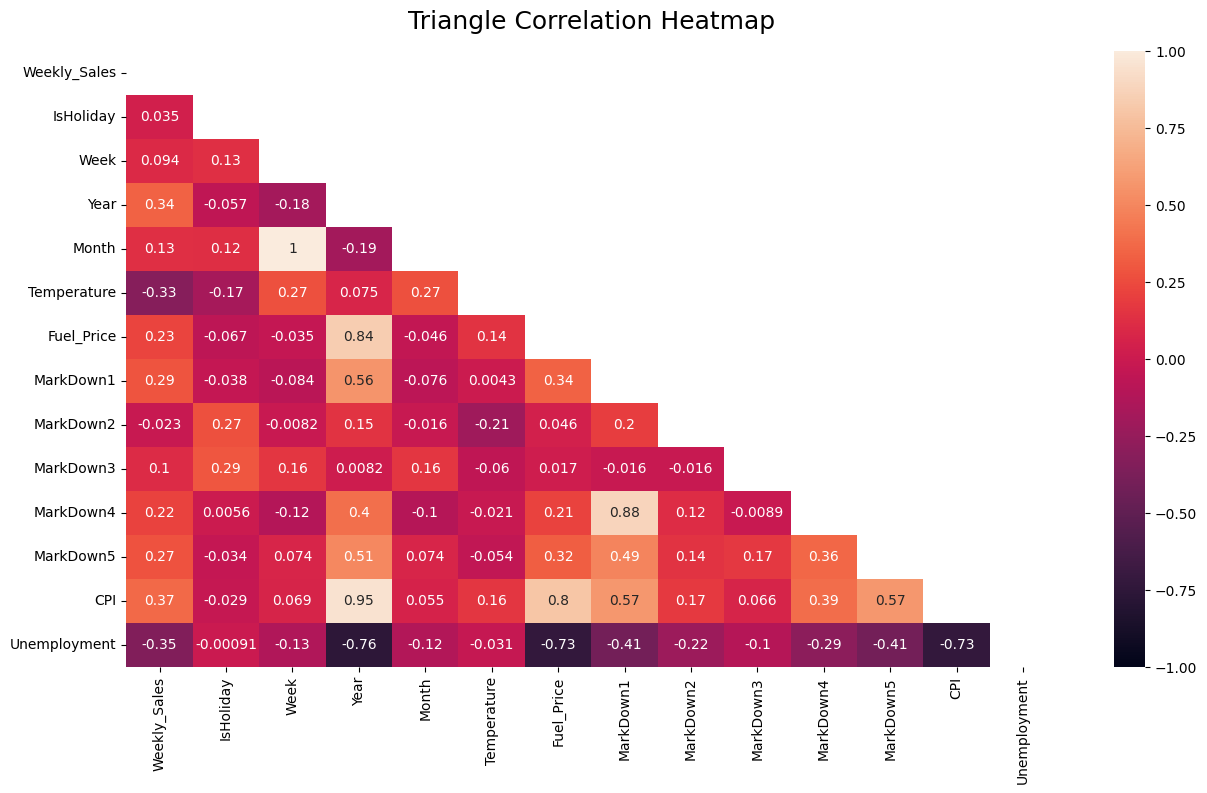

In [143]:
plt.figure(figsize=(15, 8))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(store20_imputed.corr(), dtype=bool))
heatmap = sns.heatmap(store20_imputed.corr(), mask=mask, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

Based on the observations, there is a positive correlation between weekly sales and variables such as CPI and markdowns. This suggests that higher CPI values and increased markdown activity are associated with higher sales. On the other hand, there is a negative correlation between weekly sales and variables like temperature and unemployment rate. This indicates that lower temperatures and higher unemployment rates tend to be associated with lower sales.

In [144]:
store20_imputed_resetindex = store20_imputed.reset_index()

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/xf/z2fcddts049dxg763n_0c6qw0000gn/T/ipykernel_68927/2138301580.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


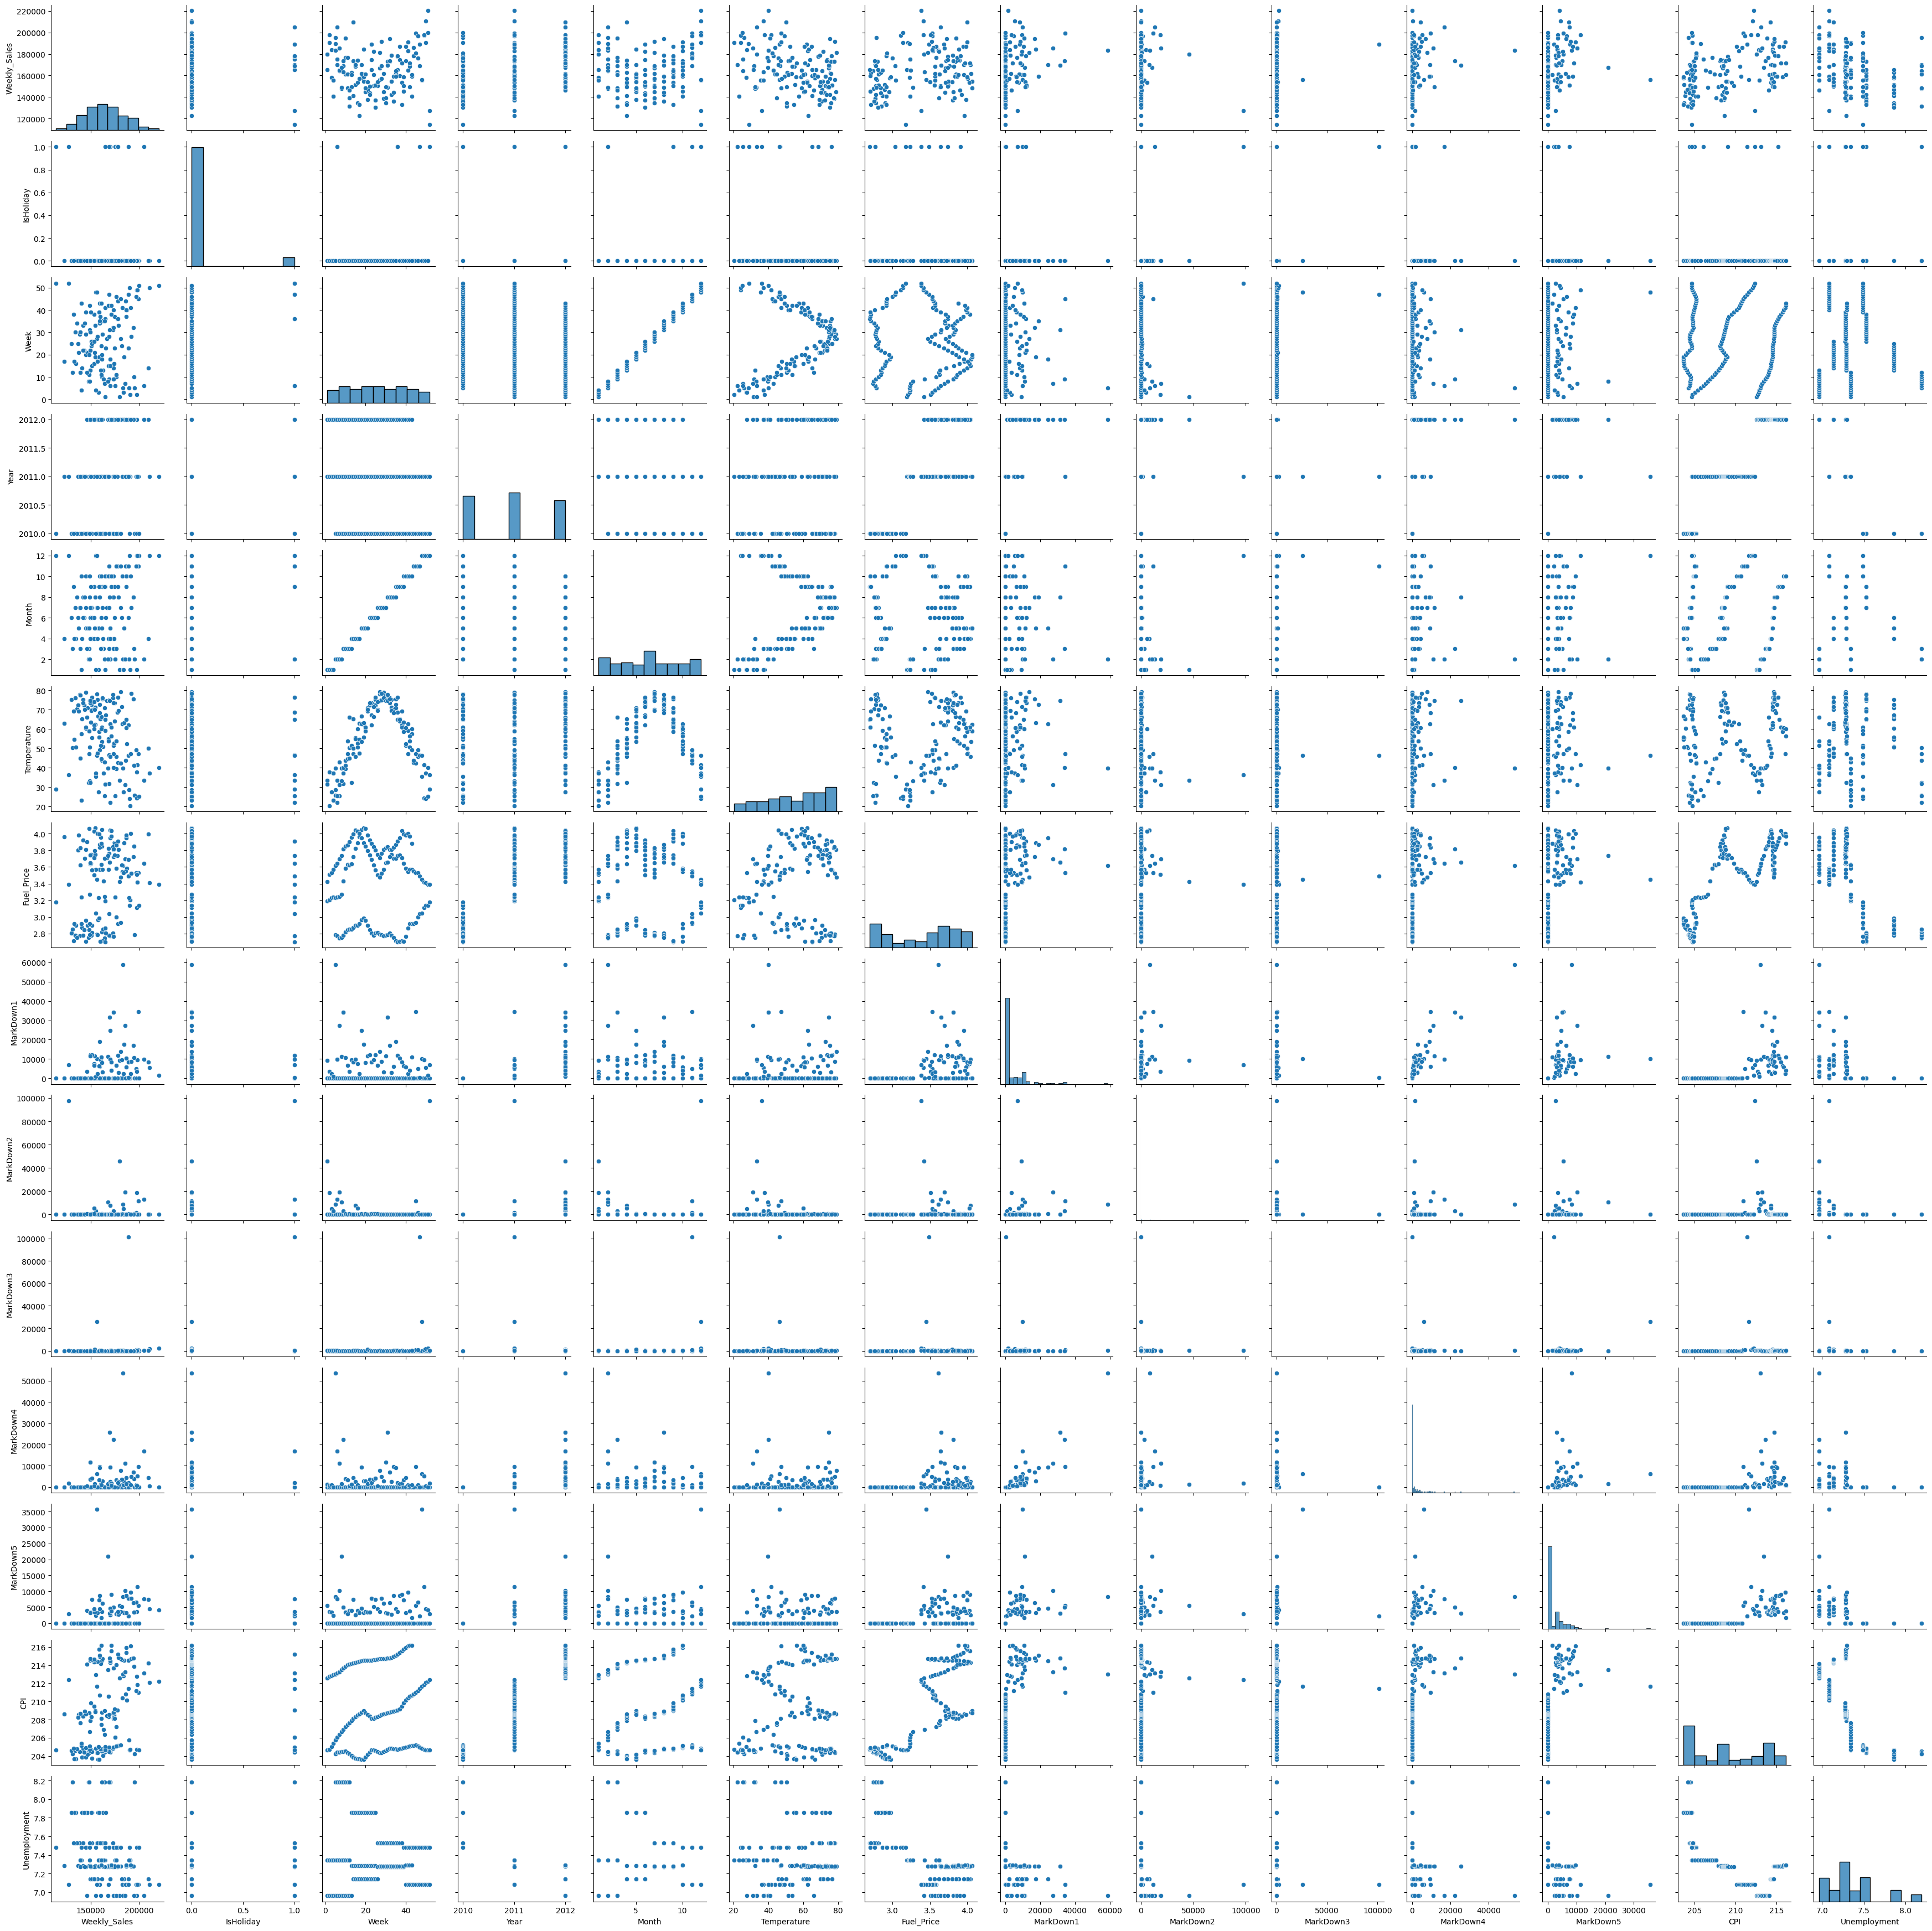

In [145]:
sns.pairplot(store20_imputed_resetindex)
plt.tight_layout()
plt.show()

### 3.1. Sales by week

Sales by week from 2010 to 2012.

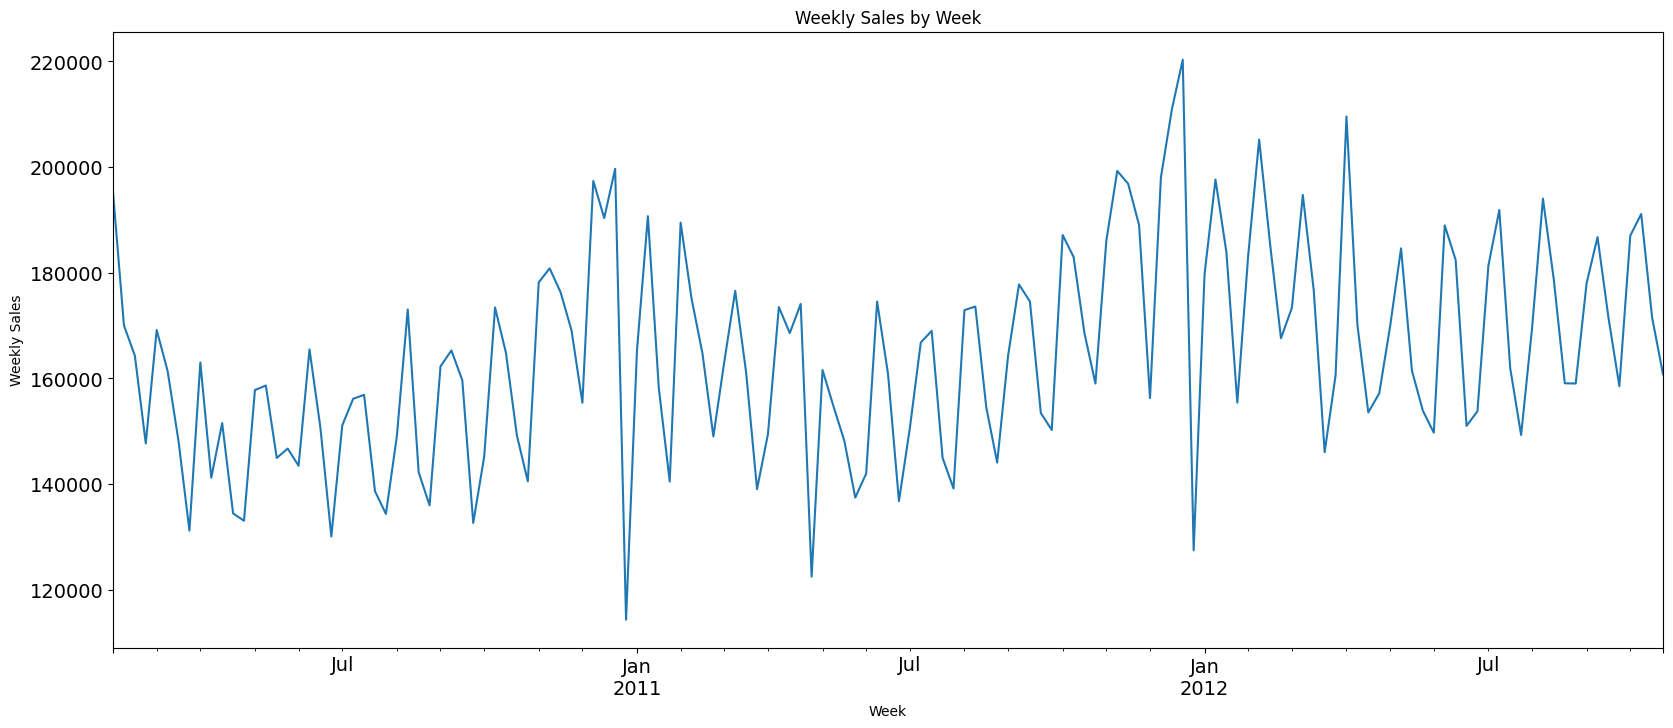

In [148]:
plt.figure(figsize=(20,8))
store20_imputed.Weekly_Sales.plot(fontsize=14)
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales by Week')
plt.show();

In [149]:
store20_imputed_resetindex = store20_imputed.copy()
store20_imputed_resetindex.reset_index(inplace=True)

In [150]:
store_2010_week = store20_imputed_resetindex[store20_imputed_resetindex['Year']==2010]
store_2011_week = store20_imputed_resetindex[store20_imputed_resetindex['Year']==2011]
store_2012_week = store20_imputed_resetindex[store20_imputed_resetindex['Year']==2012]
store_2012_week.head()

Date  Weekly_Sales  IsHoliday  Week  Year  Month  Temperature  \
100 2012-01-06     179795.84          0     1  2012      1        33.42   
101 2012-01-13     197649.89          0     2  2012      1        37.79   
102 2012-01-20     183870.70          0     3  2012      1        27.65   
103 2012-01-27     155429.53          0     4  2012      1        37.19   
104 2012-02-03     183393.93          0     5  2012      2        39.93   

     Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
100       3.422    9273.46   45971.43     207.60    1365.38    5460.86   
101       3.513    3627.81   18632.14     108.48     847.70    3614.04   
102       3.533    2465.98    5030.40     106.54     999.54    3380.92   
103       3.567    1023.60    3044.15     106.08      52.87    2447.73   
104       3.617   58928.52    8766.77     226.27   53603.99    8301.25   

            CPI  Unemployment  
100  212.571112         6.961  
101  212.738649         6.961  
102  212.833640         6.961  
103  212.928631         6.961  
104  213.023622         6.961

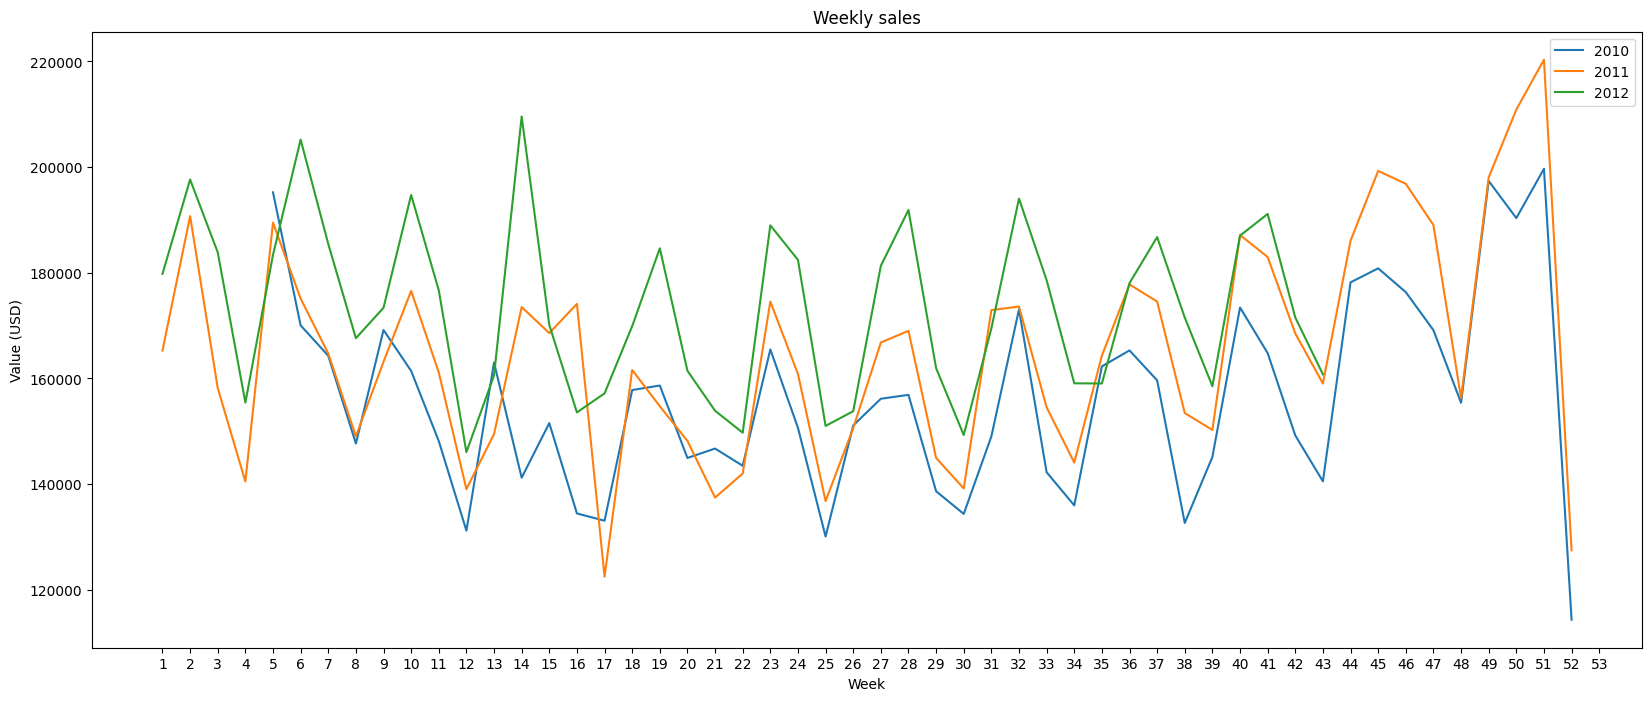

In [151]:
plt.figure(figsize=(20, 8))
plt.plot(store_2010_week['Week'], store_2010_week['Weekly_Sales'], label='2010')
plt.plot(store_2011_week['Week'], store_2011_week['Weekly_Sales'], label='2011')
plt.plot(store_2012_week['Week'], store_2012_week['Weekly_Sales'], label='2012')
plt.xlabel('Week')
plt.ylabel('Value (USD)')
plt.legend()
plt.title('Weekly sales')
plt.xticks(range(1, 54, 1))
plt.show()

The sales demonstrate an upward trend, and the overall patterns appear to be similar. Sales consistently increase every 4 to 5 weeks, and the stores perform exceptionally well in the last quarter of the year, particularly during the Christmas holiday season when sales reach their peak.

In [152]:
store20_imputed.describe()

Weekly_Sales   IsHoliday        Week         Year       Month  \
count     143.000000  143.000000  143.000000   143.000000  143.000000   
mean   164633.741538    0.069930   25.818182  2010.965035    6.447552   
std     19970.754969    0.255926   14.177763     0.799759    3.249438   
min    114348.680000    0.000000    1.000000  2010.000000    1.000000   
25%    149999.215000    0.000000   14.000000  2010.000000    4.000000   
50%    163022.590000    0.000000   26.000000  2011.000000    6.000000   
75%    177920.090000    0.000000   37.500000  2012.000000    9.000000   
max    220321.480000    1.000000   52.000000  2012.000000   12.000000   

       Temperature  Fuel_Price     MarkDown1     MarkDown2      MarkDown3  \
count   143.000000  143.000000    143.000000    143.000000     143.000000   
mean     55.451399    3.417608   4013.042867   1815.373007     956.883986   
std      16.543846    0.443029   8231.447936   9402.698654    8733.609037   
min      20.390000    2.699000      0.000000     -0.990000       0.000000   
25%      42.865000    2.921000      0.000000      0.000000       0.000000   
50%      58.650000    3.541000      0.000000      0.000000       0.000000   
75%      70.330000    3.809000   6185.310000     70.000000      17.675000   
max      79.200000    4.066000  58928.520000  97740.990000  101378.790000   

          MarkDown4     MarkDown5         CPI  Unemployment  
count    143.000000    143.000000  143.000000    143.000000  
mean    1934.258951   2159.098951  209.038131      7.371413  
std     5799.518501   4293.364349    4.176736      0.305069  
min        0.000000      0.000000  203.610178      6.961000  
25%        0.000000      0.000000  204.774194      7.139000  
50%        0.000000      0.000000  208.556714      7.287000  
75%     1325.400000   3484.570000  213.372861      7.484000  
max    53603.990000  35675.620000  216.151590      8.187000

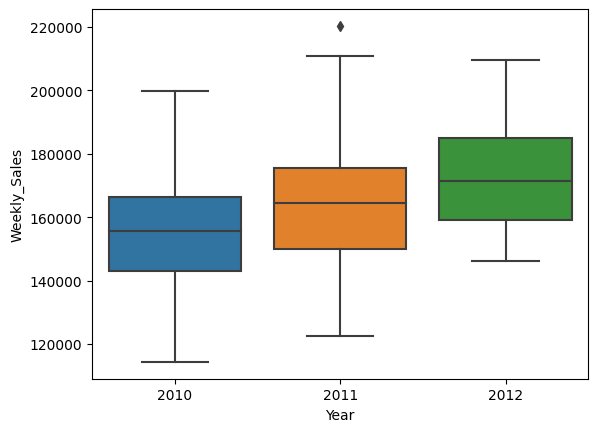

In [153]:
sns.boxplot(x=store20_imputed["Year"],y=store20_imputed["Weekly_Sales"]);

Upon examining the weekly sales data over the years, it is evident that there was a consistent upward trend. The frequency of higher sales progressively increased as each year passed.

### 3.2. Markdown

There are 5 different types of markdowns available. Analyzing them separately is highly beneficial as it enables us to identify which specific type of markdown was effective in driving sales. This information can then be used to determine the most suitable markdown strategy to boost sales when needed.

In [154]:
store_2012_week[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].mean()

MarkDown1    11651.336279
MarkDown2     3442.136512
MarkDown3       76.843023
MarkDown4     5868.302791
MarkDown5     5483.514651
dtype: float64

In [155]:
Weekly_sales_2012 = store_2012_week['Weekly_Sales'].mean()
Weekly_sales_2012

173169.2193023256

In 2012, Markdown 1 was approximately 7% of the weekly sales. On the other hand, Markdown 4 and Markdown 5 reflected a relatively smaller amount with approximately 3% of the sales. Markdown 2 represented only 2% of the sales, while Markdown 3 had a minimal value, with a mere 0.04% of the total sales.

In [156]:
(store_2012_week[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].mean()/Weekly_sales_2012)*100

MarkDown1    6.728295
MarkDown2    1.987730
MarkDown3    0.044375
MarkDown4    3.388768
MarkDown5    3.166564
dtype: float64

In [157]:
mardown_fromNov11 = store20_imputed.loc['2011-11':][['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']]
mardown_fromNov11.head()

MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5
Date                                                             
2011-11-04       0.00       0.00       0.00       0.00       0.00
2011-11-11   34348.14   11652.84     549.25    9606.11    5472.37
2011-11-18    4817.96    1673.96     658.55    1043.37    6545.16
2011-11-25     335.66      80.00  101378.79      64.46    2251.98
2011-12-02   10007.34      60.00   25959.98    6140.65   35675.62

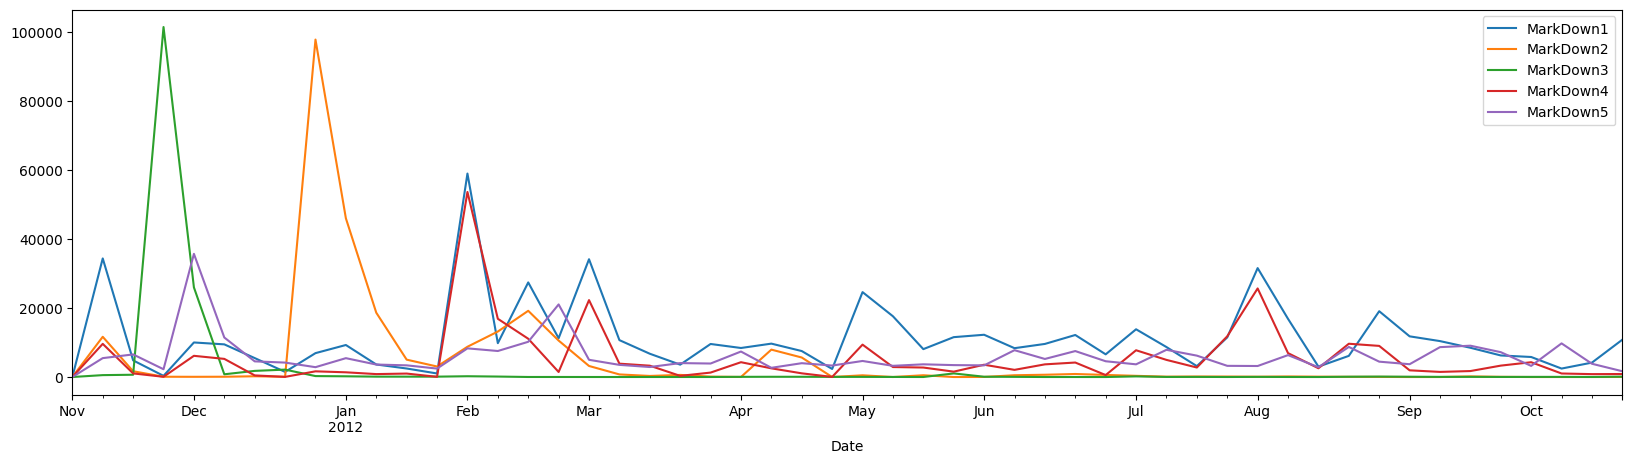

In [158]:
mardown_fromNov11.plot(figsize=(20,5));

In [159]:
mardown_fromNov11['MarkDown1'].sum()

573865.1300000001

In [160]:
store20_imputed.loc['2011-11':][['Weekly_Sales']].sum()

Weekly_Sales    9130507.29
dtype: float64

The available data spans from November 2011 to October 2012, representing a one-year period for analysis.

The five different markdowns exhibited distinct patterns over the weeks.

Markdown 1 reached its peak in February, with sales nearing 60,000 USD, and fluctuated below 38,000 USD thereafter.

Markdown 2 had a significant spike in December 2011, reaching nearly 100,000 USD, but gradually declined over time. From May 2012 onwards, it remained relatively low and eventually dropped to almost zero.

Markdown 3 started at over 100,000 USD in the last week of December 2011 but quickly diminished to nearly zero in the following weeks.

Markdown 4 had a peak similar to markdown 1 in the fifth week, with sales close to 60,000 USD. It gradually decreased with fluctuations of less than 30,000 USD.

Markdown 5 with exceptional peak occurring in December 2011 of nearly 38,000 USD, its amplitude was around 20,000 USD.

In [161]:
Holiday_list

DatetimeIndex(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
               '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
               '2012-02-10', '2012-09-07'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [162]:
from pandas import Timestamp
holiday_list_upto2012 = [timestamp for timestamp in Holiday_list if timestamp <= Timestamp('2012-10-31 00:00:00')]

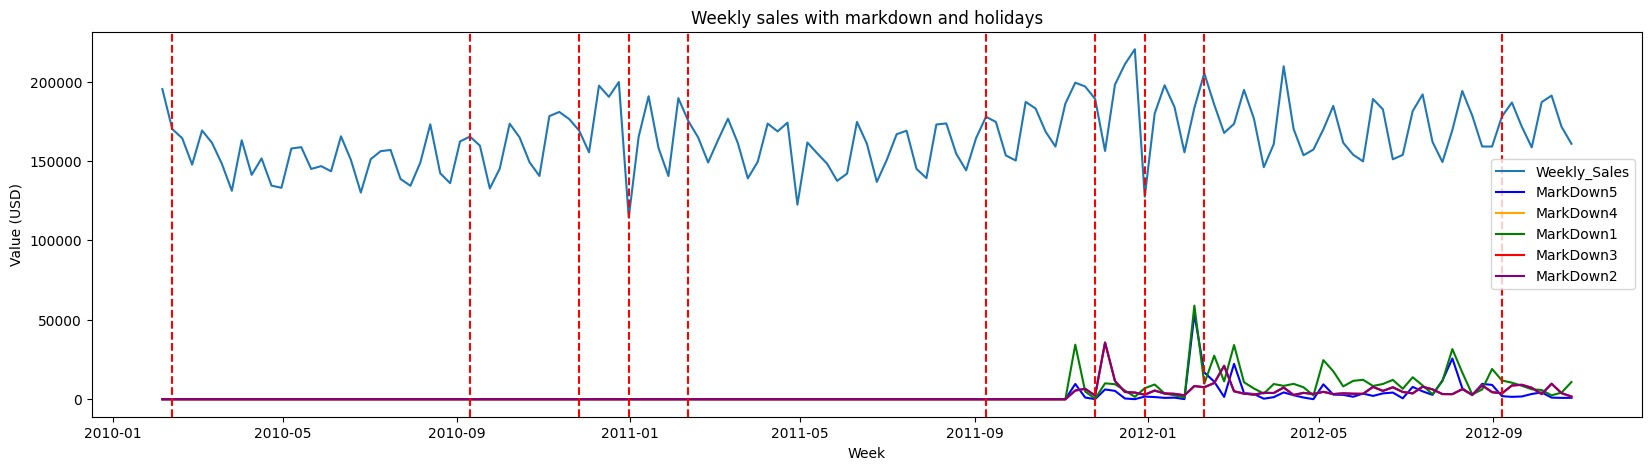

In [163]:

plt.figure(figsize=(20, 5))
plt.plot(store20_imputed['Weekly_Sales'], label='Weekly_Sales')


plt.plot(store20_imputed['MarkDown4'], label='MarkDown5',color ='blue')
plt.plot(store20_imputed['MarkDown5'], label='MarkDown4',color='orange')
plt.plot(store20_imputed['MarkDown1'], label='MarkDown1',color="green")
plt.plot(store20_imputed['MarkDown5'], label='MarkDown3',color="red")
plt.plot(store20_imputed['MarkDown5'], label='MarkDown2',color='purple')

for holiday_week in holiday_list_upto2012:
    plt.axvline(holiday_week, color='red', linestyle='--')


plt.xlabel('Week')
plt.ylabel('Value (USD)')
plt.legend()
plt.title('Weekly sales with markdown and holidays')
plt.show()

The red dotted straight lines on the graph represent the holiday weeks. Although we can only observe the markdown data from November 2011 and do not have enough holiday data,we can see that there is a correlation between increasing sales and higher markdowns.

In [164]:
store20_fromNov11 = store20_imputed.loc['2011-11':][['Weekly_Sales','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']]

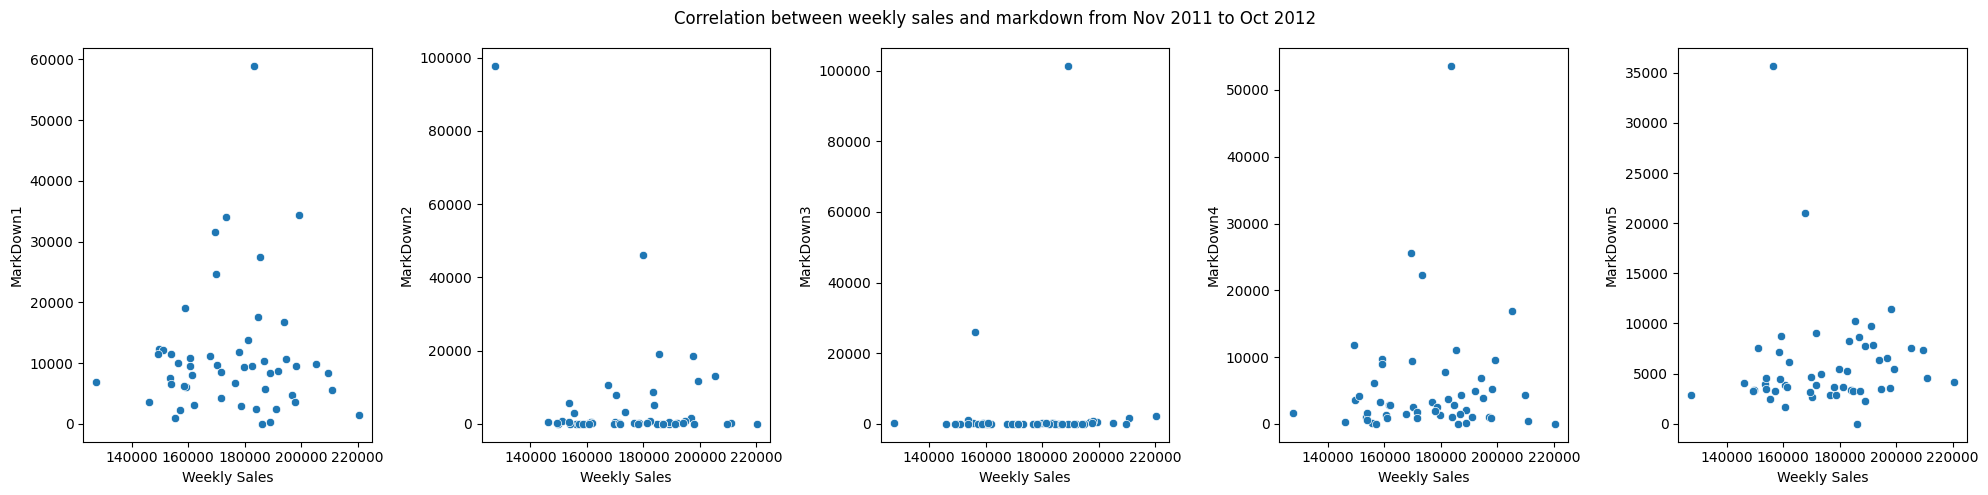

In [165]:
markdown_col = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
fig, axes = plt.subplots(nrows=1, ncols=len(markdown_col), figsize=(20, 5))

for i, col in enumerate(markdown_col):
    sns.scatterplot(x='Weekly_Sales', y=col, data=store20_fromNov11, ax=axes[i])
    axes[i].set_xlabel('Weekly Sales')
    axes[i].set_ylabel(col)

plt.suptitle('Correlation between weekly sales and markdown from Nov 2011 to Oct 2012')
plt.tight_layout()
plt.show();


Markdown 2 and Markdown 3 seems to have the lowest correlation with weekly sales.

### 3.3. Holiday

In [166]:
store20_imputed.groupby('IsHoliday')['Weekly_Sales'].mean()

IsHoliday
0    164444.359023
1    167152.529000
Name: Weekly_Sales, dtype: float64

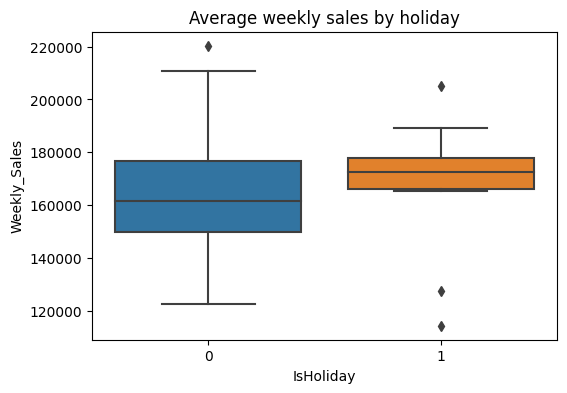

In [167]:
plt.figure(figsize=(6,4))
sns.boxplot(x=store20_imputed['IsHoliday'],y=store20_imputed["Weekly_Sales"])
plt.title('Average weekly sales by holiday');

Overall, the sales during holiday weeks were higher compared to the sales during normal weeks. Even though there was not a significant increase but we can explain in next graph.

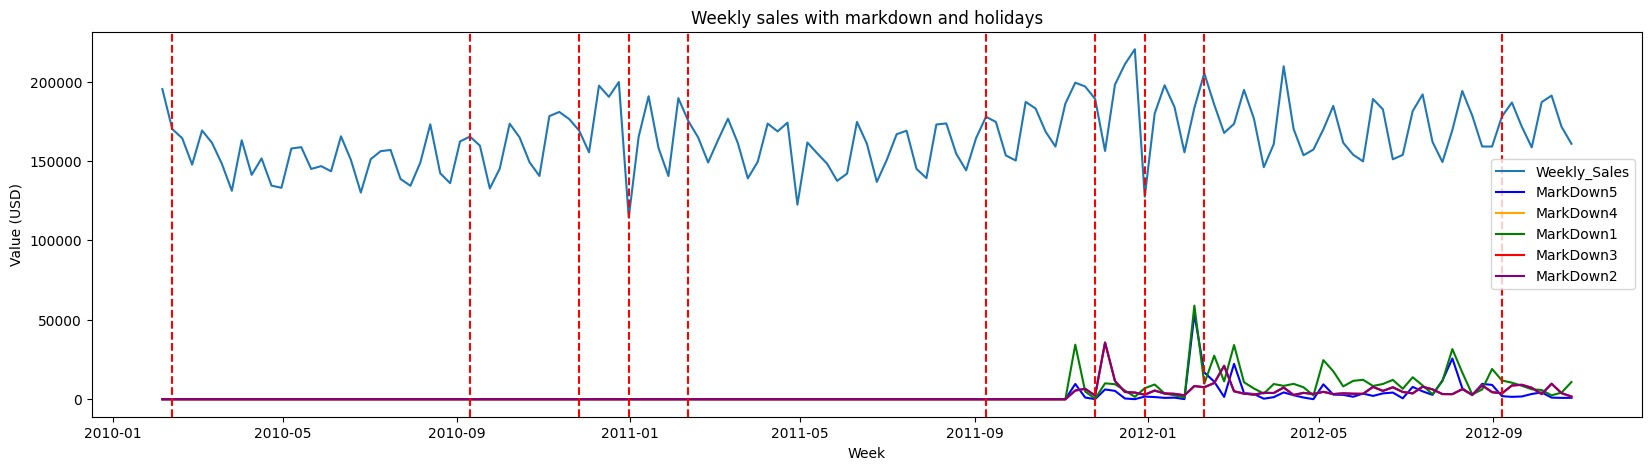

In [168]:

plt.figure(figsize=(20, 5))
plt.plot(store20_imputed['Weekly_Sales'], label='Weekly_Sales')


plt.plot(store20_imputed['MarkDown4'], label='MarkDown5',color ='blue')
plt.plot(store20_imputed['MarkDown5'], label='MarkDown4',color='orange')
plt.plot(store20_imputed['MarkDown1'], label='MarkDown1',color="green")
plt.plot(store20_imputed['MarkDown5'], label='MarkDown3',color="red")
plt.plot(store20_imputed['MarkDown5'], label='MarkDown2',color='purple')

for holiday_week in holiday_list_upto2012:
    plt.axvline(holiday_week, color='red', linestyle='--')


plt.xlabel('Week')
plt.ylabel('Value (USD)')
plt.legend()
plt.title('Weekly sales with markdown and holidays')
plt.show()

The red dotted lines in the chart represent holiday weeks. However, since the complete yearly holiday data is not available and it is unlikely that big holidays would occur within a single week, we can observe certain patterns. For smaller or medium holidays, sales tend to increase during the holiday week itself. On the other hand, for major holidays, sales show an increase in the week before and a few weeks prior to the holiday. Despite the limitations in holiday data, there appears to be a relative correlation between holidays and sales, indicating that sales tend to increase around holiday periods.

### 3.4. Temperature

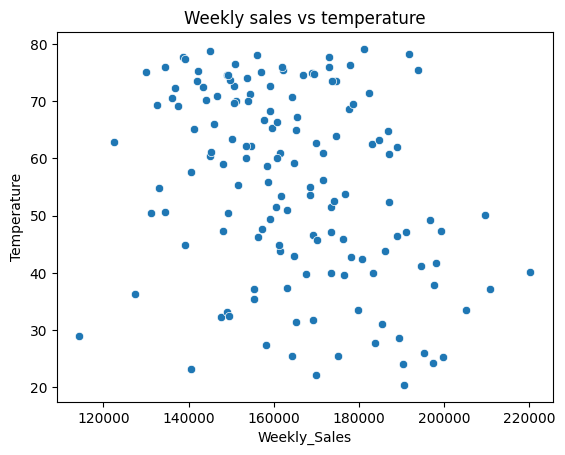

In [175]:
sns.scatterplot(x='Weekly_Sales', y='Temperature', data=store20_imputed)
plt.title('Weekly sales vs temperature')
plt.show();

There was no clear temperature between sales and temperature.

### 3.5. Fuel price

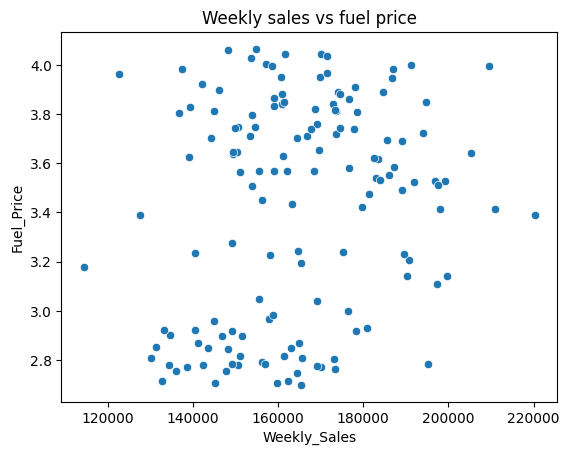

In [176]:
sns.scatterplot(x='Weekly_Sales', y='Fuel_Price', data=store20_imputed)
plt.title('Weekly sales vs fuel price')
plt.show();

Similar to temperature, there was not clear correlation between sales and fuel price.

### 3.6. CPI

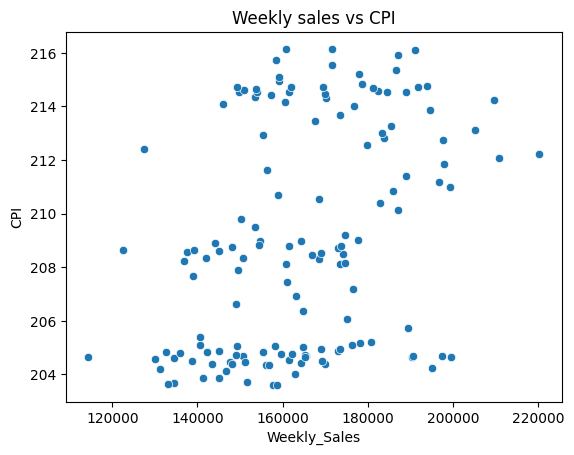

In [178]:
sns.scatterplot(x='Weekly_Sales', y='CPI', data=store20_imputed)
plt.title('Weekly sales vs CPI')
plt.show();

There was not clear correlation between sales and fuel price.

### 3.7. Unemployment rate

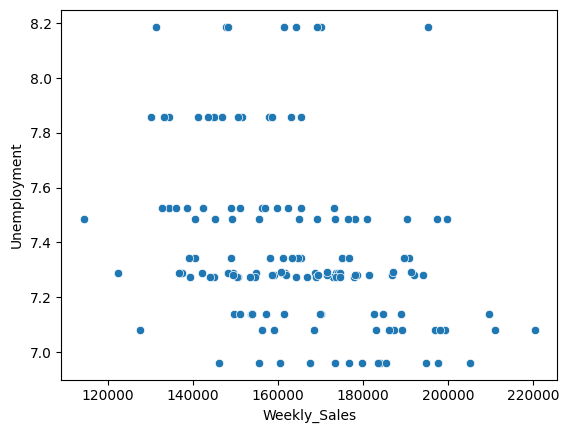

In [172]:
sns.scatterplot(x='Weekly_Sales', y='Unemployment', data=store20_imputed)
plt.show();

There was not clear correlation between sales and fuel price.

# 4. Conclusion

In order to forecast weekly sales for each department within each store, considering Walmart's 45 stores and 99 departments, I have narrowed down the analysis to focus on the performance of the largest store, Store 20, and the largest department, Department 92. By examining one specific performance , we aim to gain valuable insights and a better understanding of their individual performance within the broader dataset.

Overall, the analysis suggests that weekly sales are primarily influenced by holidays and markdowns, rather than external factors such as temperature, fuel price, or unemployment rate. This observation aligns with the nature of Walmart as a low-price retailer offering everyday essential products.

For the next part, we will use the data without any imputation to avoid data leakage during the model building process. The dataset (Department 92 of Store 20) we will be working with is as follows:

In [173]:
store20.to_csv('Data/data_store20')

In [174]:
store20.head()

Weekly_Sales  IsHoliday  Week  Year  Month  Temperature  \
Date                                                                  
2010-02-05     195223.84          0     5  2010      2        25.92   
2010-02-12     170043.55          1     6  2010      2        22.12   
2010-02-19     164314.29          0     7  2010      2        25.43   
2010-02-26     147699.66          0     8  2010      2        32.32   
2010-03-05     169171.18          0     9  2010      3        31.75   

            Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
Date                                                                            
2010-02-05       2.784        0.0        0.0        0.0        0.0        0.0   
2010-02-12       2.773        0.0        0.0        0.0        0.0        0.0   
2010-02-19       2.745        0.0        0.0        0.0        0.0        0.0   
2010-02-26       2.754        0.0        0.0        0.0        0.0        0.0   
2010-03-05       2.777        0.0        0.0        0.0        0.0        0.0   

                   CPI  Unemployment  
Date                                  
2010-02-05  204.247194         8.187  
2010-02-12  204.385747         8.187  
2010-02-19  204.432100         8.187  
2010-02-26  204.463087         8.187  
2010-03-05  204.494073         8.187